# Transfer Learning Part 2: Fine-tuning 

## IMporting helper functions

Rewriting certain functions to monitor and evaluate our model can be tedious, so we can make our own script for some mundane activities

### Downloading hellper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [1]:
# IMporting from helper functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, walk_through_dir

## Let's get Some data

# Get 10% of our data and unzip it

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

In [2]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [3]:
# Create training and test directory paths
TRAIN_DIR = "10_food_classes_10_percent/train/"
TEST_DIR = "10_food_classes_10_percent/test/"

In [4]:
import tensorflow as tf

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LABEL_MODE = 'categorical'

In [6]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory= TRAIN_DIR, image_size= IMG_SIZE, label_mode= LABEL_MODE, batch_size= BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= TEST_DIR, image_size= IMG_SIZE, label_mode= LABEL_MODE, batch_size= BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


2024-02-14 19:10:14.857985: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-02-14 19:10:14.858011: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-14 19:10:14.858018: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-14 19:10:14.858059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-14 19:10:14.858080: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# Check out class names of our dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an axample of batch of data
for images, labels in train_data.take(1):
    print(images, labels)

tf.Tensor(
[[[[ 48.         40.77041    35.459183 ]
   [ 35.15816    29.091835   28.923468 ]
   [ 35.035717   31.035717   31.607143 ]
   ...
   [167.70921   139.352     105.13774  ]
   [169.33163   139.33163   105.33163  ]
   [169.51526   136.51526   103.51526  ]]

  [[ 62.760204   53.188774   46.566326 ]
   [ 46.290813   38.290817   36.42347  ]
   [ 41.025517   35.05613    37.01021  ]
   ...
   [165.54077   139.77032   104.62749  ]
   [167.13777   137.13777   103.137764 ]
   [170.33167   137.33167   104.331665 ]]

  [[ 69.17347    55.25       44.32653  ]
   [ 70.30612    58.30613    53.392864 ]
   [ 88.63266    79.081635   79.821434 ]
   ...
   [165.81116   140.23969   105.02543  ]
   [165.27042   136.27042   102.27042  ]
   [167.78572   137.78572   103.78571  ]]

  ...

  [[208.4696    194.1124    196.89813  ]
   [209.66829   197.66829   199.66829  ]
   [171.714     160.88237   164.37726  ]
   ...
   [188.21426   156.87755   102.83164  ]
   [190.64291   159.21439   105.214386 ]
   [1

## Model 0: Building a transfer learning model using Keras Functionsal API

The sequential API is straight-forwar, it runs our layers in sequential order.

But the functiosn API gives us more flexibility with our models

In [10]:
# 1. Create base model, with tf.keras.application

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top= False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into out model
inputs = tf.keras.layers.Input(shape= IMG_SIZE + (3, ), name= "input_layer")

# 4. If using a model like ResNEt50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average poo the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name= "global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling 2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation= 'softmax', name= 'output_layer')(x)


# 8. Combing the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

# 10. Fit the model and save its hsitory
history_0 = model_0.fit(train_data,
                        epochs= 5,
                        steps_per_epoch= len(train_data),
                        validation_data= test_data,
                        validation_steps= len(test_data),
                        callbacks= [create_tensorboard_callback(
                            dir_name= "tensorflow_hub", experiment_name= 'model_0')]) 

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after Global Average Pooling 2D: (None, 1280)
Saving TensorBoard log files to: tensorflow_hub/model_0/20240214-191016
Epoch 1/5


2024-02-14 19:10:18.298754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-02-14 19:10:18.386942: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


24/24 [==============================] - 11s 336ms/step - loss: 1.9303 - accuracy: 0.3920 - val_loss: 1.3757 - val_accuracy: 0.7284
Epoch 2/5
24/24 [==============================] - 5s 231ms/step - loss: 1.2270 - accuracy: 0.7240 - val_loss: 0.9432 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 5s 215ms/step - loss: 0.9228 - accuracy: 0.8133 - val_loss: 0.7419 - val_accuracy: 0.8480
Epoch 4/5
24/24 [==============================] - 5s 215ms/step - loss: 0.7481 - accuracy: 0.8293 - val_loss: 0.6436 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 5s 218ms/step - loss: 0.6511 - accuracy: 0.8507 - val_loss: 0.5787 - val_accuracy: 0.8628


In [11]:
# Evaluate
model_0.evaluate(test_data)

79/79 [==============================] - 4s 50ms/step - loss: 0.5787 - accuracy: 0.8628


[0.5787268877029419, 0.8628000020980835]

In [12]:
# Check the layers in our base model
for layer_num, layer in enumerate(base_model.layers):
    print(layer_num, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [13]:
# how about we get the summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [14]:
# how about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

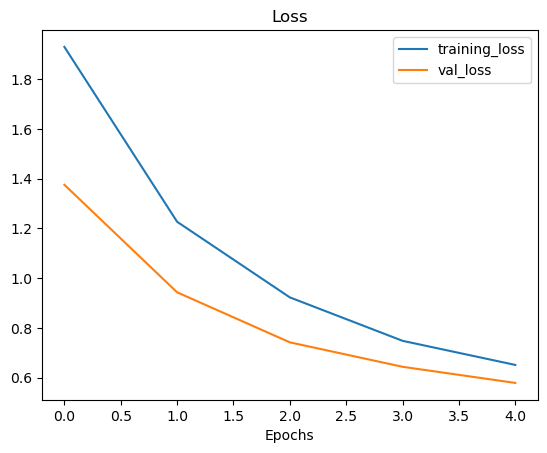

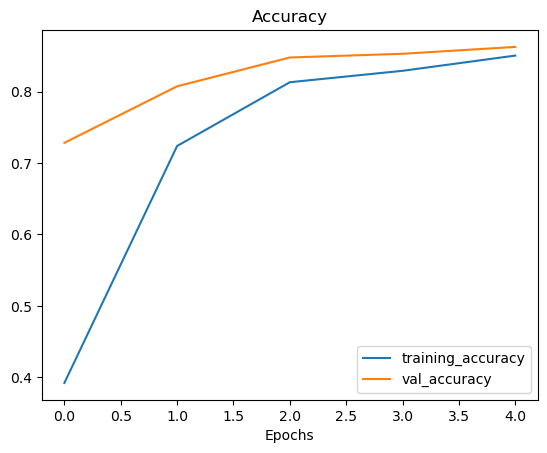

In [15]:
plot_loss_curves(history_0)

## Getting feature vector form trained model

Let's demonstrate GlobalAveragePooling2D layer

We have a tensor after our modle goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it through GlobalAveragePooling2D.

In [16]:
# Define input shape
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tesnor: \n {input_tensor} \n")

# Passing the random tensor trhough a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor} \n")

#Check the shape of the different tensord
print(f"Shape of input tensord: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensord: {global_average_pooled_tensor.shape}")

Random input tesnor: 
 [[[[ 0.3274686  -0.8426257   0.3194336 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.5397071   1.6994324 ]
   [ 0.28893656 -1.5066117  -0.26454768]]

  [[-0.5972242  -1.9171131  -0.6204413 ]
   [ 0.8504024  -0.4060477  -3.0258412 ]
   [ 0.9058465   0.29855984 -0.22561562]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772706]
   [ 0.24694408  0.20573746 -0.5256234 ]
   [ 0.32410023  0.02545409 -0.10638493]
   [-0.6369476   1.1603122   0.25073594]]

  [[-0.41728497  0.40125772 -1.4145442 ]
   [-0.5931858  -1.6617215   0.3356716 ]
   [ 0.1081563   0.23479682 -0.56668764]
   [-0.35819843  0.8869861   0.5274477 ]]]] 

2D global average pooled random tensor: 
 [[-0.09368647 -0.45840445 -0.28855982]] 

Shape of input tensord: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensord: (1, 3)


In [17]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis= [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368647, -0.45840445, -0.28855982]], dtype=float32)>

> **Practice**: Try to do the same withthe above two cells but this time use `GlobalMaxPool2D` ... and see what happens

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training dat, but how does it go with 1% of the training data... how about we set up a bunmch of experiments to find out:

1. `model_1` use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2`: use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3`: use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4`: use fine-tuning transfer learning on 100% of the training data with data augmentation


> **Note**: throughout all the experiments the same test dataset will be used to evaluate our model... thsi ensures consistency across evaluation metrics

## Getting and preprocessing our data for model_1

# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

In [18]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

In [19]:
# Creating training and test dir
TRAIN_DIR_1 = "10_food_classes_1_percent/train/"
TEST_DIR_1 = "10_food_classes_1_percent/test/"

In [20]:
# Setup data loaders

train_data_1 = tf.keras.preprocessing.image_dataset_from_directory(directory= TRAIN_DIR_1, label_mode= LABEL_MODE, batch_size= BATCH_SIZE, image_size= IMG_SIZE)

test_data_1 = tf.keras.preprocessing.image_dataset_from_directory(directory= TEST_DIR_1, label_mode= LABEL_MODE, batch_size= BATCH_SIZE, image_size= IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into out model, we can us the layers inside:

* tf.keras.layers.experimental.preprocessing()

We can see the benefits of doing this in the documentations of data augmentatioon inside the model

* Preprocessing of the images happens in GPU
* The preprocessing layers are also saved when the model is being saved to use as an idependent application

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # layers.Rescaling(1./255) # Keep for models like ResNet50 but EfficientNet already has the layer in built
], name= "data_augmentation")

(-0.5, 383.5, 511.5, -0.5)

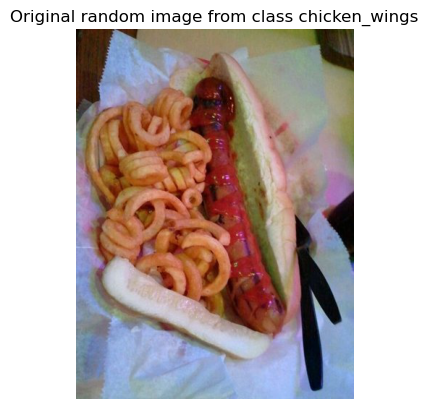

In [23]:
# View a random iamge and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

### Visualise or data augmentation layer

2024-02-14 19:10:53.193198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


(-0.5, 512.5, 332.5, -0.5)

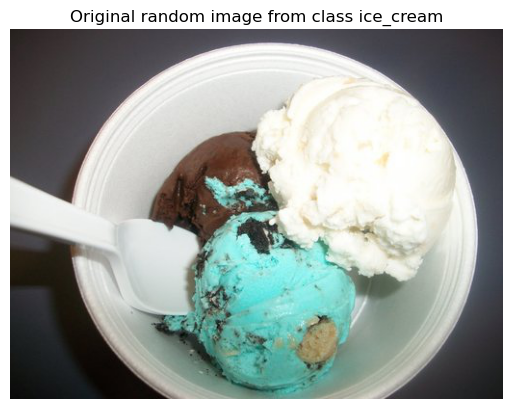

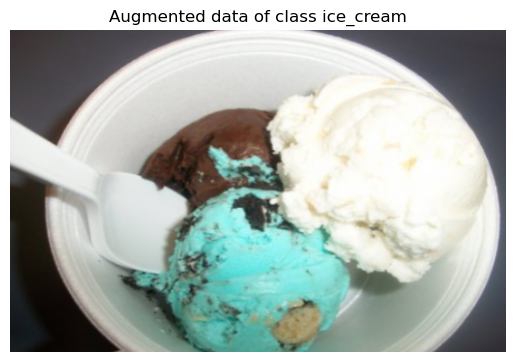

In [24]:
# View a random iamge and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image

augmented_img = data_augmentation(tf.expand_dims(img, axis= 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented data of class {target_class}")
plt.axis(False)

## Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation

In [25]:
# Setup the input shape and base model, freezing the base model layers

input_shape = IMG_SIZE + (3, )
base_model = tf.keras.applications.EfficientNetB0(include_top= False)

base_model.trainable = False

# Create input layer
inputs = layers.Input(shape= input_shape, name= 'input_layer')

#Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base_model the inputs and don't train it
x = base_model(x, training= False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation= 'softmax', name= 'output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

model_1.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(),
                metrics= ['accuracy'])

In [26]:
history_1_percent = model_1.fit(train_data_1, 
            epochs= 5,
            steps_per_epoch= len(train_data_1),
            validation_data= test_data_1,
            validation_steps= len(test_data_1),
            callbacks= [create_tensorboard_callback("tensorflow_hub", "1_percent_data_aug")])

Saving TensorBoard log files to: tensorflow_hub/1_percent_data_aug/20240214-191055
Epoch 1/5


2024-02-14 19:10:57.009702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 5s - loss: 2.6504 - accuracy: 0.0938

2024-02-14 19:10:57.951856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 0s - loss: 2.5223 - accuracy: 0.0938

2024-02-14 19:10:58.733975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 13s 5s/step - loss: 2.5434 - accuracy: 0.0857 - val_loss: 2.3211 - val_accuracy: 0.1328
Epoch 2/5


2024-02-14 19:11:07.842542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 1s - loss: 2.2389 - accuracy: 0.1562

2024-02-14 19:11:08.497682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 1s - loss: 2.2382 - accuracy: 0.1875

2024-02-14 19:11:09.674490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 8s 4s/step - loss: 2.2080 - accuracy: 0.2000 - val_loss: 2.1966 - val_accuracy: 0.1952
Epoch 3/5


2024-02-14 19:11:15.698427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 1s - loss: 2.0909 - accuracy: 0.3750

2024-02-14 19:11:16.485634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 0s - loss: 2.0419 - accuracy: 0.3438

2024-02-14 19:11:17.033854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 8s 3s/step - loss: 2.0235 - accuracy: 0.3429 - val_loss: 2.0835 - val_accuracy: 0.2788
Epoch 4/5


2024-02-14 19:11:23.351140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 1s - loss: 1.8595 - accuracy: 0.4688

2024-02-14 19:11:24.033952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 0s - loss: 1.8478 - accuracy: 0.4531

2024-02-14 19:11:24.662829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 8s 4s/step - loss: 1.8479 - accuracy: 0.4714 - val_loss: 1.9745 - val_accuracy: 0.3588
Epoch 5/5


2024-02-14 19:11:31.362267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


1/3 [=========>....................] - ETA: 1s - loss: 1.7614 - accuracy: 0.5312

2024-02-14 19:11:31.981322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


2/3 [===================>..........] - ETA: 0s - loss: 1.7662 - accuracy: 0.5625

2024-02-14 19:11:32.754255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


3/3 [==============================] - 7s 3s/step - loss: 1.7506 - accuracy: 0.5571 - val_loss: 1.8751 - val_accuracy: 0.4164


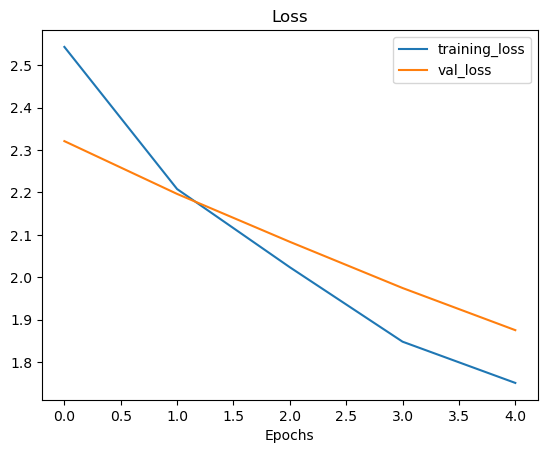

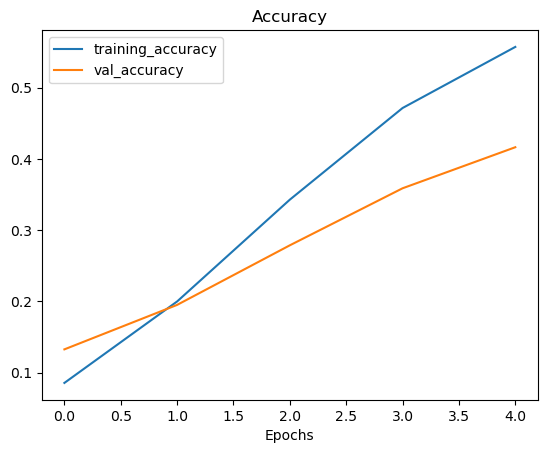

In [27]:
plot_loss_curves(history_1_percent)

In [28]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [29]:
# Evaluate
model_1.evaluate(test_data_1)

79/79 [==============================] - 6s 73ms/step - loss: 1.8751 - accuracy: 0.4164


[1.8751416206359863, 0.4163999855518341]

## Model 2: feature extraction transfer learning model with 10% data and data augmentation

In [30]:
# Get 10 % of our data
train_dir_10 = "10_food_classes_10_percent/train"
test_dir_10 = "10_food_classes_10_percent/test"

In [31]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [32]:
train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10, label_mode= LABEL_MODE, image_size= IMG_SIZE)

test_data_10 = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10, label_mode= LABEL_MODE, image_size= IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [33]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, None, None, 3)     0         
                                                                 
 random_rotation (RandomRot  (None, None, None, 3)     0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, None, None, 3)     0         
                                                                 
 random_height (RandomHeigh  (None, None, None, 3)     0         
 t)                                                              
                                                                 
 random_width (RandomWidth)  (None, None, None, 3)     0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (

In [34]:
# Create model 2 with data augmentation built in
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
], name= 'data_augmentation')

# Setup the input shape
input_shape = IMG_SIZE + (3, )

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create the inputs and outputs
inputs = layers.Input(shape= input_shape, name= 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training= False)
x = layers.GlobalAveragePooling2D(name= 'global_average_poolonmg_2D')(x)
outputs = layers.Dense(10, activation= 'softmax', name= 'output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(),
                metrics= ['accuracy'])

In [35]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_poolonmg_2D  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback immediately saves our model so that we can start where left. 

In [36]:
# Set checkpoint path
checkpoint_path = 'model_checkpoints/weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves models weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path, save_weights_only= True, save_best_only= False, save_freq= 'epoch', verbose= 1)

In [37]:
history_10_percent = model_2.fit(train_data_10,
            epochs= 5,
            steps_per_epoch= len(train_data_10),
            validation_data= test_data_10,
            validation_steps= len(test_data_10),
            callbacks= [create_tensorboard_callback('tensorflow_hub', "10_percent_data_aug"),
                        checkpoint_callback])

Saving TensorBoard log files to: tensorflow_hub/10_percent_data_aug/20240214-191145
Epoch 1/5


2024-02-14 19:11:47.793911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 1:34 - loss: 2.3387 - accuracy: 0.1562

2024-02-14 19:11:50.022341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 26s - loss: 2.2786 - accuracy: 0.1562 

2024-02-14 19:11:51.227939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 23s - loss: 2.2145 - accuracy: 0.1979

2024-02-14 19:11:52.203994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 21s - loss: 2.2059 - accuracy: 0.2031

2024-02-14 19:11:53.232331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 20s - loss: 2.1956 - accuracy: 0.2188

2024-02-14 19:11:54.273356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 19s - loss: 2.1791 - accuracy: 0.2344

2024-02-14 19:11:55.310846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 18s - loss: 2.1640 - accuracy: 0.2321

2024-02-14 19:11:56.508429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 16s - loss: 2.1586 - accuracy: 0.2344

2024-02-14 19:11:57.249422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 15s - loss: 2.1370 - accuracy: 0.2569

2024-02-14 19:11:58.217224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 14s - loss: 2.1117 - accuracy: 0.2688

2024-02-14 19:11:59.161566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 13s - loss: 2.0927 - accuracy: 0.2926

2024-02-14 19:12:00.037657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 11s - loss: 2.0689 - accuracy: 0.3151

2024-02-14 19:12:00.604701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 10s - loss: 2.0575 - accuracy: 0.3173

2024-02-14 19:12:01.275254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 9s - loss: 2.0315 - accuracy: 0.3348 

2024-02-14 19:12:01.853697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 8s - loss: 2.0139 - accuracy: 0.3458

2024-02-14 19:12:02.743544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 7s - loss: 1.9930 - accuracy: 0.3496

2024-02-14 19:12:03.662063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 6s - loss: 1.9734 - accuracy: 0.3621

2024-02-14 19:12:04.589491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 5s - loss: 1.9615 - accuracy: 0.3733

2024-02-14 19:12:05.051633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 4s - loss: 1.9458 - accuracy: 0.3914

2024-02-14 19:12:05.748134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 3s - loss: 1.9279 - accuracy: 0.4000

2024-02-14 19:12:06.179318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 2s - loss: 1.9177 - accuracy: 0.4033

2024-02-14 19:12:07.029637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 1s - loss: 1.9135 - accuracy: 0.4062

2024-02-14 19:12:08.033158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 0s - loss: 1.9027 - accuracy: 0.4130

2024-02-14 19:12:09.124474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 1.8986 - accuracy: 0.4120
Epoch 1: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 35s 1s/step - loss: 1.8986 - accuracy: 0.4120 - val_loss: 1.3473 - val_accuracy: 0.6984
Epoch 2/5


2024-02-14 19:12:20.565335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 25s - loss: 1.4513 - accuracy: 0.5938

2024-02-14 19:12:21.681105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 15s - loss: 1.4263 - accuracy: 0.6719

2024-02-14 19:12:22.361114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 16s - loss: 1.3724 - accuracy: 0.6979

2024-02-14 19:12:23.225619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 15s - loss: 1.3878 - accuracy: 0.6875

2024-02-14 19:12:24.028324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 14s - loss: 1.3594 - accuracy: 0.6875

2024-02-14 19:12:24.712039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 13s - loss: 1.3417 - accuracy: 0.6875

2024-02-14 19:12:25.458565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 12s - loss: 1.3472 - accuracy: 0.7009

2024-02-14 19:12:26.132690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 11s - loss: 1.3437 - accuracy: 0.6992

2024-02-14 19:12:26.816532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 11s - loss: 1.3251 - accuracy: 0.7083

2024-02-14 19:12:27.580900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 9s - loss: 1.3103 - accuracy: 0.7188 

2024-02-14 19:12:27.939530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 9s - loss: 1.3179 - accuracy: 0.7131

2024-02-14 19:12:29.317195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 9s - loss: 1.3062 - accuracy: 0.7109

2024-02-14 19:12:30.394616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 8s - loss: 1.3107 - accuracy: 0.7067

2024-02-14 19:12:31.229855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 7s - loss: 1.3117 - accuracy: 0.7076

2024-02-14 19:12:31.951725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 7s - loss: 1.3036 - accuracy: 0.7083

2024-02-14 19:12:32.730561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 6s - loss: 1.2917 - accuracy: 0.7148

2024-02-14 19:12:33.655837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 5s - loss: 1.2833 - accuracy: 0.7188

2024-02-14 19:12:34.047028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 4s - loss: 1.2798 - accuracy: 0.7135

2024-02-14 19:12:35.181415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 3s - loss: 1.2774 - accuracy: 0.7105

2024-02-14 19:12:35.683751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 3s - loss: 1.2610 - accuracy: 0.7188

2024-02-14 19:12:36.193519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 2s - loss: 1.2603 - accuracy: 0.7113

2024-02-14 19:12:36.890608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 1s - loss: 1.2533 - accuracy: 0.7060

2024-02-14 19:12:37.682227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 0s - loss: 1.2581 - accuracy: 0.6984

2024-02-14 19:12:38.371654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 1.2603 - accuracy: 0.6973
Epoch 2: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 26s 1s/step - loss: 1.2603 - accuracy: 0.6973 - val_loss: 0.9480 - val_accuracy: 0.7904
Epoch 3/5


2024-02-14 19:12:46.322867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 33s - loss: 0.9890 - accuracy: 0.7812

2024-02-14 19:12:47.805382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 18s - loss: 1.0450 - accuracy: 0.7656

2024-02-14 19:12:48.646295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 16s - loss: 1.1035 - accuracy: 0.7292

2024-02-14 19:12:49.378718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 14s - loss: 1.0816 - accuracy: 0.7344

2024-02-14 19:12:49.967509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 15s - loss: 1.0567 - accuracy: 0.7500

2024-02-14 19:12:50.980033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 14s - loss: 1.0240 - accuracy: 0.7760

2024-02-14 19:12:51.695382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 13s - loss: 1.0431 - accuracy: 0.7768

2024-02-14 19:12:52.650301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 14s - loss: 1.0138 - accuracy: 0.7852

2024-02-14 19:12:53.980280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 13s - loss: 0.9958 - accuracy: 0.7917

2024-02-14 19:12:55.062596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 12s - loss: 0.9897 - accuracy: 0.8000

2024-02-14 19:12:55.829157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 11s - loss: 1.0072 - accuracy: 0.7869

2024-02-14 19:12:56.635489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 10s - loss: 1.0090 - accuracy: 0.7839

2024-02-14 19:12:57.645115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 9s - loss: 1.0199 - accuracy: 0.7716 

2024-02-14 19:12:58.355278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 8s - loss: 1.0176 - accuracy: 0.7723

2024-02-14 19:12:59.368923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 8s - loss: 1.0321 - accuracy: 0.7583

2024-02-14 19:13:00.699683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 7s - loss: 1.0150 - accuracy: 0.7676

2024-02-14 19:13:01.524666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 6s - loss: 1.0118 - accuracy: 0.7684

2024-02-14 19:13:02.238342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 5s - loss: 1.0118 - accuracy: 0.7656

2024-02-14 19:13:03.267685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 4s - loss: 1.0096 - accuracy: 0.7648

2024-02-14 19:13:03.629341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 3s - loss: 1.0004 - accuracy: 0.7688

2024-02-14 19:13:04.088640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 2s - loss: 0.9877 - accuracy: 0.7708

2024-02-14 19:13:04.795273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 1s - loss: 0.9895 - accuracy: 0.7727

2024-02-14 19:13:05.472194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 0s - loss: 0.9837 - accuracy: 0.7745

2024-02-14 19:13:06.014080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 0.9853 - accuracy: 0.7720
Epoch 3: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 27s 1s/step - loss: 0.9853 - accuracy: 0.7720 - val_loss: 0.7720 - val_accuracy: 0.8228
Epoch 4/5


2024-02-14 19:13:13.427705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 19s - loss: 0.6502 - accuracy: 0.8750

2024-02-14 19:13:14.290103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 17s - loss: 0.8293 - accuracy: 0.8125

2024-02-14 19:13:15.063841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 13s - loss: 0.8160 - accuracy: 0.8125

2024-02-14 19:13:15.598332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 15s - loss: 0.8256 - accuracy: 0.8281

2024-02-14 19:13:16.568405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 13s - loss: 0.8362 - accuracy: 0.8062

2024-02-14 19:13:17.187144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 14s - loss: 0.8414 - accuracy: 0.7969

2024-02-14 19:13:18.317615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 13s - loss: 0.8732 - accuracy: 0.7812

2024-02-14 19:13:19.004677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 13s - loss: 0.8533 - accuracy: 0.7852

2024-02-14 19:13:20.001024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 12s - loss: 0.8322 - accuracy: 0.7986

2024-02-14 19:13:21.022773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 11s - loss: 0.8256 - accuracy: 0.8031

2024-02-14 19:13:21.943287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 11s - loss: 0.8331 - accuracy: 0.7955

2024-02-14 19:13:22.786414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 10s - loss: 0.8206 - accuracy: 0.7969

2024-02-14 19:13:23.806220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 9s - loss: 0.8229 - accuracy: 0.7981 

2024-02-14 19:13:24.477382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 8s - loss: 0.8310 - accuracy: 0.7924

2024-02-14 19:13:25.195246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 7s - loss: 0.8122 - accuracy: 0.8000

2024-02-14 19:13:26.448790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 7s - loss: 0.8162 - accuracy: 0.7988

2024-02-14 19:13:27.627224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 6s - loss: 0.8157 - accuracy: 0.7978

2024-02-14 19:13:28.499855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 5s - loss: 0.8237 - accuracy: 0.7969

2024-02-14 19:13:29.019006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 4s - loss: 0.8196 - accuracy: 0.8010

2024-02-14 19:13:30.189384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 3s - loss: 0.8155 - accuracy: 0.8016

2024-02-14 19:13:31.092672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 2s - loss: 0.8203 - accuracy: 0.8006

2024-02-14 19:13:31.843245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 1s - loss: 0.8187 - accuracy: 0.7997

2024-02-14 19:13:32.476808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 0s - loss: 0.8099 - accuracy: 0.8057

2024-02-14 19:13:33.090003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 0.8101 - accuracy: 0.8027
Epoch 4: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 28s 1s/step - loss: 0.8101 - accuracy: 0.8027 - val_loss: 0.6686 - val_accuracy: 0.8380
Epoch 5/5


2024-02-14 19:13:41.112891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 19s - loss: 0.8130 - accuracy: 0.7812

2024-02-14 19:13:41.982284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 16s - loss: 0.7613 - accuracy: 0.8125

2024-02-14 19:13:42.736596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 15s - loss: 0.7992 - accuracy: 0.7917

2024-02-14 19:13:43.491077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 14s - loss: 0.7572 - accuracy: 0.8203

2024-02-14 19:13:44.152552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 15s - loss: 0.7394 - accuracy: 0.8313

2024-02-14 19:13:45.281782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 14s - loss: 0.7292 - accuracy: 0.8438

2024-02-14 19:13:46.057402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 13s - loss: 0.7151 - accuracy: 0.8527

2024-02-14 19:13:46.647684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 12s - loss: 0.7373 - accuracy: 0.8438

2024-02-14 19:13:47.445453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 11s - loss: 0.7254 - accuracy: 0.8472

2024-02-14 19:13:48.279511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 11s - loss: 0.7295 - accuracy: 0.8438

2024-02-14 19:13:49.574205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 11s - loss: 0.7280 - accuracy: 0.8381

2024-02-14 19:13:50.722807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 10s - loss: 0.7317 - accuracy: 0.8359

2024-02-14 19:13:51.612064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 9s - loss: 0.7353 - accuracy: 0.8293 

2024-02-14 19:13:52.859950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 8s - loss: 0.7182 - accuracy: 0.8326

2024-02-14 19:13:53.530068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 7s - loss: 0.7125 - accuracy: 0.8354

2024-02-14 19:13:54.044727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 6s - loss: 0.7110 - accuracy: 0.8340

2024-02-14 19:13:55.028754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 6s - loss: 0.7242 - accuracy: 0.8235

2024-02-14 19:13:55.915491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 5s - loss: 0.7289 - accuracy: 0.8212

2024-02-14 19:13:56.720145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 4s - loss: 0.7393 - accuracy: 0.8174

2024-02-14 19:13:57.465736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 3s - loss: 0.7470 - accuracy: 0.8109

2024-02-14 19:13:58.619341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 2s - loss: 0.7415 - accuracy: 0.8080

2024-02-14 19:13:59.385459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 1s - loss: 0.7405 - accuracy: 0.8097

2024-02-14 19:14:00.252601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 0s - loss: 0.7378 - accuracy: 0.8084

2024-02-14 19:14:01.355772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.8093
Epoch 5: saving model to model_checkpoints/weights/checkpoint.ckpt
24/24 [==============================] - 32s 1s/step - loss: 0.7352 - accuracy: 0.8093 - val_loss: 0.6143 - val_accuracy: 0.8420


In [38]:
model_0.evaluate(test_data)

79/79 [==============================] - 21s 239ms/step - loss: 0.5787 - accuracy: 0.8628


[0.5787268877029419, 0.8628000020980835]

In [39]:
model_2.evaluate(test_data_10)

79/79 [==============================] - 12s 142ms/step - loss: 0.6143 - accuracy: 0.8420


[0.6143026351928711, 0.8420000076293945]

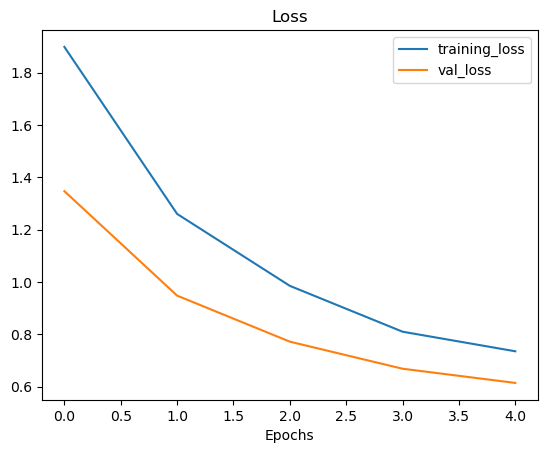

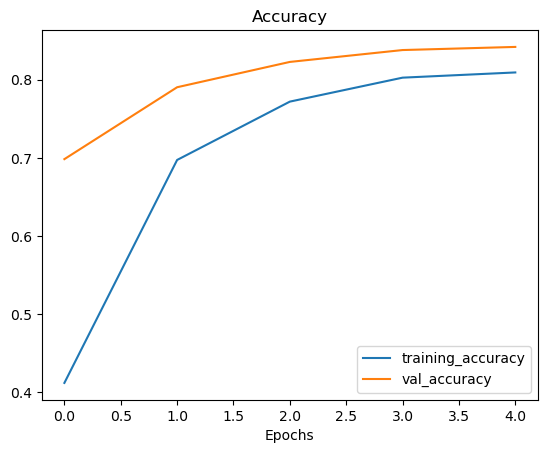

In [40]:
plot_loss_curves(history_10_percent)

### Loading in checkpointed weights

Loading in checkpoint weights returns a model to a specific checkpoint

In [41]:
# Load in saved models weights and evaluate model 
model_2.load_weights(checkpoint_path)

In [42]:
# Evaluate model_2 with loaded weights
model_2.evaluate(test_data_10)

79/79 [==============================] - 12s 144ms/step - loss: 0.6143 - accuracy: 0.8420


[0.6143027544021606, 0.8420000076293945]

In [43]:
# Check to see if loaded model results are very close to our previous non-loaded model results

# import numpy as np
# np.isclose()

## Model 3: Fine-tuning an existing model on 10% of the data

> **Note**: Fine tuning usually works best after training a feature extraction model for a few epochs with large amount of custom dataset

In [44]:
# Layers in loaded model
model_2.layers

In [45]:
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x30494c430> True
<keras.src.engine.sequential.Sequential object at 0x2d96c18a0> True
<keras.src.engine.functional.Functional object at 0x3340e5840> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x2d96c3d60> True
<keras.src.layers.core.dense.Dense object at 0x3340a1480> True


In [46]:
# LAyers in out base model and are they trainable
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [47]:
# How many trainable variables are in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [48]:
# To begin fine tuning let;s start by setting the last 10 layers of our bas_model.tranable = True

base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we recompile our models every time we make a change)
model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(learning_rate= 0.0001), # when fine tuning you typically want to lower your learning rate by 10x
                metrics= ['accuracy'])

> **Note**: When using fine-tuning, it is a best practice to lower your learning rate. A good thumb rule is to lower it by 10x

A good resource for information on this is the [ULMFit paper](https://arxiv.org/abs/1801.06146)

In [49]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [50]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are available
len(model_2.trainable_variables)

12

In [51]:
# Fine tune for another 5 epochs
fine_tune_epochs = 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent = model_2.fit(train_data_10,
                                      epochs= fine_tune_epochs,
                                      steps_per_epoch= len(train_data_10),
                                      validation_data= test_data_10,
                                      validation_steps= int(0.25 * len(test_data_10)),
                                      initial_epoch= history_10_percent.epoch[-1], # start training from prevous last epoch,
                                      callbacks= [create_tensorboard_callback('tensorflow_hub', '10_percent_fine_tune')])

Saving TensorBoard log files to: tensorflow_hub/10_percent_fine_tune/20240214-191458
Epoch 5/10


2024-02-14 19:15:00.182744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 2:21 - loss: 0.5712 - accuracy: 0.8750

2024-02-14 19:15:04.367517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 43s - loss: 0.5654 - accuracy: 0.8750 

2024-02-14 19:15:06.329919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 40s - loss: 0.6365 - accuracy: 0.8438

2024-02-14 19:15:08.201604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 41s - loss: 0.6335 - accuracy: 0.8438

2024-02-14 19:15:10.656202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 35s - loss: 0.6125 - accuracy: 0.8500

2024-02-14 19:15:11.924418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 32s - loss: 0.6507 - accuracy: 0.8333

2024-02-14 19:15:13.316589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 31s - loss: 0.6594 - accuracy: 0.8259

2024-02-14 19:15:15.336112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 27s - loss: 0.6293 - accuracy: 0.8320

2024-02-14 19:15:16.545883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 27s - loss: 0.6177 - accuracy: 0.8403

2024-02-14 19:15:18.870985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 24s - loss: 0.6303 - accuracy: 0.8281

2024-02-14 19:15:20.053408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 22s - loss: 0.6139 - accuracy: 0.8381

2024-02-14 19:15:21.806645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 21s - loss: 0.6263 - accuracy: 0.8307

2024-02-14 19:15:24.303478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 19s - loss: 0.6407 - accuracy: 0.8317

2024-02-14 19:15:26.151638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 18s - loss: 0.6385 - accuracy: 0.8304

2024-02-14 19:15:27.912483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 15s - loss: 0.6285 - accuracy: 0.8313

2024-02-14 19:15:28.741664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 13s - loss: 0.6251 - accuracy: 0.8359

2024-02-14 19:15:29.861967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 11s - loss: 0.6247 - accuracy: 0.8364

2024-02-14 19:15:31.140118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 10s - loss: 0.6298 - accuracy: 0.8333

2024-02-14 19:15:32.831388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 8s - loss: 0.6269 - accuracy: 0.8355 

2024-02-14 19:15:34.109355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 6s - loss: 0.6202 - accuracy: 0.8375

2024-02-14 19:15:35.877547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 4s - loss: 0.6218 - accuracy: 0.8348

2024-02-14 19:15:37.406205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 3s - loss: 0.6126 - accuracy: 0.8366

2024-02-14 19:15:38.366993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.6113 - accuracy: 0.8370

2024-02-14 19:15:39.990511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - 53s 2s/step - loss: 0.6125 - accuracy: 0.8360 - val_loss: 0.4744 - val_accuracy: 0.8553
Epoch 6/10


2024-02-14 19:15:51.291889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 38s - loss: 0.5198 - accuracy: 0.8750

2024-02-14 19:15:52.960905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 28s - loss: 0.4601 - accuracy: 0.8594

2024-02-14 19:15:54.240258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 32s - loss: 0.4142 - accuracy: 0.8750

2024-02-14 19:15:56.041715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 27s - loss: 0.4789 - accuracy: 0.8281

2024-02-14 19:15:57.130397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 25s - loss: 0.4588 - accuracy: 0.8438

2024-02-14 19:15:58.342281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 23s - loss: 0.4570 - accuracy: 0.8385

2024-02-14 19:15:59.368057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 21s - loss: 0.4395 - accuracy: 0.8571

2024-02-14 19:16:00.419861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 19s - loss: 0.4393 - accuracy: 0.8594

2024-02-14 19:16:01.652282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 19s - loss: 0.4540 - accuracy: 0.8507

2024-02-14 19:16:03.194461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 17s - loss: 0.4547 - accuracy: 0.8531

2024-02-14 19:16:04.242501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 16s - loss: 0.4518 - accuracy: 0.8551

2024-02-14 19:16:05.412740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 15s - loss: 0.4676 - accuracy: 0.8542

2024-02-14 19:16:06.835919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 13s - loss: 0.4638 - accuracy: 0.8582

2024-02-14 19:16:07.803953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 12s - loss: 0.4725 - accuracy: 0.8549

2024-02-14 19:16:08.908130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 10s - loss: 0.4761 - accuracy: 0.8500

2024-02-14 19:16:09.773772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 9s - loss: 0.4881 - accuracy: 0.8516 

2024-02-14 19:16:11.276026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 8s - loss: 0.4942 - accuracy: 0.8493

2024-02-14 19:16:12.638279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 7s - loss: 0.4937 - accuracy: 0.8472

2024-02-14 19:16:14.407032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 6s - loss: 0.4988 - accuracy: 0.8454

2024-02-14 19:16:15.741475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 5s - loss: 0.5030 - accuracy: 0.8453

2024-02-14 19:16:16.908152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 3s - loss: 0.5022 - accuracy: 0.8467

2024-02-14 19:16:19.138021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 2s - loss: 0.4979 - accuracy: 0.8480

2024-02-14 19:16:20.819967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.4908 - accuracy: 0.8505

2024-02-14 19:16:21.785730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - 39s 2s/step - loss: 0.4941 - accuracy: 0.8493 - val_loss: 0.4032 - val_accuracy: 0.8816
Epoch 7/10


2024-02-14 19:16:29.819155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 25s - loss: 0.3744 - accuracy: 0.9375

2024-02-14 19:16:30.906665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 21s - loss: 0.3969 - accuracy: 0.9062

2024-02-14 19:16:31.875518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 20s - loss: 0.4073 - accuracy: 0.8750

2024-02-14 19:16:32.812017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 18s - loss: 0.4028 - accuracy: 0.8750

2024-02-14 19:16:33.733611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 20s - loss: 0.4015 - accuracy: 0.8813

2024-02-14 19:16:35.266137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 21s - loss: 0.3889 - accuracy: 0.8906

2024-02-14 19:16:36.908757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 20s - loss: 0.4090 - accuracy: 0.8795

2024-02-14 19:16:38.255799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 18s - loss: 0.4289 - accuracy: 0.8750

2024-02-14 19:16:39.021623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 19s - loss: 0.4230 - accuracy: 0.8715

2024-02-14 19:16:41.174224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 17s - loss: 0.4021 - accuracy: 0.8813

2024-02-14 19:16:41.881090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 16s - loss: 0.3924 - accuracy: 0.8835

2024-02-14 19:16:43.609941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 15s - loss: 0.4024 - accuracy: 0.8802

2024-02-14 19:16:44.761518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 14s - loss: 0.4171 - accuracy: 0.8798

2024-02-14 19:16:46.464035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 12s - loss: 0.4191 - accuracy: 0.8772

2024-02-14 19:16:47.789532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 11s - loss: 0.4051 - accuracy: 0.8813

2024-02-14 19:16:48.619701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 10s - loss: 0.4127 - accuracy: 0.8789

2024-02-14 19:16:50.392129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 9s - loss: 0.4184 - accuracy: 0.8787 

2024-02-14 19:16:51.564470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 7s - loss: 0.4122 - accuracy: 0.8819

2024-02-14 19:16:52.526173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 6s - loss: 0.4218 - accuracy: 0.8750

2024-02-14 19:16:53.752597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 5s - loss: 0.4244 - accuracy: 0.8734

2024-02-14 19:16:54.870136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 3s - loss: 0.4233 - accuracy: 0.8720

2024-02-14 19:16:56.050570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 2s - loss: 0.4289 - accuracy: 0.8722

2024-02-14 19:16:57.505904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.4287 - accuracy: 0.8709

2024-02-14 19:16:58.584638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - 37s 2s/step - loss: 0.4334 - accuracy: 0.8693 - val_loss: 0.4320 - val_accuracy: 0.8701
Epoch 8/10


2024-02-14 19:17:07.173187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 35s - loss: 0.4500 - accuracy: 0.9375

2024-02-14 19:17:08.705682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 13s - loss: 0.4727 - accuracy: 0.8906

2024-02-14 19:17:09.313883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 25s - loss: 0.4508 - accuracy: 0.8958

2024-02-14 19:17:11.129161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 24s - loss: 0.3966 - accuracy: 0.9062

2024-02-14 19:17:12.427325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 26s - loss: 0.3813 - accuracy: 0.9000

2024-02-14 19:17:14.214524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 28s - loss: 0.3972 - accuracy: 0.8906

2024-02-14 19:17:16.601096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 26s - loss: 0.3820 - accuracy: 0.8973

2024-02-14 19:17:17.930308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 23s - loss: 0.4149 - accuracy: 0.8867

2024-02-14 19:17:18.862236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 20s - loss: 0.4219 - accuracy: 0.8819

2024-02-14 19:17:19.436513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 18s - loss: 0.4110 - accuracy: 0.8844

2024-02-14 19:17:20.431225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 16s - loss: 0.3992 - accuracy: 0.8892

2024-02-14 19:17:21.190271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 14s - loss: 0.4276 - accuracy: 0.8750

2024-02-14 19:17:22.395366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 13s - loss: 0.4286 - accuracy: 0.8750

2024-02-14 19:17:23.599555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 12s - loss: 0.4203 - accuracy: 0.8772

2024-02-14 19:17:25.189862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 11s - loss: 0.4166 - accuracy: 0.8792

2024-02-14 19:17:26.097763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 9s - loss: 0.4170 - accuracy: 0.8809 

2024-02-14 19:17:27.026371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 8s - loss: 0.4149 - accuracy: 0.8787

2024-02-14 19:17:28.402664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 7s - loss: 0.4271 - accuracy: 0.8715

2024-02-14 19:17:29.295010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 6s - loss: 0.4272 - accuracy: 0.8717

2024-02-14 19:17:30.390210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 4s - loss: 0.4246 - accuracy: 0.8719

2024-02-14 19:17:31.742426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 3s - loss: 0.4175 - accuracy: 0.8750

2024-02-14 19:17:32.662524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 2s - loss: 0.4092 - accuracy: 0.8778

2024-02-14 19:17:33.774567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.4138 - accuracy: 0.8750

2024-02-14 19:17:34.636975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - 35s 1s/step - loss: 0.4092 - accuracy: 0.8760 - val_loss: 0.4154 - val_accuracy: 0.8766
Epoch 9/10


2024-02-14 19:17:42.606355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 37s - loss: 0.4978 - accuracy: 0.7500

2024-02-14 19:17:44.243458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 23s - loss: 0.4507 - accuracy: 0.8125

2024-02-14 19:17:45.303802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 24s - loss: 0.4417 - accuracy: 0.8438

2024-02-14 19:17:46.614182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 24s - loss: 0.4178 - accuracy: 0.8516

2024-02-14 19:17:47.893559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 22s - loss: 0.3958 - accuracy: 0.8562

2024-02-14 19:17:48.978759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 21s - loss: 0.3539 - accuracy: 0.8802

2024-02-14 19:17:50.271382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 20s - loss: 0.3826 - accuracy: 0.8750

2024-02-14 19:17:51.413803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 18s - loss: 0.3596 - accuracy: 0.8906

2024-02-14 19:17:52.422179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 17s - loss: 0.3630 - accuracy: 0.8854

2024-02-14 19:17:53.591948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 15s - loss: 0.3570 - accuracy: 0.8875

2024-02-14 19:17:54.474563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 14s - loss: 0.3633 - accuracy: 0.8807

2024-02-14 19:17:55.743679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 13s - loss: 0.3539 - accuracy: 0.8880

2024-02-14 19:17:56.751707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 12s - loss: 0.3569 - accuracy: 0.8870

2024-02-14 19:17:58.260804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 11s - loss: 0.3584 - accuracy: 0.8884

2024-02-14 19:17:59.732930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 10s - loss: 0.3534 - accuracy: 0.8917

2024-02-14 19:18:00.724254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 9s - loss: 0.3502 - accuracy: 0.8945 

2024-02-14 19:18:02.377564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 8s - loss: 0.3674 - accuracy: 0.8915

2024-02-14 19:18:03.538140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 7s - loss: 0.3672 - accuracy: 0.8906

2024-02-14 19:18:04.728500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 6s - loss: 0.3585 - accuracy: 0.8947

2024-02-14 19:18:06.068363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 5s - loss: 0.3568 - accuracy: 0.8906

2024-02-14 19:18:08.314047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 3s - loss: 0.3504 - accuracy: 0.8914

2024-02-14 19:18:10.308872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 2s - loss: 0.3425 - accuracy: 0.8963

2024-02-14 19:18:11.284284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.3426 - accuracy: 0.8981

2024-02-14 19:18:12.226338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - 37s 2s/step - loss: 0.3449 - accuracy: 0.8973 - val_loss: 0.3969 - val_accuracy: 0.8734
Epoch 10/10


2024-02-14 19:18:19.627497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/24 [>.............................] - ETA: 28s - loss: 0.2361 - accuracy: 0.9375

2024-02-14 19:18:20.866250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/24 [=>............................] - ETA: 40s - loss: 0.2185 - accuracy: 0.9531

2024-02-14 19:18:22.719376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/24 [==>...........................] - ETA: 34s - loss: 0.2182 - accuracy: 0.9583

2024-02-14 19:18:24.117684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/24 [====>.........................] - ETA: 30s - loss: 0.3153 - accuracy: 0.9141

2024-02-14 19:18:25.471772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/24 [=====>........................] - ETA: 28s - loss: 0.3234 - accuracy: 0.8938

2024-02-14 19:18:26.846314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/24 [======>.......................] - ETA: 25s - loss: 0.3625 - accuracy: 0.8854

2024-02-14 19:18:27.922074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/24 [=======>......................] - ETA: 22s - loss: 0.3546 - accuracy: 0.8973

2024-02-14 19:18:28.913463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/24 [=========>....................] - ETA: 22s - loss: 0.3819 - accuracy: 0.8984

2024-02-14 19:18:30.807264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/24 [==========>...................] - ETA: 21s - loss: 0.3641 - accuracy: 0.9062

2024-02-14 19:18:32.326379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/24 [===========>..................] - ETA: 21s - loss: 0.3466 - accuracy: 0.9125

2024-02-14 19:18:34.575484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/24 [============>.................] - ETA: 19s - loss: 0.3403 - accuracy: 0.9148

2024-02-14 19:18:36.020723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/24 [==============>...............] - ETA: 17s - loss: 0.3275 - accuracy: 0.9193

2024-02-14 19:18:37.161852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/24 [===============>..............] - ETA: 16s - loss: 0.3200 - accuracy: 0.9207

2024-02-14 19:18:39.224003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/24 [================>.............] - ETA: 15s - loss: 0.3183 - accuracy: 0.9196

2024-02-14 19:18:40.611932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/24 [=================>............] - ETA: 13s - loss: 0.3151 - accuracy: 0.9187

2024-02-14 19:18:41.520429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/24 [===================>..........] - ETA: 11s - loss: 0.3085 - accuracy: 0.9219

2024-02-14 19:18:42.844264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/24 [====================>.........] - ETA: 10s - loss: 0.3032 - accuracy: 0.9246

2024-02-14 19:18:43.982964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/24 [=====================>........] - ETA: 8s - loss: 0.3018 - accuracy: 0.9271 

2024-02-14 19:18:44.989329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/24 [======================>.......] - ETA: 7s - loss: 0.3009 - accuracy: 0.9276

2024-02-14 19:18:46.073938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/24 [========================>.....] - ETA: 5s - loss: 0.3032 - accuracy: 0.9266

2024-02-14 19:18:47.395311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/24 [=========================>....] - ETA: 4s - loss: 0.3107 - accuracy: 0.9241

2024-02-14 19:18:48.677621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/24 [==========================>...] - ETA: 2s - loss: 0.3074 - accuracy: 0.9261

2024-02-14 19:18:49.865900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/24 [===========================>..] - ETA: 1s - loss: 0.3061 - accuracy: 0.9266

2024-02-14 19:18:51.158271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/24 [==============================] - 39s 2s/step - loss: 0.3085 - accuracy: 0.9253 - val_loss: 0.3894 - val_accuracy: 0.8849


In [52]:
model_2.evaluate(test_data_10)

79/79 [==============================] - 25s 316ms/step - loss: 0.4041 - accuracy: 0.8676


[0.40405672788619995, 0.8676000237464905]

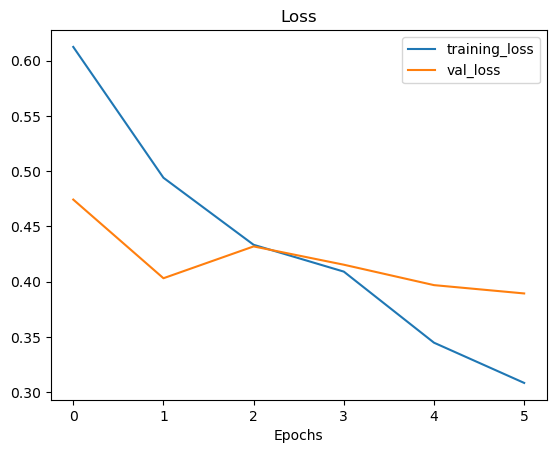

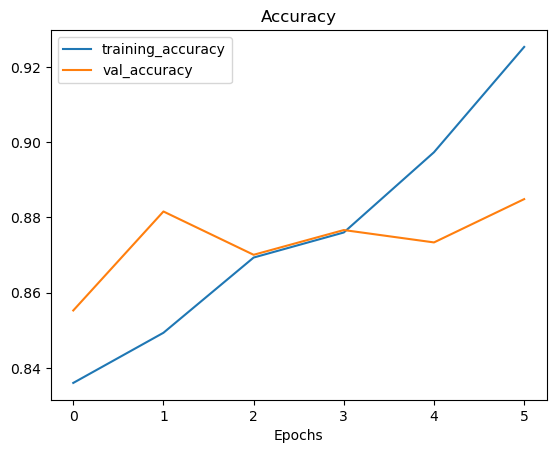

In [53]:
# Check out the loss curve of our fine tuned model
plot_loss_curves(history_fine_10_percent)

The `plot_loss_curve function` works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another

In [54]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs= 5):
    '''
    Comapres two Tensorflow History objects
    '''

    # Get original history measurements
    accuracy = original_history.history['accuracy']
    val_accuracy = original_history.history['val_accuracy']

    loss = original_history.history['loss']
    val_loss = original_history.history['val_loss']

    # Combine original history
    total_accuracy = accuracy + new_history.history['accuracy']
    total_val_accuracy = val_accuracy + new_history.history['val_accuracy']
    total_loss = loss + new_history.history['loss']
    total_val_loss = val_loss + new_history.history['val_loss']

    # Make plots
    plt.figure(figsize= (8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_accuracy, label= 'Total Training Accuracy')
    plt.plot(total_val_accuracy, label= 'Total Testing Accuracy')
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label= 'Start Fine Tuning')
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label= 'Total Training Loss Values')
    plt.plot(total_val_loss, label= 'Total Testing Loss Values')
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label= 'Start Fine Tuning')
    plt.legend()
    plt.title("Training and Validation Loss Value")

    plt.tight_layout()

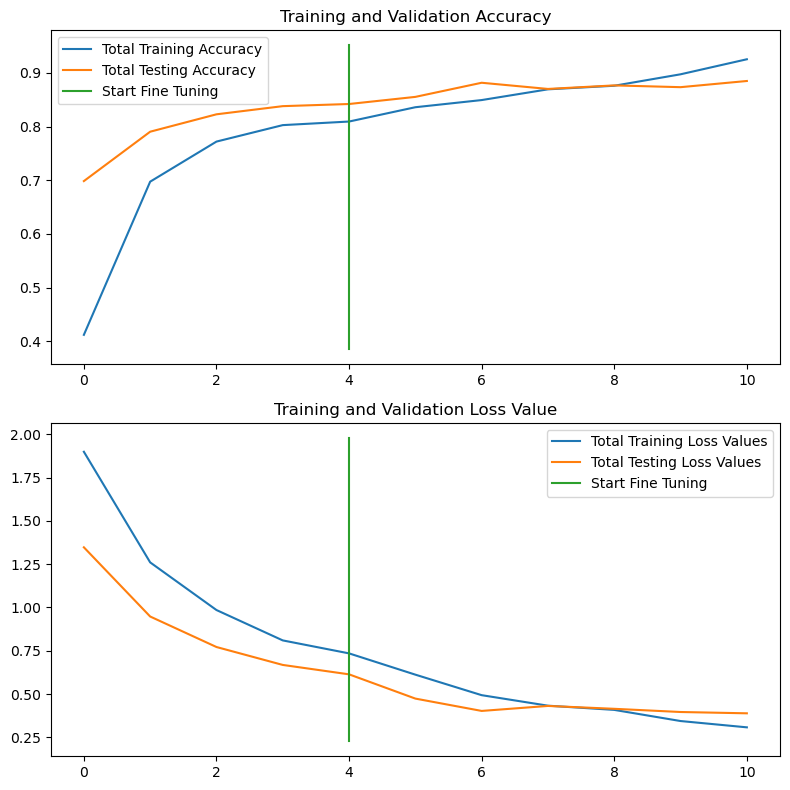

In [55]:
compare_histories(original_history= history_10_percent,
                  new_history= history_fine_10_percent,
                  initial_epochs= 5)

## Model 4: Fine-tuning and existing model on all the data

# Download and unzip 10 classes of Fodd101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

In [56]:
# Setup training and test dir
TRAIN_DIR_2 = "10_food_classes_all_data/train"
TEST_DIR_2 = "10_food_classes_all_data/test"

In [57]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [58]:
# Setup data inputs
train_data_full = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR_2, label_mode= LABEL_MODE, image_size= IMG_SIZE, batch_size= BATCH_SIZE)

test_data_full = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR_2, label_mode= LABEL_MODE, image_size= IMG_SIZE, batch_size= BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in it is the same as what we've been using for previous experiments

Let's verify

In [59]:
# Evaluate model_2
model_2.evaluate(test_data_full)

79/79 [==============================] - 24s 304ms/step - loss: 0.4041 - accuracy: 0.8676


[0.40405669808387756, 0.8676000237464905]

To train a fine-tuning model we need to revert model_2 back to its feature extraction weights

In [60]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [61]:
model_2.evaluate(test_data_full)

79/79 [==============================] - 23s 295ms/step - loss: 0.6143 - accuracy: 0.8420


[0.6143028140068054, 0.8420000076293945]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% percent of the data with data augmnetation and we saved model's weight using `ModelCheckpoint` Callback
2. Fine-tuned to same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unforzen
3. Saved the results and training logs each time 
4. Reloaded the model from step 1 to do the same steps as stpe 2 except this time we're going to use all of the data

In [62]:
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_poolonmg_2D True
4 output_layer True


In [63]:
# Let's drill into our base model
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [64]:
model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(learning_rate= 0.0001),
                metrics= ['accuracy'])

In [65]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [66]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = 10

history_fine_full = model_2.fit(train_data_full,
                                epochs= fine_tune_epochs,
                                validation_data= test_data_full,
                                validation_steps= int(0.25 * len(test_data_full)),
                                initial_epoch= history_10_percent.epoch[-1],
                                callbacks= [create_tensorboard_callback('tensorflow_hub', 'full_10_classes_fine_tune')])

Saving TensorBoard log files to: tensorflow_hub/full_10_classes_fine_tune/20240214-192012
Epoch 5/10


2024-02-14 19:20:14.675439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/235 [..............................] - ETA: 33:53 - loss: 0.8400 - accuracy: 0.7812

2024-02-14 19:20:21.600277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/235 [..............................] - ETA: 16:38 - loss: 0.8419 - accuracy: 0.7812

2024-02-14 19:20:25.908135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/235 [..............................] - ETA: 13:47 - loss: 0.9447 - accuracy: 0.7188

2024-02-14 19:20:28.728943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/235 [..............................] - ETA: 13:18 - loss: 0.8760 - accuracy: 0.7578

2024-02-14 19:20:31.952267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/235 [..............................] - ETA: 11:32 - loss: 0.8543 - accuracy: 0.7625

2024-02-14 19:20:33.634037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/235 [..............................] - ETA: 13:51 - loss: 0.8300 - accuracy: 0.7656

2024-02-14 19:20:39.734482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/235 [..............................] - ETA: 16:16 - loss: 0.8450 - accuracy: 0.7589

2024-02-14 19:20:47.267325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/235 [>.............................] - ETA: 17:29 - loss: 0.8581 - accuracy: 0.7578

2024-02-14 19:20:54.001620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/235 [>.............................] - ETA: 16:39 - loss: 0.8188 - accuracy: 0.7743

2024-02-14 19:20:56.967993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/235 [>.............................] - ETA: 16:00 - loss: 0.8271 - accuracy: 0.7719

2024-02-14 19:20:59.985448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/235 [>.............................] - ETA: 14:50 - loss: 0.8150 - accuracy: 0.7727

2024-02-14 19:21:01.353491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/235 [>.............................] - ETA: 14:40 - loss: 0.8228 - accuracy: 0.7630

2024-02-14 19:21:05.032998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/235 [>.............................] - ETA: 14:28 - loss: 0.8010 - accuracy: 0.7716

2024-02-14 19:21:08.549184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/235 [>.............................] - ETA: 13:46 - loss: 0.7897 - accuracy: 0.7723

2024-02-14 19:21:10.207197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/235 [>.............................] - ETA: 13:35 - loss: 0.7947 - accuracy: 0.7750

2024-02-14 19:21:13.461982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/235 [=>............................] - ETA: 13:13 - loss: 0.7780 - accuracy: 0.7832

2024-02-14 19:21:15.923307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/235 [=>............................] - ETA: 12:42 - loss: 0.7807 - accuracy: 0.7849

2024-02-14 19:21:17.547330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/235 [=>............................] - ETA: 12:32 - loss: 0.7751 - accuracy: 0.7882

2024-02-14 19:21:20.511872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/235 [=>............................] - ETA: 12:07 - loss: 0.7789 - accuracy: 0.7845

2024-02-14 19:21:22.196458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/235 [=>............................] - ETA: 11:56 - loss: 0.7880 - accuracy: 0.7781

2024-02-14 19:21:24.858786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/235 [=>............................] - ETA: 11:35 - loss: 0.7933 - accuracy: 0.7768

2024-02-14 19:21:26.578585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/235 [=>............................] - ETA: 11:27 - loss: 0.8008 - accuracy: 0.7756

2024-02-14 19:21:29.330152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/235 [=>............................] - ETA: 11:28 - loss: 0.8048 - accuracy: 0.7717

2024-02-14 19:21:32.978494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/235 [==>...........................] - ETA: 11:12 - loss: 0.7898 - accuracy: 0.7747

2024-02-14 19:21:34.860486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/235 [==>...........................] - ETA: 11:05 - loss: 0.7846 - accuracy: 0.7763

2024-02-14 19:21:37.628028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/235 [==>...........................] - ETA: 10:57 - loss: 0.7892 - accuracy: 0.7752

2024-02-14 19:21:40.200871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/235 [==>...........................] - ETA: 10:43 - loss: 0.7790 - accuracy: 0.7801

2024-02-14 19:21:41.969470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/235 [==>...........................] - ETA: 10:22 - loss: 0.7715 - accuracy: 0.7812

2024-02-14 19:21:42.806321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/235 [==>...........................] - ETA: 10:14 - loss: 0.7747 - accuracy: 0.7823

2024-02-14 19:21:45.047152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/235 [==>...........................] - ETA: 10:00 - loss: 0.7739 - accuracy: 0.7823

2024-02-14 19:21:46.504333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/235 [==>...........................] - ETA: 9:53 - loss: 0.7735 - accuracy: 0.7812 

2024-02-14 19:21:48.802382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/235 [===>..........................] - ETA: 9:44 - loss: 0.7619 - accuracy: 0.7852

2024-02-14 19:21:50.759449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/235 [===>..........................] - ETA: 9:36 - loss: 0.7543 - accuracy: 0.7869

2024-02-14 19:21:52.837735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/235 [===>..........................] - ETA: 9:22 - loss: 0.7598 - accuracy: 0.7803

2024-02-14 19:21:53.972778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/235 [===>..........................] - ETA: 9:16 - loss: 0.7587 - accuracy: 0.7812

2024-02-14 19:21:56.147929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/235 [===>..........................] - ETA: 9:08 - loss: 0.7601 - accuracy: 0.7786

2024-02-14 19:21:57.974784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/235 [===>..........................] - ETA: 8:57 - loss: 0.7624 - accuracy: 0.7779

2024-02-14 19:21:59.216798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/235 [===>..........................] - ETA: 8:51 - loss: 0.7647 - accuracy: 0.7763

2024-02-14 19:22:01.482518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/235 [===>..........................] - ETA: 8:45 - loss: 0.7595 - accuracy: 0.7764

2024-02-14 19:22:03.366895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/235 [====>.........................] - ETA: 8:34 - loss: 0.7512 - accuracy: 0.7781

2024-02-14 19:22:04.471817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/235 [====>.........................] - ETA: 8:25 - loss: 0.7478 - accuracy: 0.7782

2024-02-14 19:22:05.834995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/235 [====>.........................] - ETA: 8:20 - loss: 0.7416 - accuracy: 0.7805

2024-02-14 19:22:07.804033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/235 [====>.........................] - ETA: 8:12 - loss: 0.7429 - accuracy: 0.7783

2024-02-14 19:22:09.259415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/235 [====>.........................] - ETA: 8:05 - loss: 0.7465 - accuracy: 0.7770

2024-02-14 19:22:10.972893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/235 [====>.........................] - ETA: 8:00 - loss: 0.7471 - accuracy: 0.7771

2024-02-14 19:22:12.903842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/235 [====>.........................] - ETA: 7:54 - loss: 0.7427 - accuracy: 0.7792

2024-02-14 19:22:14.586402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/235 [=====>........................] - ETA: 7:54 - loss: 0.7386 - accuracy: 0.7806

2024-02-14 19:22:17.638588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/235 [=====>........................] - ETA: 7:46 - loss: 0.7390 - accuracy: 0.7812

2024-02-14 19:22:18.730579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/235 [=====>........................] - ETA: 7:39 - loss: 0.7392 - accuracy: 0.7800

2024-02-14 19:22:20.115786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/235 [=====>........................] - ETA: 7:33 - loss: 0.7360 - accuracy: 0.7806

2024-02-14 19:22:21.636635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/235 [=====>........................] - ETA: 7:26 - loss: 0.7276 - accuracy: 0.7831

2024-02-14 19:22:22.780989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/235 [=====>........................] - ETA: 7:22 - loss: 0.7260 - accuracy: 0.7837

2024-02-14 19:22:24.986843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/235 [=====>........................] - ETA: 7:16 - loss: 0.7225 - accuracy: 0.7842

2024-02-14 19:22:26.455977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/235 [=====>........................] - ETA: 7:16 - loss: 0.7181 - accuracy: 0.7847

2024-02-14 19:22:29.501684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/235 [======>.......................] - ETA: 7:14 - loss: 0.7174 - accuracy: 0.7841

2024-02-14 19:22:31.801863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/235 [======>.......................] - ETA: 7:06 - loss: 0.7135 - accuracy: 0.7846

2024-02-14 19:22:32.773582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/235 [======>.......................] - ETA: 7:01 - loss: 0.7128 - accuracy: 0.7851

2024-02-14 19:22:34.029694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/235 [======>.......................] - ETA: 6:57 - loss: 0.7125 - accuracy: 0.7845

2024-02-14 19:22:36.023678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/235 [======>.......................] - ETA: 6:56 - loss: 0.7085 - accuracy: 0.7844

2024-02-14 19:22:38.780997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/235 [======>.......................] - ETA: 6:51 - loss: 0.7040 - accuracy: 0.7844

2024-02-14 19:22:40.159196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/235 [======>.......................] - ETA: 6:47 - loss: 0.7045 - accuracy: 0.7848

2024-02-14 19:22:42.050693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/235 [======>.......................] - ETA: 6:43 - loss: 0.7057 - accuracy: 0.7843

2024-02-14 19:22:43.710857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/235 [=======>......................] - ETA: 6:39 - loss: 0.7049 - accuracy: 0.7847

2024-02-14 19:22:45.433109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/235 [=======>......................] - ETA: 6:34 - loss: 0.7011 - accuracy: 0.7861

2024-02-14 19:22:47.010354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/235 [=======>......................] - ETA: 6:29 - loss: 0.6969 - accuracy: 0.7880

2024-02-14 19:22:48.364471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/235 [=======>......................] - ETA: 6:27 - loss: 0.6964 - accuracy: 0.7879

2024-02-14 19:22:50.652936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/235 [=======>......................] - ETA: 6:24 - loss: 0.6961 - accuracy: 0.7873

2024-02-14 19:22:52.748072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/235 [=======>......................] - ETA: 6:20 - loss: 0.6948 - accuracy: 0.7868

2024-02-14 19:22:54.084993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/235 [=======>......................] - ETA: 6:15 - loss: 0.6920 - accuracy: 0.7871

2024-02-14 19:22:55.465575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/235 [=======>......................] - ETA: 6:11 - loss: 0.6899 - accuracy: 0.7884

2024-02-14 19:22:57.092802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/235 [========>.....................] - ETA: 6:08 - loss: 0.6966 - accuracy: 0.7861

2024-02-14 19:22:58.902292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/235 [========>.....................] - ETA: 6:05 - loss: 0.6920 - accuracy: 0.7878

2024-02-14 19:23:00.845205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/235 [========>.....................] - ETA: 6:01 - loss: 0.6899 - accuracy: 0.7872

2024-02-14 19:23:02.051285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/235 [========>.....................] - ETA: 5:57 - loss: 0.6927 - accuracy: 0.7863

2024-02-14 19:23:03.523507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/235 [========>.....................] - ETA: 5:56 - loss: 0.6898 - accuracy: 0.7875

2024-02-14 19:23:06.552115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/235 [========>.....................] - ETA: 5:54 - loss: 0.6903 - accuracy: 0.7870

2024-02-14 19:23:08.762012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/235 [========>.....................] - ETA: 5:51 - loss: 0.6888 - accuracy: 0.7865

2024-02-14 19:23:10.479760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/235 [========>.....................] - ETA: 5:51 - loss: 0.6867 - accuracy: 0.7865

2024-02-14 19:23:13.791514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/235 [=========>....................] - ETA: 5:46 - loss: 0.6822 - accuracy: 0.7876

2024-02-14 19:23:14.825696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/235 [=========>....................] - ETA: 5:43 - loss: 0.6802 - accuracy: 0.7879

2024-02-14 19:23:16.651593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/235 [=========>....................] - ETA: 5:39 - loss: 0.6789 - accuracy: 0.7886

2024-02-14 19:23:18.075013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/235 [=========>....................] - ETA: 5:36 - loss: 0.6793 - accuracy: 0.7889

2024-02-14 19:23:19.803650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/235 [=========>....................] - ETA: 5:34 - loss: 0.6771 - accuracy: 0.7884

2024-02-14 19:23:21.897226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/235 [=========>....................] - ETA: 5:32 - loss: 0.6757 - accuracy: 0.7891

2024-02-14 19:23:24.097810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/235 [=========>....................] - ETA: 5:30 - loss: 0.6748 - accuracy: 0.7886

2024-02-14 19:23:26.408758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/235 [=========>....................] - ETA: 5:27 - loss: 0.6744 - accuracy: 0.7885

2024-02-14 19:23:28.124127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/235 [==========>...................] - ETA: 5:23 - loss: 0.6773 - accuracy: 0.7866

2024-02-14 19:23:29.910800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/235 [==========>...................] - ETA: 5:21 - loss: 0.6807 - accuracy: 0.7855

2024-02-14 19:23:31.939701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/235 [==========>...................] - ETA: 5:19 - loss: 0.6830 - accuracy: 0.7851

2024-02-14 19:23:34.135794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/235 [==========>...................] - ETA: 5:17 - loss: 0.6812 - accuracy: 0.7861

2024-02-14 19:23:36.350337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/235 [==========>...................] - ETA: 5:13 - loss: 0.6817 - accuracy: 0.7864

2024-02-14 19:23:37.228957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/235 [==========>...................] - ETA: 5:10 - loss: 0.6849 - accuracy: 0.7853

2024-02-14 19:23:39.357526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/235 [==========>...................] - ETA: 5:08 - loss: 0.6888 - accuracy: 0.7839

2024-02-14 19:23:41.416069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/235 [===========>..................] - ETA: 5:04 - loss: 0.6897 - accuracy: 0.7836

2024-02-14 19:23:42.667555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/235 [===========>..................] - ETA: 5:01 - loss: 0.6882 - accuracy: 0.7836

2024-02-14 19:23:44.100610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/235 [===========>..................] - ETA: 4:59 - loss: 0.6907 - accuracy: 0.7829

2024-02-14 19:23:46.053511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/235 [===========>..................] - ETA: 4:56 - loss: 0.6912 - accuracy: 0.7825

2024-02-14 19:23:47.692485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/235 [===========>..................] - ETA: 4:53 - loss: 0.6901 - accuracy: 0.7828

2024-02-14 19:23:49.140123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/235 [===========>..................] - ETA: 4:50 - loss: 0.6863 - accuracy: 0.7838

2024-02-14 19:23:50.799708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/235 [===========>..................] - ETA: 4:46 - loss: 0.6821 - accuracy: 0.7853

2024-02-14 19:23:51.972102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/235 [===========>..................] - ETA: 4:43 - loss: 0.6819 - accuracy: 0.7850

2024-02-14 19:23:53.153567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/235 [============>.................] - ETA: 4:41 - loss: 0.6812 - accuracy: 0.7849

2024-02-14 19:23:55.592321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/235 [============>.................] - ETA: 4:39 - loss: 0.6782 - accuracy: 0.7858

2024-02-14 19:23:57.369928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/235 [============>.................] - ETA: 4:35 - loss: 0.6766 - accuracy: 0.7867

2024-02-14 19:23:58.514100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/235 [============>.................] - ETA: 4:32 - loss: 0.6745 - accuracy: 0.7878

2024-02-14 19:23:59.972321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/235 [============>.................] - ETA: 4:30 - loss: 0.6749 - accuracy: 0.7877

2024-02-14 19:24:01.743696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/235 [============>.................] - ETA: 4:27 - loss: 0.6762 - accuracy: 0.7877

2024-02-14 19:24:03.489216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/235 [============>.................] - ETA: 4:24 - loss: 0.6751 - accuracy: 0.7876

2024-02-14 19:24:04.759163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/235 [============>.................] - ETA: 4:22 - loss: 0.6796 - accuracy: 0.7867

2024-02-14 19:24:06.486056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/235 [=============>................] - ETA: 4:19 - loss: 0.6800 - accuracy: 0.7861

2024-02-14 19:24:07.783542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/235 [=============>................] - ETA: 4:17 - loss: 0.6813 - accuracy: 0.7846

2024-02-14 19:24:10.231786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/235 [=============>................] - ETA: 4:15 - loss: 0.6831 - accuracy: 0.7838

2024-02-14 19:24:11.985601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/235 [=============>................] - ETA: 4:12 - loss: 0.6831 - accuracy: 0.7829

2024-02-14 19:24:13.298567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/235 [=============>................] - ETA: 4:10 - loss: 0.6836 - accuracy: 0.7832

2024-02-14 19:24:15.469039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/235 [=============>................] - ETA: 4:08 - loss: 0.6821 - accuracy: 0.7832

2024-02-14 19:24:17.744275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/235 [=============>................] - ETA: 4:05 - loss: 0.6795 - accuracy: 0.7842

2024-02-14 19:24:18.504240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/235 [=============>................] - ETA: 4:02 - loss: 0.6793 - accuracy: 0.7842

2024-02-14 19:24:20.243470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/235 [==============>...............] - ETA: 4:01 - loss: 0.6792 - accuracy: 0.7844

2024-02-14 19:24:22.730859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/235 [==============>...............] - ETA: 3:58 - loss: 0.6799 - accuracy: 0.7844

2024-02-14 19:24:24.395060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/235 [==============>...............] - ETA: 3:56 - loss: 0.6813 - accuracy: 0.7836

2024-02-14 19:24:26.581428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/235 [==============>...............] - ETA: 3:54 - loss: 0.6803 - accuracy: 0.7836

2024-02-14 19:24:28.185990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/235 [==============>...............] - ETA: 3:52 - loss: 0.6796 - accuracy: 0.7841

2024-02-14 19:24:30.794249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/235 [==============>...............] - ETA: 3:49 - loss: 0.6795 - accuracy: 0.7838

2024-02-14 19:24:32.010842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/235 [==============>...............] - ETA: 3:48 - loss: 0.6804 - accuracy: 0.7833

2024-02-14 19:24:34.296117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/235 [==============>...............] - ETA: 3:45 - loss: 0.6778 - accuracy: 0.7840

2024-02-14 19:24:36.320989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/235 [===============>..............] - ETA: 3:44 - loss: 0.6768 - accuracy: 0.7837

2024-02-14 19:24:38.601577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/235 [===============>..............] - ETA: 3:42 - loss: 0.6775 - accuracy: 0.7840

2024-02-14 19:24:40.767752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/235 [===============>..............] - ETA: 3:40 - loss: 0.6766 - accuracy: 0.7842

2024-02-14 19:24:43.053325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/235 [===============>..............] - ETA: 3:38 - loss: 0.6766 - accuracy: 0.7837

2024-02-14 19:24:45.867327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/235 [===============>..............] - ETA: 3:36 - loss: 0.6770 - accuracy: 0.7829

2024-02-14 19:24:48.084133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/235 [===============>..............] - ETA: 3:34 - loss: 0.6750 - accuracy: 0.7834

2024-02-14 19:24:49.264834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/235 [===============>..............] - ETA: 3:32 - loss: 0.6762 - accuracy: 0.7824

2024-02-14 19:24:51.573849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/235 [===============>..............] - ETA: 3:30 - loss: 0.6750 - accuracy: 0.7827

2024-02-14 19:24:53.746097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/235 [================>.............] - ETA: 3:28 - loss: 0.6740 - accuracy: 0.7826

2024-02-14 19:24:55.833111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/235 [================>.............] - ETA: 3:26 - loss: 0.6738 - accuracy: 0.7826

2024-02-14 19:24:58.092301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/235 [================>.............] - ETA: 3:23 - loss: 0.6729 - accuracy: 0.7826

2024-02-14 19:24:59.665139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/235 [================>.............] - ETA: 3:21 - loss: 0.6718 - accuracy: 0.7828

2024-02-14 19:25:01.153361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/235 [================>.............] - ETA: 3:18 - loss: 0.6715 - accuracy: 0.7831

2024-02-14 19:25:02.420064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/235 [================>.............] - ETA: 3:16 - loss: 0.6703 - accuracy: 0.7828

2024-02-14 19:25:04.822883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/235 [================>.............] - ETA: 3:15 - loss: 0.6700 - accuracy: 0.7830

2024-02-14 19:25:07.043489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/235 [=================>............] - ETA: 3:12 - loss: 0.6693 - accuracy: 0.7837

2024-02-14 19:25:08.765415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/235 [=================>............] - ETA: 3:10 - loss: 0.6693 - accuracy: 0.7832

2024-02-14 19:25:10.050035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/235 [=================>............] - ETA: 3:08 - loss: 0.6718 - accuracy: 0.7828

2024-02-14 19:25:12.166059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/235 [=================>............] - ETA: 3:06 - loss: 0.6700 - accuracy: 0.7832

2024-02-14 19:25:14.047199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/235 [=================>............] - ETA: 3:03 - loss: 0.6708 - accuracy: 0.7830

2024-02-14 19:25:15.489967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/235 [=================>............] - ETA: 3:01 - loss: 0.6712 - accuracy: 0.7830

2024-02-14 19:25:17.155228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/235 [=================>............] - ETA: 2:59 - loss: 0.6705 - accuracy: 0.7830

2024-02-14 19:25:18.596234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/235 [=================>............] - ETA: 2:57 - loss: 0.6687 - accuracy: 0.7838

2024-02-14 19:25:20.688581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/235 [==================>...........] - ETA: 2:54 - loss: 0.6696 - accuracy: 0.7833

2024-02-14 19:25:22.482927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/235 [==================>...........] - ETA: 2:52 - loss: 0.6673 - accuracy: 0.7844

2024-02-14 19:25:24.369407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/235 [==================>...........] - ETA: 2:50 - loss: 0.6659 - accuracy: 0.7848

2024-02-14 19:25:26.549335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/235 [==================>...........] - ETA: 2:48 - loss: 0.6667 - accuracy: 0.7845

2024-02-14 19:25:28.746274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/235 [==================>...........] - ETA: 2:46 - loss: 0.6662 - accuracy: 0.7845

2024-02-14 19:25:30.967570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/235 [==================>...........] - ETA: 2:44 - loss: 0.6655 - accuracy: 0.7849

2024-02-14 19:25:32.830460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/235 [==================>...........] - ETA: 2:42 - loss: 0.6646 - accuracy: 0.7855

2024-02-14 19:25:34.423016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/235 [==================>...........] - ETA: 2:40 - loss: 0.6660 - accuracy: 0.7857

2024-02-14 19:25:35.839338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/235 [===================>..........] - ETA: 2:38 - loss: 0.6662 - accuracy: 0.7856

2024-02-14 19:25:38.569366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/235 [===================>..........] - ETA: 2:36 - loss: 0.6644 - accuracy: 0.7864

2024-02-14 19:25:39.933255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/235 [===================>..........] - ETA: 2:34 - loss: 0.6649 - accuracy: 0.7862

2024-02-14 19:25:41.974902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/235 [===================>..........] - ETA: 2:31 - loss: 0.6636 - accuracy: 0.7863

2024-02-14 19:25:43.603908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/235 [===================>..........] - ETA: 2:29 - loss: 0.6637 - accuracy: 0.7863

2024-02-14 19:25:45.467495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/235 [===================>..........] - ETA: 2:27 - loss: 0.6642 - accuracy: 0.7863

2024-02-14 19:25:47.403409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/235 [===================>..........] - ETA: 2:25 - loss: 0.6638 - accuracy: 0.7862

2024-02-14 19:25:48.457115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/235 [===================>..........] - ETA: 2:23 - loss: 0.6643 - accuracy: 0.7860

2024-02-14 19:25:50.573167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/235 [====================>.........] - ETA: 2:21 - loss: 0.6642 - accuracy: 0.7860

2024-02-14 19:25:52.771114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/235 [====================>.........] - ETA: 2:19 - loss: 0.6623 - accuracy: 0.7865

2024-02-14 19:25:54.022808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/235 [====================>.........] - ETA: 2:17 - loss: 0.6637 - accuracy: 0.7854

2024-02-14 19:25:56.146500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/235 [====================>.........] - ETA: 2:14 - loss: 0.6636 - accuracy: 0.7853

2024-02-14 19:25:57.317243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/235 [====================>.........] - ETA: 2:12 - loss: 0.6643 - accuracy: 0.7851

2024-02-14 19:25:59.409356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/235 [====================>.........] - ETA: 2:10 - loss: 0.6635 - accuracy: 0.7847

2024-02-14 19:26:01.774090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/235 [====================>.........] - ETA: 2:08 - loss: 0.6634 - accuracy: 0.7844

2024-02-14 19:26:04.165555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/235 [====================>.........] - ETA: 2:06 - loss: 0.6633 - accuracy: 0.7842

2024-02-14 19:26:05.942236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/235 [=====================>........] - ETA: 2:04 - loss: 0.6640 - accuracy: 0.7840

2024-02-14 19:26:07.275354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/235 [=====================>........] - ETA: 2:02 - loss: 0.6638 - accuracy: 0.7841

2024-02-14 19:26:09.498633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/235 [=====================>........] - ETA: 2:00 - loss: 0.6642 - accuracy: 0.7843

2024-02-14 19:26:11.470166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/235 [=====================>........] - ETA: 1:58 - loss: 0.6622 - accuracy: 0.7852

2024-02-14 19:26:12.513180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/235 [=====================>........] - ETA: 1:56 - loss: 0.6607 - accuracy: 0.7858

2024-02-14 19:26:14.219810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/235 [=====================>........] - ETA: 1:54 - loss: 0.6597 - accuracy: 0.7858

2024-02-14 19:26:16.483441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/235 [=====================>........] - ETA: 1:52 - loss: 0.6592 - accuracy: 0.7863

2024-02-14 19:26:18.312085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/235 [=====================>........] - ETA: 1:50 - loss: 0.6592 - accuracy: 0.7866

2024-02-14 19:26:20.703480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/235 [======================>.......] - ETA: 1:48 - loss: 0.6587 - accuracy: 0.7868

2024-02-14 19:26:22.533899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/235 [======================>.......] - ETA: 1:46 - loss: 0.6582 - accuracy: 0.7866

2024-02-14 19:26:23.787171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/235 [======================>.......] - ETA: 1:43 - loss: 0.6564 - accuracy: 0.7871

2024-02-14 19:26:25.097733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/235 [======================>.......] - ETA: 1:41 - loss: 0.6549 - accuracy: 0.7877

2024-02-14 19:26:27.201742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/235 [======================>.......] - ETA: 1:39 - loss: 0.6544 - accuracy: 0.7873

2024-02-14 19:26:29.182473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/235 [======================>.......] - ETA: 1:38 - loss: 0.6528 - accuracy: 0.7876

2024-02-14 19:26:31.805325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/235 [======================>.......] - ETA: 1:36 - loss: 0.6526 - accuracy: 0.7878

2024-02-14 19:26:33.975162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/235 [=======================>......] - ETA: 1:33 - loss: 0.6525 - accuracy: 0.7879

2024-02-14 19:26:35.537749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/235 [=======================>......] - ETA: 1:32 - loss: 0.6518 - accuracy: 0.7882

2024-02-14 19:26:37.806962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/235 [=======================>......] - ETA: 1:30 - loss: 0.6529 - accuracy: 0.7882

2024-02-14 19:26:40.862999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/235 [=======================>......] - ETA: 1:28 - loss: 0.6515 - accuracy: 0.7886

2024-02-14 19:26:43.035518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/235 [=======================>......] - ETA: 1:26 - loss: 0.6505 - accuracy: 0.7892

2024-02-14 19:26:45.120047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/235 [=======================>......] - ETA: 1:24 - loss: 0.6500 - accuracy: 0.7897

2024-02-14 19:26:47.806073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/235 [=======================>......] - ETA: 1:22 - loss: 0.6490 - accuracy: 0.7899

2024-02-14 19:26:49.610428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/235 [=======================>......] - ETA: 1:20 - loss: 0.6474 - accuracy: 0.7904

2024-02-14 19:26:52.098984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/235 [========================>.....] - ETA: 1:18 - loss: 0.6466 - accuracy: 0.7905

2024-02-14 19:26:53.267324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/235 [========================>.....] - ETA: 1:16 - loss: 0.6476 - accuracy: 0.7900

2024-02-14 19:26:55.027777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/235 [========================>.....] - ETA: 1:14 - loss: 0.6481 - accuracy: 0.7895

2024-02-14 19:26:57.285425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/235 [========================>.....] - ETA: 1:12 - loss: 0.6479 - accuracy: 0.7894

2024-02-14 19:26:59.072111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/235 [========================>.....] - ETA: 1:10 - loss: 0.6465 - accuracy: 0.7902

2024-02-14 19:27:01.153274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/235 [========================>.....] - ETA: 1:08 - loss: 0.6470 - accuracy: 0.7904

2024-02-14 19:27:03.389294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/235 [========================>.....] - ETA: 1:06 - loss: 0.6471 - accuracy: 0.7905

2024-02-14 19:27:05.617426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/235 [========================>.....] - ETA: 1:04 - loss: 0.6474 - accuracy: 0.7902

2024-02-14 19:27:07.732013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/235 [=========================>....] - ETA: 1:02 - loss: 0.6462 - accuracy: 0.7906

2024-02-14 19:27:09.804820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/235 [=========================>....] - ETA: 1:00 - loss: 0.6462 - accuracy: 0.7905

2024-02-14 19:27:11.761320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/235 [=========================>....] - ETA: 58s - loss: 0.6465 - accuracy: 0.7904 

2024-02-14 19:27:13.342020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/235 [=========================>....] - ETA: 56s - loss: 0.6463 - accuracy: 0.7906

2024-02-14 19:27:15.395871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/235 [=========================>....] - ETA: 54s - loss: 0.6466 - accuracy: 0.7904

2024-02-14 19:27:17.284121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/235 [=========================>....] - ETA: 52s - loss: 0.6463 - accuracy: 0.7907

2024-02-14 19:27:19.799987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/235 [=========================>....] - ETA: 50s - loss: 0.6455 - accuracy: 0.7909

2024-02-14 19:27:21.093977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/235 [=========================>....] - ETA: 48s - loss: 0.6464 - accuracy: 0.7904

2024-02-14 19:27:23.531681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/235 [==========================>...] - ETA: 46s - loss: 0.6463 - accuracy: 0.7905

2024-02-14 19:27:26.323504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/235 [==========================>...] - ETA: 44s - loss: 0.6458 - accuracy: 0.7903

2024-02-14 19:27:28.339870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/235 [==========================>...] - ETA: 42s - loss: 0.6456 - accuracy: 0.7904

2024-02-14 19:27:30.589881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/235 [==========================>...] - ETA: 40s - loss: 0.6455 - accuracy: 0.7907

2024-02-14 19:27:32.100173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/235 [==========================>...] - ETA: 38s - loss: 0.6462 - accuracy: 0.7904

2024-02-14 19:27:33.767376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/235 [==========================>...] - ETA: 36s - loss: 0.6460 - accuracy: 0.7900

2024-02-14 19:27:35.973882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/235 [==========================>...] - ETA: 34s - loss: 0.6455 - accuracy: 0.7901

2024-02-14 19:27:37.293221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/235 [==========================>...] - ETA: 32s - loss: 0.6459 - accuracy: 0.7898

2024-02-14 19:27:38.482067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/235 [===========================>..] - ETA: 30s - loss: 0.6453 - accuracy: 0.7902

2024-02-14 19:27:40.352783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/235 [===========================>..] - ETA: 28s - loss: 0.6450 - accuracy: 0.7900

2024-02-14 19:27:41.592512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/235 [===========================>..] - ETA: 26s - loss: 0.6446 - accuracy: 0.7904

2024-02-14 19:27:44.194384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/235 [===========================>..] - ETA: 24s - loss: 0.6436 - accuracy: 0.7908

2024-02-14 19:27:45.715866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/235 [===========================>..] - ETA: 21s - loss: 0.6445 - accuracy: 0.7902

2024-02-14 19:27:47.479934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/235 [===========================>..] - ETA: 19s - loss: 0.6442 - accuracy: 0.7904

2024-02-14 19:27:48.832860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/235 [===========================>..] - ETA: 17s - loss: 0.6453 - accuracy: 0.7902

2024-02-14 19:27:49.864722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/235 [===========================>..] - ETA: 15s - loss: 0.6436 - accuracy: 0.7910

2024-02-14 19:27:51.555684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/235 [============================>.] - ETA: 13s - loss: 0.6430 - accuracy: 0.7913

2024-02-14 19:27:53.686686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/235 [============================>.] - ETA: 11s - loss: 0.6426 - accuracy: 0.7913

2024-02-14 19:27:55.230819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/235 [============================>.] - ETA: 9s - loss: 0.6424 - accuracy: 0.7914 

2024-02-14 19:27:56.617284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/235 [============================>.] - ETA: 7s - loss: 0.6435 - accuracy: 0.7911

2024-02-14 19:27:58.256340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/235 [============================>.] - ETA: 5s - loss: 0.6426 - accuracy: 0.7912

2024-02-14 19:27:59.342670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/235 [============================>.] - ETA: 3s - loss: 0.6429 - accuracy: 0.7913

2024-02-14 19:28:01.095871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/235 [============================>.] - ETA: 1s - loss: 0.6433 - accuracy: 0.7913

2024-02-14 19:28:03.142640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/235 [==============================] - 494s 2s/step - loss: 0.6435 - accuracy: 0.7913 - val_loss: 0.3655 - val_accuracy: 0.8898
Epoch 6/10


2024-02-14 19:28:26.824833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/235 [..............................] - ETA: 4:25 - loss: 0.3913 - accuracy: 0.9688

2024-02-14 19:28:27.964547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/235 [..............................] - ETA: 6:24 - loss: 0.5141 - accuracy: 0.9062

2024-02-14 19:28:29.614593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/235 [..............................] - ETA: 7:48 - loss: 0.4685 - accuracy: 0.9062

2024-02-14 19:28:32.004320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/235 [..............................] - ETA: 7:04 - loss: 0.4547 - accuracy: 0.8984

2024-02-14 19:28:33.480534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/235 [..............................] - ETA: 7:40 - loss: 0.5322 - accuracy: 0.8625

2024-02-14 19:28:35.977761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/235 [..............................] - ETA: 7:25 - loss: 0.5103 - accuracy: 0.8698

2024-02-14 19:28:37.679364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/235 [..............................] - ETA: 6:56 - loss: 0.4763 - accuracy: 0.8750

2024-02-14 19:28:38.918569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/235 [>.............................] - ETA: 7:10 - loss: 0.4643 - accuracy: 0.8789

2024-02-14 19:28:41.235037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/235 [>.............................] - ETA: 7:21 - loss: 0.4464 - accuracy: 0.8819

2024-02-14 19:28:43.581043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/235 [>.............................] - ETA: 7:27 - loss: 0.4832 - accuracy: 0.8750

2024-02-14 19:28:45.848273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/235 [>.............................] - ETA: 7:14 - loss: 0.4982 - accuracy: 0.8665

2024-02-14 19:28:47.362230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/235 [>.............................] - ETA: 7:06 - loss: 0.4940 - accuracy: 0.8646

2024-02-14 19:28:49.009761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/235 [>.............................] - ETA: 6:49 - loss: 0.4955 - accuracy: 0.8582

2024-02-14 19:28:50.102293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/235 [>.............................] - ETA: 6:45 - loss: 0.5173 - accuracy: 0.8504

2024-02-14 19:28:51.818099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/235 [>.............................] - ETA: 6:53 - loss: 0.5161 - accuracy: 0.8500

2024-02-14 19:28:54.302327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/235 [=>............................] - ETA: 6:59 - loss: 0.5117 - accuracy: 0.8535

2024-02-14 19:28:56.703831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/235 [=>............................] - ETA: 7:01 - loss: 0.4895 - accuracy: 0.8603

2024-02-14 19:28:58.881961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/235 [=>............................] - ETA: 7:09 - loss: 0.4862 - accuracy: 0.8611

2024-02-14 19:29:01.622292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/235 [=>............................] - ETA: 7:06 - loss: 0.4811 - accuracy: 0.8635

2024-02-14 19:29:03.479015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/235 [=>............................] - ETA: 7:03 - loss: 0.4803 - accuracy: 0.8641

2024-02-14 19:29:05.390453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/235 [=>............................] - ETA: 7:04 - loss: 0.4816 - accuracy: 0.8646

2024-02-14 19:29:07.638362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/235 [=>............................] - ETA: 7:07 - loss: 0.4829 - accuracy: 0.8636

2024-02-14 19:29:10.156446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/235 [=>............................] - ETA: 7:04 - loss: 0.5042 - accuracy: 0.8587

2024-02-14 19:29:11.983922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/235 [==>...........................] - ETA: 6:59 - loss: 0.5055 - accuracy: 0.8581

2024-02-14 19:29:13.656190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/235 [==>...........................] - ETA: 6:55 - loss: 0.5101 - accuracy: 0.8550

2024-02-14 19:29:15.424136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/235 [==>...........................] - ETA: 6:50 - loss: 0.5205 - accuracy: 0.8486

2024-02-14 19:29:17.106483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/235 [==>...........................] - ETA: 6:47 - loss: 0.5115 - accuracy: 0.8495

2024-02-14 19:29:18.894090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/235 [==>...........................] - ETA: 6:41 - loss: 0.5092 - accuracy: 0.8482

2024-02-14 19:29:20.393609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/235 [==>...........................] - ETA: 6:38 - loss: 0.4973 - accuracy: 0.8534

2024-02-14 19:29:22.075104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/235 [==>...........................] - ETA: 6:36 - loss: 0.5031 - accuracy: 0.8510

2024-02-14 19:29:24.059373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/235 [==>...........................] - ETA: 6:34 - loss: 0.5210 - accuracy: 0.8448

2024-02-14 19:29:25.925784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/235 [===>..........................] - ETA: 6:34 - loss: 0.5345 - accuracy: 0.8428

2024-02-14 19:29:28.139253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/235 [===>..........................] - ETA: 6:34 - loss: 0.5318 - accuracy: 0.8438

2024-02-14 19:29:30.523447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/235 [===>..........................] - ETA: 6:27 - loss: 0.5372 - accuracy: 0.8419

2024-02-14 19:29:31.710348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/235 [===>..........................] - ETA: 6:27 - loss: 0.5334 - accuracy: 0.8429

2024-02-14 19:29:33.807841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/235 [===>..........................] - ETA: 6:30 - loss: 0.5335 - accuracy: 0.8438

2024-02-14 19:29:36.589354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/235 [===>..........................] - ETA: 6:28 - loss: 0.5339 - accuracy: 0.8446

2024-02-14 19:29:38.648456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/235 [===>..........................] - ETA: 6:25 - loss: 0.5319 - accuracy: 0.8454

2024-02-14 19:29:40.415087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/235 [===>..........................] - ETA: 6:24 - loss: 0.5312 - accuracy: 0.8446

2024-02-14 19:29:42.461822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/235 [====>.........................] - ETA: 6:21 - loss: 0.5329 - accuracy: 0.8453

2024-02-14 19:29:44.211853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/235 [====>.........................] - ETA: 6:17 - loss: 0.5333 - accuracy: 0.8438

2024-02-14 19:29:45.810856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/235 [====>.........................] - ETA: 6:15 - loss: 0.5308 - accuracy: 0.8430

2024-02-14 19:29:47.647359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/235 [====>.........................] - ETA: 6:13 - loss: 0.5321 - accuracy: 0.8408

2024-02-14 19:29:49.718835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/235 [====>.........................] - ETA: 6:13 - loss: 0.5326 - accuracy: 0.8402

2024-02-14 19:29:51.991805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/235 [====>.........................] - ETA: 6:10 - loss: 0.5342 - accuracy: 0.8396

2024-02-14 19:29:53.773623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/235 [====>.........................] - ETA: 6:10 - loss: 0.5331 - accuracy: 0.8404

2024-02-14 19:29:56.230623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/235 [=====>........................] - ETA: 6:09 - loss: 0.5333 - accuracy: 0.8398

2024-02-14 19:29:58.425785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/235 [=====>........................] - ETA: 6:06 - loss: 0.5293 - accuracy: 0.8405

2024-02-14 19:30:00.111926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/235 [=====>........................] - ETA: 6:05 - loss: 0.5306 - accuracy: 0.8399

2024-02-14 19:30:02.213246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/235 [=====>........................] - ETA: 6:03 - loss: 0.5327 - accuracy: 0.8388

2024-02-14 19:30:04.304887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/235 [=====>........................] - ETA: 6:01 - loss: 0.5296 - accuracy: 0.8395

2024-02-14 19:30:06.082325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/235 [=====>........................] - ETA: 5:59 - loss: 0.5314 - accuracy: 0.8377

2024-02-14 19:30:08.179834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/235 [=====>........................] - ETA: 5:59 - loss: 0.5298 - accuracy: 0.8384

2024-02-14 19:30:10.570473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/235 [=====>........................] - ETA: 5:56 - loss: 0.5299 - accuracy: 0.8368

2024-02-14 19:30:12.286599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/235 [======>.......................] - ETA: 5:55 - loss: 0.5326 - accuracy: 0.8352

2024-02-14 19:30:14.583096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/235 [======>.......................] - ETA: 5:54 - loss: 0.5272 - accuracy: 0.8365

2024-02-14 19:30:16.901269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/235 [======>.......................] - ETA: 5:54 - loss: 0.5248 - accuracy: 0.8372

2024-02-14 19:30:19.397624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/235 [======>.......................] - ETA: 5:52 - loss: 0.5203 - accuracy: 0.8394

2024-02-14 19:30:21.371952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/235 [======>.......................] - ETA: 5:50 - loss: 0.5228 - accuracy: 0.8385

2024-02-14 19:30:23.422948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/235 [======>.......................] - ETA: 5:50 - loss: 0.5230 - accuracy: 0.8391

2024-02-14 19:30:25.966316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/235 [======>.......................] - ETA: 5:48 - loss: 0.5216 - accuracy: 0.8381

2024-02-14 19:30:27.995242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/235 [======>.......................] - ETA: 5:45 - loss: 0.5217 - accuracy: 0.8382

2024-02-14 19:30:29.880788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/235 [=======>......................] - ETA: 5:41 - loss: 0.5228 - accuracy: 0.8378

2024-02-14 19:30:31.014573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/235 [=======>......................] - ETA: 5:38 - loss: 0.5252 - accuracy: 0.8374

2024-02-14 19:30:32.661981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/235 [=======>......................] - ETA: 5:34 - loss: 0.5247 - accuracy: 0.8375

2024-02-14 19:30:33.849261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/235 [=======>......................] - ETA: 5:31 - loss: 0.5256 - accuracy: 0.8371

2024-02-14 19:30:35.473717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/235 [=======>......................] - ETA: 5:30 - loss: 0.5249 - accuracy: 0.8358

2024-02-14 19:30:37.622890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/235 [=======>......................] - ETA: 5:29 - loss: 0.5224 - accuracy: 0.8369

2024-02-14 19:30:40.134181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/235 [=======>......................] - ETA: 5:26 - loss: 0.5228 - accuracy: 0.8365

2024-02-14 19:30:41.851535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/235 [=======>......................] - ETA: 5:23 - loss: 0.5206 - accuracy: 0.8371

2024-02-14 19:30:43.386722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/235 [========>.....................] - ETA: 5:23 - loss: 0.5229 - accuracy: 0.8363

2024-02-14 19:30:45.857170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/235 [========>.....................] - ETA: 5:20 - loss: 0.5239 - accuracy: 0.8359

2024-02-14 19:30:47.385034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/235 [========>.....................] - ETA: 5:17 - loss: 0.5246 - accuracy: 0.8356

2024-02-14 19:30:49.070028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/235 [========>.....................] - ETA: 5:14 - loss: 0.5225 - accuracy: 0.8366

2024-02-14 19:30:50.770460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/235 [========>.....................] - ETA: 5:11 - loss: 0.5220 - accuracy: 0.8371

2024-02-14 19:30:52.135795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/235 [========>.....................] - ETA: 5:10 - loss: 0.5191 - accuracy: 0.8384

2024-02-14 19:30:54.357560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/235 [========>.....................] - ETA: 5:07 - loss: 0.5206 - accuracy: 0.8377

2024-02-14 19:30:55.933280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/235 [========>.....................] - ETA: 5:05 - loss: 0.5197 - accuracy: 0.8381

2024-02-14 19:30:57.742709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/235 [=========>....................] - ETA: 5:02 - loss: 0.5238 - accuracy: 0.8358

2024-02-14 19:30:59.028937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/235 [=========>....................] - ETA: 5:00 - loss: 0.5257 - accuracy: 0.8352

2024-02-14 19:31:00.927575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/235 [=========>....................] - ETA: 4:58 - loss: 0.5245 - accuracy: 0.8353

2024-02-14 19:31:03.128597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/235 [=========>....................] - ETA: 4:56 - loss: 0.5243 - accuracy: 0.8350

2024-02-14 19:31:04.914726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/235 [=========>....................] - ETA: 4:54 - loss: 0.5272 - accuracy: 0.8351

2024-02-14 19:31:06.764065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/235 [=========>....................] - ETA: 4:52 - loss: 0.5247 - accuracy: 0.8363

2024-02-14 19:31:08.897238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/235 [=========>....................] - ETA: 4:50 - loss: 0.5248 - accuracy: 0.8368

2024-02-14 19:31:10.910684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/235 [=========>....................] - ETA: 4:48 - loss: 0.5256 - accuracy: 0.8365

2024-02-14 19:31:12.587711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/235 [==========>...................] - ETA: 4:46 - loss: 0.5236 - accuracy: 0.8366

2024-02-14 19:31:14.548751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/235 [==========>...................] - ETA: 4:43 - loss: 0.5241 - accuracy: 0.8356

2024-02-14 19:31:15.533382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/235 [==========>...................] - ETA: 4:41 - loss: 0.5236 - accuracy: 0.8353

2024-02-14 19:31:17.701237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/235 [==========>...................] - ETA: 4:40 - loss: 0.5245 - accuracy: 0.8354

2024-02-14 19:31:20.209681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/235 [==========>...................] - ETA: 4:38 - loss: 0.5277 - accuracy: 0.8352

2024-02-14 19:31:21.911871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/235 [==========>...................] - ETA: 4:37 - loss: 0.5267 - accuracy: 0.8359

2024-02-14 19:31:24.553294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/235 [==========>...................] - ETA: 4:35 - loss: 0.5269 - accuracy: 0.8360

2024-02-14 19:31:26.495443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/235 [===========>..................] - ETA: 4:33 - loss: 0.5255 - accuracy: 0.8364

2024-02-14 19:31:28.279961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/235 [===========>..................] - ETA: 4:31 - loss: 0.5264 - accuracy: 0.8362

2024-02-14 19:31:30.161620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/235 [===========>..................] - ETA: 4:29 - loss: 0.5290 - accuracy: 0.8359

2024-02-14 19:31:32.466096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/235 [===========>..................] - ETA: 4:27 - loss: 0.5286 - accuracy: 0.8360

2024-02-14 19:31:34.263727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/235 [===========>..................] - ETA: 4:26 - loss: 0.5327 - accuracy: 0.8348

2024-02-14 19:31:36.488121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/235 [===========>..................] - ETA: 4:24 - loss: 0.5355 - accuracy: 0.8340

2024-02-14 19:31:38.500068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/235 [===========>..................] - ETA: 4:21 - loss: 0.5364 - accuracy: 0.8334

2024-02-14 19:31:40.049227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/235 [===========>..................] - ETA: 4:19 - loss: 0.5376 - accuracy: 0.8329

2024-02-14 19:31:41.781098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/235 [============>.................] - ETA: 4:17 - loss: 0.5353 - accuracy: 0.8333

2024-02-14 19:31:43.545596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/235 [============>.................] - ETA: 4:16 - loss: 0.5339 - accuracy: 0.8337

2024-02-14 19:31:45.855007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/235 [============>.................] - ETA: 4:13 - loss: 0.5332 - accuracy: 0.8344

2024-02-14 19:31:47.132290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/235 [============>.................] - ETA: 4:11 - loss: 0.5317 - accuracy: 0.8354

2024-02-14 19:31:49.393209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/235 [============>.................] - ETA: 4:10 - loss: 0.5347 - accuracy: 0.8343

2024-02-14 19:31:51.851063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/235 [============>.................] - ETA: 4:09 - loss: 0.5322 - accuracy: 0.8356

2024-02-14 19:31:54.360001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/235 [============>.................] - ETA: 4:06 - loss: 0.5313 - accuracy: 0.8359

2024-02-14 19:31:55.829221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/235 [============>.................] - ETA: 4:04 - loss: 0.5306 - accuracy: 0.8354

2024-02-14 19:31:57.504351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/235 [=============>................] - ETA: 4:02 - loss: 0.5295 - accuracy: 0.8352

2024-02-14 19:31:59.300818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/235 [=============>................] - ETA: 4:00 - loss: 0.5292 - accuracy: 0.8350

2024-02-14 19:32:01.562310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/235 [=============>................] - ETA: 3:58 - loss: 0.5277 - accuracy: 0.8354

2024-02-14 19:32:03.178612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/235 [=============>................] - ETA: 3:57 - loss: 0.5285 - accuracy: 0.8346

2024-02-14 19:32:05.901137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/235 [=============>................] - ETA: 3:54 - loss: 0.5312 - accuracy: 0.8339

2024-02-14 19:32:07.422886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/235 [=============>................] - ETA: 3:53 - loss: 0.5326 - accuracy: 0.8332

2024-02-14 19:32:09.399399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/235 [=============>................] - ETA: 3:51 - loss: 0.5330 - accuracy: 0.8330

2024-02-14 19:32:11.827104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/235 [=============>................] - ETA: 3:49 - loss: 0.5336 - accuracy: 0.8331

2024-02-14 19:32:13.727490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/235 [==============>...............] - ETA: 3:47 - loss: 0.5322 - accuracy: 0.8337

2024-02-14 19:32:15.244665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/235 [==============>...............] - ETA: 3:45 - loss: 0.5316 - accuracy: 0.8343

2024-02-14 19:32:17.306511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/235 [==============>...............] - ETA: 3:43 - loss: 0.5319 - accuracy: 0.8341

2024-02-14 19:32:19.112835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/235 [==============>...............] - ETA: 3:41 - loss: 0.5309 - accuracy: 0.8342

2024-02-14 19:32:20.758529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/235 [==============>...............] - ETA: 3:39 - loss: 0.5314 - accuracy: 0.8340

2024-02-14 19:32:22.560874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/235 [==============>...............] - ETA: 3:36 - loss: 0.5280 - accuracy: 0.8354

2024-02-14 19:32:24.005971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/235 [==============>...............] - ETA: 3:34 - loss: 0.5292 - accuracy: 0.8347

2024-02-14 19:32:26.150712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/235 [==============>...............] - ETA: 3:33 - loss: 0.5299 - accuracy: 0.8350

2024-02-14 19:32:28.452392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/235 [===============>..............] - ETA: 3:31 - loss: 0.5297 - accuracy: 0.8351

2024-02-14 19:32:30.705716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/235 [===============>..............] - ETA: 3:29 - loss: 0.5275 - accuracy: 0.8359

2024-02-14 19:32:32.365704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/235 [===============>..............] - ETA: 3:27 - loss: 0.5300 - accuracy: 0.8350

2024-02-14 19:32:34.166398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/235 [===============>..............] - ETA: 3:25 - loss: 0.5292 - accuracy: 0.8355

2024-02-14 19:32:35.828812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/235 [===============>..............] - ETA: 3:23 - loss: 0.5309 - accuracy: 0.8349

2024-02-14 19:32:37.682800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/235 [===============>..............] - ETA: 3:21 - loss: 0.5317 - accuracy: 0.8349

2024-02-14 19:32:39.881205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/235 [===============>..............] - ETA: 3:19 - loss: 0.5318 - accuracy: 0.8350

2024-02-14 19:32:41.779165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/235 [===============>..............] - ETA: 3:17 - loss: 0.5300 - accuracy: 0.8355

2024-02-14 19:32:43.878341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/235 [================>.............] - ETA: 3:15 - loss: 0.5317 - accuracy: 0.8351

2024-02-14 19:32:45.397440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/235 [================>.............] - ETA: 3:13 - loss: 0.5303 - accuracy: 0.8354

2024-02-14 19:32:47.036488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/235 [================>.............] - ETA: 3:11 - loss: 0.5296 - accuracy: 0.8350

2024-02-14 19:32:49.069999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/235 [================>.............] - ETA: 3:09 - loss: 0.5306 - accuracy: 0.8349

2024-02-14 19:32:51.617378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/235 [================>.............] - ETA: 3:08 - loss: 0.5306 - accuracy: 0.8345

2024-02-14 19:32:53.505241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/235 [================>.............] - ETA: 3:05 - loss: 0.5300 - accuracy: 0.8350

2024-02-14 19:32:55.092827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/235 [================>.............] - ETA: 3:03 - loss: 0.5308 - accuracy: 0.8344

2024-02-14 19:32:56.685563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/235 [=================>............] - ETA: 3:01 - loss: 0.5292 - accuracy: 0.8353

2024-02-14 19:32:58.082567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/235 [=================>............] - ETA: 2:59 - loss: 0.5282 - accuracy: 0.8354

2024-02-14 19:33:00.075571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/235 [=================>............] - ETA: 2:57 - loss: 0.5276 - accuracy: 0.8354

2024-02-14 19:33:02.606133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/235 [=================>............] - ETA: 2:56 - loss: 0.5305 - accuracy: 0.8346

2024-02-14 19:33:04.762157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/235 [=================>............] - ETA: 2:54 - loss: 0.5300 - accuracy: 0.8349

2024-02-14 19:33:06.723365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/235 [=================>............] - ETA: 2:51 - loss: 0.5294 - accuracy: 0.8350

2024-02-14 19:33:07.832525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/235 [=================>............] - ETA: 2:49 - loss: 0.5302 - accuracy: 0.8344

2024-02-14 19:33:09.350441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/235 [=================>............] - ETA: 2:47 - loss: 0.5301 - accuracy: 0.8345

2024-02-14 19:33:10.958240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/235 [==================>...........] - ETA: 2:45 - loss: 0.5294 - accuracy: 0.8345

2024-02-14 19:33:13.094810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/235 [==================>...........] - ETA: 2:43 - loss: 0.5281 - accuracy: 0.8352

2024-02-14 19:33:14.681839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/235 [==================>...........] - ETA: 2:41 - loss: 0.5270 - accuracy: 0.8355

2024-02-14 19:33:17.033712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/235 [==================>...........] - ETA: 2:39 - loss: 0.5265 - accuracy: 0.8355

2024-02-14 19:33:19.019555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/235 [==================>...........] - ETA: 2:38 - loss: 0.5261 - accuracy: 0.8354

2024-02-14 19:33:20.850171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/235 [==================>...........] - ETA: 2:36 - loss: 0.5266 - accuracy: 0.8350

2024-02-14 19:33:22.805372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/235 [==================>...........] - ETA: 2:33 - loss: 0.5279 - accuracy: 0.8345

2024-02-14 19:33:24.319411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/235 [==================>...........] - ETA: 2:31 - loss: 0.5281 - accuracy: 0.8341

2024-02-14 19:33:26.168543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/235 [===================>..........] - ETA: 2:29 - loss: 0.5285 - accuracy: 0.8336

2024-02-14 19:33:27.481428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/235 [===================>..........] - ETA: 2:27 - loss: 0.5290 - accuracy: 0.8331

2024-02-14 19:33:29.485697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/235 [===================>..........] - ETA: 2:25 - loss: 0.5285 - accuracy: 0.8331

2024-02-14 19:33:31.377608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/235 [===================>..........] - ETA: 2:24 - loss: 0.5292 - accuracy: 0.8328

2024-02-14 19:33:33.755426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/235 [===================>..........] - ETA: 2:22 - loss: 0.5282 - accuracy: 0.8333

2024-02-14 19:33:35.645481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/235 [===================>..........] - ETA: 2:20 - loss: 0.5290 - accuracy: 0.8328

2024-02-14 19:33:37.419513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/235 [===================>..........] - ETA: 2:18 - loss: 0.5274 - accuracy: 0.8334

2024-02-14 19:33:39.059538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/235 [===================>..........] - ETA: 2:16 - loss: 0.5269 - accuracy: 0.8337

2024-02-14 19:33:41.146174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/235 [====================>.........] - ETA: 2:14 - loss: 0.5277 - accuracy: 0.8333

2024-02-14 19:33:42.685840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/235 [====================>.........] - ETA: 2:12 - loss: 0.5277 - accuracy: 0.8334

2024-02-14 19:33:44.093228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/235 [====================>.........] - ETA: 2:10 - loss: 0.5283 - accuracy: 0.8329

2024-02-14 19:33:45.915456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/235 [====================>.........] - ETA: 2:08 - loss: 0.5296 - accuracy: 0.8326

2024-02-14 19:33:48.007564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/235 [====================>.........] - ETA: 2:06 - loss: 0.5300 - accuracy: 0.8323

2024-02-14 19:33:50.130290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/235 [====================>.........] - ETA: 2:05 - loss: 0.5292 - accuracy: 0.8325

2024-02-14 19:33:53.567964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/235 [====================>.........] - ETA: 2:03 - loss: 0.5288 - accuracy: 0.8328

2024-02-14 19:33:55.160189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/235 [====================>.........] - ETA: 2:01 - loss: 0.5290 - accuracy: 0.8327

2024-02-14 19:33:56.736938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/235 [=====================>........] - ETA: 1:59 - loss: 0.5319 - accuracy: 0.8320

2024-02-14 19:33:58.970150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/235 [=====================>........] - ETA: 1:57 - loss: 0.5322 - accuracy: 0.8314

2024-02-14 19:34:00.506152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/235 [=====================>........] - ETA: 1:55 - loss: 0.5328 - accuracy: 0.8316

2024-02-14 19:34:01.820464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/235 [=====================>........] - ETA: 1:52 - loss: 0.5326 - accuracy: 0.8317

2024-02-14 19:34:03.116111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/235 [=====================>........] - ETA: 1:51 - loss: 0.5323 - accuracy: 0.8316

2024-02-14 19:34:05.155424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/235 [=====================>........] - ETA: 1:49 - loss: 0.5320 - accuracy: 0.8313

2024-02-14 19:34:07.183831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/235 [=====================>........] - ETA: 1:47 - loss: 0.5318 - accuracy: 0.8314

2024-02-14 19:34:09.304642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/235 [=====================>........] - ETA: 1:45 - loss: 0.5318 - accuracy: 0.8311

2024-02-14 19:34:11.231599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/235 [======================>.......] - ETA: 1:43 - loss: 0.5340 - accuracy: 0.8306

2024-02-14 19:34:12.755430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/235 [======================>.......] - ETA: 1:41 - loss: 0.5328 - accuracy: 0.8309

2024-02-14 19:34:14.117587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/235 [======================>.......] - ETA: 1:39 - loss: 0.5314 - accuracy: 0.8315

2024-02-14 19:34:17.181551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/235 [======================>.......] - ETA: 1:37 - loss: 0.5302 - accuracy: 0.8317

2024-02-14 19:34:19.253082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/235 [======================>.......] - ETA: 1:36 - loss: 0.5305 - accuracy: 0.8316

2024-02-14 19:34:23.044349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/235 [======================>.......] - ETA: 1:34 - loss: 0.5287 - accuracy: 0.8322

2024-02-14 19:34:24.790066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/235 [======================>.......] - ETA: 1:32 - loss: 0.5270 - accuracy: 0.8327

2024-02-14 19:34:26.800655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/235 [=======================>......] - ETA: 1:30 - loss: 0.5260 - accuracy: 0.8331

2024-02-14 19:34:29.005740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/235 [=======================>......] - ETA: 1:28 - loss: 0.5252 - accuracy: 0.8332

2024-02-14 19:34:30.922398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/235 [=======================>......] - ETA: 1:27 - loss: 0.5252 - accuracy: 0.8332

2024-02-14 19:34:33.457420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/235 [=======================>......] - ETA: 1:25 - loss: 0.5242 - accuracy: 0.8334

2024-02-14 19:34:35.375095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/235 [=======================>......] - ETA: 1:23 - loss: 0.5244 - accuracy: 0.8332

2024-02-14 19:34:37.583868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/235 [=======================>......] - ETA: 1:21 - loss: 0.5252 - accuracy: 0.8324

2024-02-14 19:34:39.398533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/235 [=======================>......] - ETA: 1:19 - loss: 0.5249 - accuracy: 0.8326

2024-02-14 19:34:41.193524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/235 [=======================>......] - ETA: 1:17 - loss: 0.5238 - accuracy: 0.8333

2024-02-14 19:34:43.055023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/235 [========================>.....] - ETA: 1:15 - loss: 0.5239 - accuracy: 0.8337

2024-02-14 19:34:44.462189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/235 [========================>.....] - ETA: 1:13 - loss: 0.5237 - accuracy: 0.8338

2024-02-14 19:34:46.254218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/235 [========================>.....] - ETA: 1:11 - loss: 0.5238 - accuracy: 0.8341

2024-02-14 19:34:47.866945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/235 [========================>.....] - ETA: 1:09 - loss: 0.5234 - accuracy: 0.8342

2024-02-14 19:34:50.248537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/235 [========================>.....] - ETA: 1:07 - loss: 0.5227 - accuracy: 0.8344

2024-02-14 19:34:52.466332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/235 [========================>.....] - ETA: 1:05 - loss: 0.5224 - accuracy: 0.8343

2024-02-14 19:34:54.904629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/235 [========================>.....] - ETA: 1:03 - loss: 0.5224 - accuracy: 0.8343

2024-02-14 19:34:56.279114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/235 [========================>.....] - ETA: 1:01 - loss: 0.5239 - accuracy: 0.8336

2024-02-14 19:34:57.780615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/235 [=========================>....] - ETA: 59s - loss: 0.5239 - accuracy: 0.8335 

2024-02-14 19:34:59.925590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/235 [=========================>....] - ETA: 57s - loss: 0.5228 - accuracy: 0.8337

2024-02-14 19:35:01.664398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/235 [=========================>....] - ETA: 55s - loss: 0.5229 - accuracy: 0.8340

2024-02-14 19:35:03.686734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/235 [=========================>....] - ETA: 53s - loss: 0.5216 - accuracy: 0.8345

2024-02-14 19:35:05.203843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/235 [=========================>....] - ETA: 52s - loss: 0.5205 - accuracy: 0.8349

2024-02-14 19:35:07.870487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/235 [=========================>....] - ETA: 50s - loss: 0.5202 - accuracy: 0.8349

2024-02-14 19:35:10.443633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/235 [=========================>....] - ETA: 48s - loss: 0.5199 - accuracy: 0.8348

2024-02-14 19:35:11.622243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/235 [=========================>....] - ETA: 46s - loss: 0.5193 - accuracy: 0.8352

2024-02-14 19:35:13.329454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/235 [==========================>...] - ETA: 44s - loss: 0.5195 - accuracy: 0.8349

2024-02-14 19:35:15.393695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/235 [==========================>...] - ETA: 42s - loss: 0.5191 - accuracy: 0.8351

2024-02-14 19:35:17.696751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/235 [==========================>...] - ETA: 40s - loss: 0.5203 - accuracy: 0.8348

2024-02-14 19:35:19.212856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/235 [==========================>...] - ETA: 38s - loss: 0.5207 - accuracy: 0.8347

2024-02-14 19:35:20.707528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/235 [==========================>...] - ETA: 36s - loss: 0.5218 - accuracy: 0.8343

2024-02-14 19:35:22.179392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/235 [==========================>...] - ETA: 34s - loss: 0.5209 - accuracy: 0.8344

2024-02-14 19:35:24.637123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/235 [==========================>...] - ETA: 32s - loss: 0.5201 - accuracy: 0.8344

2024-02-14 19:35:26.261457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/235 [==========================>...] - ETA: 30s - loss: 0.5209 - accuracy: 0.8342

2024-02-14 19:35:29.135491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/235 [===========================>..] - ETA: 28s - loss: 0.5205 - accuracy: 0.8345

2024-02-14 19:35:30.657575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/235 [===========================>..] - ETA: 26s - loss: 0.5203 - accuracy: 0.8347

2024-02-14 19:35:32.147493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/235 [===========================>..] - ETA: 25s - loss: 0.5203 - accuracy: 0.8345

2024-02-14 19:35:34.191215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/235 [===========================>..] - ETA: 23s - loss: 0.5197 - accuracy: 0.8346

2024-02-14 19:35:36.136630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/235 [===========================>..] - ETA: 21s - loss: 0.5183 - accuracy: 0.8350

2024-02-14 19:35:38.276880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/235 [===========================>..] - ETA: 19s - loss: 0.5187 - accuracy: 0.8350

2024-02-14 19:35:39.871768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/235 [===========================>..] - ETA: 17s - loss: 0.5193 - accuracy: 0.8350

2024-02-14 19:35:41.330679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/235 [===========================>..] - ETA: 15s - loss: 0.5197 - accuracy: 0.8349

2024-02-14 19:35:42.994715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/235 [============================>.] - ETA: 13s - loss: 0.5201 - accuracy: 0.8347

2024-02-14 19:35:45.014540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/235 [============================>.] - ETA: 11s - loss: 0.5209 - accuracy: 0.8343

2024-02-14 19:35:46.599311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/235 [============================>.] - ETA: 9s - loss: 0.5204 - accuracy: 0.8342 

2024-02-14 19:35:48.506131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/235 [============================>.] - ETA: 7s - loss: 0.5206 - accuracy: 0.8341

2024-02-14 19:35:50.350441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/235 [============================>.] - ETA: 5s - loss: 0.5198 - accuracy: 0.8342

2024-02-14 19:35:52.385217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/235 [============================>.] - ETA: 3s - loss: 0.5208 - accuracy: 0.8338

2024-02-14 19:35:53.989642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/235 [============================>.] - ETA: 1s - loss: 0.5202 - accuracy: 0.8337

2024-02-14 19:35:55.494770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/235 [==============================] - 466s 2s/step - loss: 0.5208 - accuracy: 0.8336 - val_loss: 0.3419 - val_accuracy: 0.8816
Epoch 7/10


2024-02-14 19:36:12.711595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/235 [..............................] - ETA: 7:44 - loss: 0.6348 - accuracy: 0.7812

2024-02-14 19:36:14.698669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/235 [..............................] - ETA: 8:06 - loss: 0.4108 - accuracy: 0.8750

2024-02-14 19:36:16.783007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/235 [..............................] - ETA: 7:43 - loss: 0.4323 - accuracy: 0.8646

2024-02-14 19:36:18.694911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/235 [..............................] - ETA: 7:53 - loss: 0.3954 - accuracy: 0.8672

2024-02-14 19:36:20.847551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/235 [..............................] - ETA: 7:31 - loss: 0.3984 - accuracy: 0.8625

2024-02-14 19:36:22.545300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/235 [..............................] - ETA: 8:02 - loss: 0.4400 - accuracy: 0.8490

2024-02-14 19:36:25.236983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/235 [..............................] - ETA: 8:03 - loss: 0.4163 - accuracy: 0.8616

2024-02-14 19:36:27.454389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/235 [>.............................] - ETA: 8:23 - loss: 0.4587 - accuracy: 0.8555

2024-02-14 19:36:30.226529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/235 [>.............................] - ETA: 8:22 - loss: 0.4512 - accuracy: 0.8542

2024-02-14 19:36:32.473492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/235 [>.............................] - ETA: 8:38 - loss: 0.4347 - accuracy: 0.8594

2024-02-14 19:36:35.448999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/235 [>.............................] - ETA: 8:25 - loss: 0.4318 - accuracy: 0.8580

2024-02-14 19:36:37.289697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/235 [>.............................] - ETA: 8:21 - loss: 0.4263 - accuracy: 0.8620

2024-02-14 19:36:39.454650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/235 [>.............................] - ETA: 8:19 - loss: 0.4351 - accuracy: 0.8654

2024-02-14 19:36:41.708718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/235 [>.............................] - ETA: 8:06 - loss: 0.4552 - accuracy: 0.8571

2024-02-14 19:36:43.292866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/235 [>.............................] - ETA: 8:01 - loss: 0.4674 - accuracy: 0.8500

2024-02-14 19:36:45.341768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/235 [=>............................] - ETA: 8:00 - loss: 0.4608 - accuracy: 0.8516

2024-02-14 19:36:47.619091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/235 [=>............................] - ETA: 7:53 - loss: 0.4672 - accuracy: 0.8493

2024-02-14 19:36:49.474021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/235 [=>............................] - ETA: 8:05 - loss: 0.4605 - accuracy: 0.8507

2024-02-14 19:36:52.712431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/235 [=>............................] - ETA: 8:19 - loss: 0.4590 - accuracy: 0.8520

2024-02-14 19:36:56.334476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/235 [=>............................] - ETA: 8:12 - loss: 0.4653 - accuracy: 0.8484

2024-02-14 19:36:58.201554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/235 [=>............................] - ETA: 8:08 - loss: 0.4635 - accuracy: 0.8527

2024-02-14 19:37:00.359664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/235 [=>............................] - ETA: 8:05 - loss: 0.4632 - accuracy: 0.8523

2024-02-14 19:37:02.551157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/235 [=>............................] - ETA: 8:02 - loss: 0.4652 - accuracy: 0.8505

2024-02-14 19:37:04.765879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/235 [==>...........................] - ETA: 8:06 - loss: 0.4576 - accuracy: 0.8529

2024-02-14 19:37:07.730423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/235 [==>...........................] - ETA: 7:58 - loss: 0.4623 - accuracy: 0.8512

2024-02-14 19:37:09.851779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/235 [==>...........................] - ETA: 7:55 - loss: 0.4648 - accuracy: 0.8474

2024-02-14 19:37:11.522550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/235 [==>...........................] - ETA: 7:51 - loss: 0.4547 - accuracy: 0.8519

2024-02-14 19:37:13.675678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/235 [==>...........................] - ETA: 7:56 - loss: 0.4589 - accuracy: 0.8482

2024-02-14 19:37:16.857081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/235 [==>...........................] - ETA: 7:49 - loss: 0.4710 - accuracy: 0.8416

2024-02-14 19:37:18.452222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/235 [==>...........................] - ETA: 7:40 - loss: 0.4682 - accuracy: 0.8427

2024-02-14 19:37:19.866015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/235 [==>...........................] - ETA: 7:46 - loss: 0.4687 - accuracy: 0.8448

2024-02-14 19:37:23.251200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/235 [===>..........................] - ETA: 7:44 - loss: 0.4705 - accuracy: 0.8447

2024-02-14 19:37:25.591346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/235 [===>..........................] - ETA: 7:39 - loss: 0.4739 - accuracy: 0.8438

2024-02-14 19:37:27.544882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/235 [===>..........................] - ETA: 7:36 - loss: 0.4760 - accuracy: 0.8419

2024-02-14 19:37:29.620612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/235 [===>..........................] - ETA: 7:31 - loss: 0.4738 - accuracy: 0.8438

2024-02-14 19:37:31.507599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/235 [===>..........................] - ETA: 7:26 - loss: 0.4702 - accuracy: 0.8455

2024-02-14 19:37:33.303717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/235 [===>..........................] - ETA: 7:22 - loss: 0.4682 - accuracy: 0.8446

2024-02-14 19:37:35.111077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/235 [===>..........................] - ETA: 7:19 - loss: 0.4614 - accuracy: 0.8462

2024-02-14 19:37:37.227903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/235 [===>..........................] - ETA: 7:15 - loss: 0.4671 - accuracy: 0.8454

2024-02-14 19:37:39.122048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/235 [====>.........................] - ETA: 7:12 - loss: 0.4629 - accuracy: 0.8469

2024-02-14 19:37:41.334541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/235 [====>.........................] - ETA: 7:07 - loss: 0.4566 - accuracy: 0.8483

2024-02-14 19:37:42.817623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/235 [====>.........................] - ETA: 7:01 - loss: 0.4634 - accuracy: 0.8460

2024-02-14 19:37:44.340449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/235 [====>.........................] - ETA: 6:57 - loss: 0.4623 - accuracy: 0.8459

2024-02-14 19:37:46.090031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/235 [====>.........................] - ETA: 6:56 - loss: 0.4648 - accuracy: 0.8459

2024-02-14 19:37:48.568764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/235 [====>.........................] - ETA: 6:55 - loss: 0.4649 - accuracy: 0.8451

2024-02-14 19:37:50.949152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/235 [====>.........................] - ETA: 6:52 - loss: 0.4662 - accuracy: 0.8431

2024-02-14 19:37:52.882165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/235 [=====>........................] - ETA: 6:50 - loss: 0.4683 - accuracy: 0.8438

2024-02-14 19:37:55.032633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/235 [=====>........................] - ETA: 6:47 - loss: 0.4674 - accuracy: 0.8431

2024-02-14 19:37:57.075267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/235 [=====>........................] - ETA: 6:43 - loss: 0.4684 - accuracy: 0.8431

2024-02-14 19:37:58.730054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/235 [=====>........................] - ETA: 6:42 - loss: 0.4628 - accuracy: 0.8450

2024-02-14 19:38:01.234691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/235 [=====>........................] - ETA: 6:42 - loss: 0.4618 - accuracy: 0.8456

2024-02-14 19:38:03.974134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/235 [=====>........................] - ETA: 6:38 - loss: 0.4605 - accuracy: 0.8456

2024-02-14 19:38:05.813246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/235 [=====>........................] - ETA: 6:36 - loss: 0.4634 - accuracy: 0.8461

2024-02-14 19:38:07.908701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/235 [=====>........................] - ETA: 6:34 - loss: 0.4622 - accuracy: 0.8466

2024-02-14 19:38:10.105449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/235 [======>.......................] - ETA: 6:30 - loss: 0.4605 - accuracy: 0.8472

2024-02-14 19:38:11.826202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/235 [======>.......................] - ETA: 6:27 - loss: 0.4643 - accuracy: 0.8460

2024-02-14 19:38:13.808908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/235 [======>.......................] - ETA: 6:23 - loss: 0.4658 - accuracy: 0.8454

2024-02-14 19:38:15.394865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/235 [======>.......................] - ETA: 6:20 - loss: 0.4622 - accuracy: 0.8464

2024-02-14 19:38:17.095818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/235 [======>.......................] - ETA: 6:16 - loss: 0.4656 - accuracy: 0.8459

2024-02-14 19:38:18.708961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/235 [======>.......................] - ETA: 6:13 - loss: 0.4615 - accuracy: 0.8479

2024-02-14 19:38:20.730548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/235 [======>.......................] - ETA: 6:11 - loss: 0.4635 - accuracy: 0.8473

2024-02-14 19:38:22.768420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/235 [======>.......................] - ETA: 6:11 - loss: 0.4651 - accuracy: 0.8468

2024-02-14 19:38:25.718339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/235 [=======>......................] - ETA: 6:09 - loss: 0.4652 - accuracy: 0.8467

2024-02-14 19:38:27.835477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/235 [=======>......................] - ETA: 6:06 - loss: 0.4625 - accuracy: 0.8477

2024-02-14 19:38:29.873304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/235 [=======>......................] - ETA: 6:03 - loss: 0.4602 - accuracy: 0.8481

2024-02-14 19:38:31.520759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/235 [=======>......................] - ETA: 6:01 - loss: 0.4587 - accuracy: 0.8480

2024-02-14 19:38:33.742097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/235 [=======>......................] - ETA: 5:59 - loss: 0.4589 - accuracy: 0.8489

2024-02-14 19:38:35.880941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/235 [=======>......................] - ETA: 5:56 - loss: 0.4599 - accuracy: 0.8493

2024-02-14 19:38:37.753720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/235 [=======>......................] - ETA: 5:54 - loss: 0.4597 - accuracy: 0.8487

2024-02-14 19:38:39.892421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/235 [=======>......................] - ETA: 5:51 - loss: 0.4635 - accuracy: 0.8473

2024-02-14 19:38:41.737872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/235 [========>.....................] - ETA: 5:49 - loss: 0.4634 - accuracy: 0.8473

2024-02-14 19:38:43.752890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/235 [========>.....................] - ETA: 5:45 - loss: 0.4642 - accuracy: 0.8472

2024-02-14 19:38:45.172015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/235 [========>.....................] - ETA: 5:41 - loss: 0.4653 - accuracy: 0.8472

2024-02-14 19:38:46.663172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/235 [========>.....................] - ETA: 5:39 - loss: 0.4656 - accuracy: 0.8463

2024-02-14 19:38:48.598519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/235 [========>.....................] - ETA: 5:37 - loss: 0.4641 - accuracy: 0.8467

2024-02-14 19:38:50.831752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/235 [========>.....................] - ETA: 5:33 - loss: 0.4648 - accuracy: 0.8458

2024-02-14 19:38:51.873481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/235 [========>.....................] - ETA: 5:31 - loss: 0.4651 - accuracy: 0.8462

2024-02-14 19:38:53.913808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/235 [========>.....................] - ETA: 5:30 - loss: 0.4673 - accuracy: 0.8442

2024-02-14 19:38:57.174908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/235 [=========>....................] - ETA: 5:29 - loss: 0.4661 - accuracy: 0.8445

2024-02-14 19:38:59.657733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/235 [=========>....................] - ETA: 5:28 - loss: 0.4687 - accuracy: 0.8449

2024-02-14 19:39:02.167418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/235 [=========>....................] - ETA: 5:26 - loss: 0.4708 - accuracy: 0.8449

2024-02-14 19:39:04.237003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/235 [=========>....................] - ETA: 5:23 - loss: 0.4778 - accuracy: 0.8434

2024-02-14 19:39:06.092284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/235 [=========>....................] - ETA: 5:23 - loss: 0.4746 - accuracy: 0.8449

2024-02-14 19:39:09.026824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/235 [=========>....................] - ETA: 5:19 - loss: 0.4759 - accuracy: 0.8441

2024-02-14 19:39:10.511557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/235 [=========>....................] - ETA: 5:17 - loss: 0.4762 - accuracy: 0.8438

2024-02-14 19:39:12.747314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/235 [=========>....................] - ETA: 5:14 - loss: 0.4771 - accuracy: 0.8438

2024-02-14 19:39:14.228607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/235 [==========>...................] - ETA: 5:12 - loss: 0.4758 - accuracy: 0.8445

2024-02-14 19:39:16.269848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/235 [==========>...................] - ETA: 5:10 - loss: 0.4782 - accuracy: 0.8448

2024-02-14 19:39:18.172446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/235 [==========>...................] - ETA: 5:07 - loss: 0.4775 - accuracy: 0.8448

2024-02-14 19:39:19.902355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/235 [==========>...................] - ETA: 5:04 - loss: 0.4760 - accuracy: 0.8448

2024-02-14 19:39:21.722224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/235 [==========>...................] - ETA: 5:02 - loss: 0.4762 - accuracy: 0.8441

2024-02-14 19:39:23.819250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/235 [==========>...................] - ETA: 5:00 - loss: 0.4752 - accuracy: 0.8448

2024-02-14 19:39:25.642936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/235 [==========>...................] - ETA: 4:57 - loss: 0.4757 - accuracy: 0.8444

2024-02-14 19:39:27.591832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/235 [===========>..................] - ETA: 4:55 - loss: 0.4760 - accuracy: 0.8444

2024-02-14 19:39:29.762545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/235 [===========>..................] - ETA: 4:53 - loss: 0.4767 - accuracy: 0.8447

2024-02-14 19:39:31.763285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/235 [===========>..................] - ETA: 4:52 - loss: 0.4773 - accuracy: 0.8441

2024-02-14 19:39:35.101807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/235 [===========>..................] - ETA: 4:50 - loss: 0.4779 - accuracy: 0.8438

2024-02-14 19:39:37.043480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/235 [===========>..................] - ETA: 4:48 - loss: 0.4813 - accuracy: 0.8428

2024-02-14 19:39:38.815490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/235 [===========>..................] - ETA: 4:46 - loss: 0.4795 - accuracy: 0.8434

2024-02-14 19:39:40.831721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/235 [===========>..................] - ETA: 4:43 - loss: 0.4804 - accuracy: 0.8428

2024-02-14 19:39:42.787171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/235 [===========>..................] - ETA: 4:40 - loss: 0.4825 - accuracy: 0.8419

2024-02-14 19:39:44.221600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/235 [============>.................] - ETA: 4:38 - loss: 0.4826 - accuracy: 0.8422

2024-02-14 19:39:46.143003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/235 [============>.................] - ETA: 4:34 - loss: 0.4839 - accuracy: 0.8416

2024-02-14 19:39:47.147218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/235 [============>.................] - ETA: 4:32 - loss: 0.4828 - accuracy: 0.8422

2024-02-14 19:39:48.940854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/235 [============>.................] - ETA: 4:30 - loss: 0.4821 - accuracy: 0.8435

2024-02-14 19:39:50.981788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/235 [============>.................] - ETA: 4:29 - loss: 0.4818 - accuracy: 0.8435

2024-02-14 19:39:54.463492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/235 [============>.................] - ETA: 4:27 - loss: 0.4792 - accuracy: 0.8446

2024-02-14 19:39:55.883593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/235 [============>.................] - ETA: 4:24 - loss: 0.4778 - accuracy: 0.8455

2024-02-14 19:39:57.346705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/235 [============>.................] - ETA: 4:22 - loss: 0.4799 - accuracy: 0.8452

2024-02-14 19:39:59.568394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/235 [=============>................] - ETA: 4:20 - loss: 0.4778 - accuracy: 0.8460

2024-02-14 19:40:01.586557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/235 [=============>................] - ETA: 4:18 - loss: 0.4789 - accuracy: 0.8457

2024-02-14 19:40:04.297943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/235 [=============>................] - ETA: 4:16 - loss: 0.4785 - accuracy: 0.8460

2024-02-14 19:40:06.083580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/235 [=============>................] - ETA: 4:14 - loss: 0.4808 - accuracy: 0.8449

2024-02-14 19:40:08.107463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/235 [=============>................] - ETA: 4:12 - loss: 0.4817 - accuracy: 0.8440

2024-02-14 19:40:10.598796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/235 [=============>................] - ETA: 4:10 - loss: 0.4844 - accuracy: 0.8421

2024-02-14 19:40:12.530631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/235 [=============>................] - ETA: 4:07 - loss: 0.4848 - accuracy: 0.8419

2024-02-14 19:40:13.977713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/235 [=============>................] - ETA: 4:05 - loss: 0.4842 - accuracy: 0.8421

2024-02-14 19:40:15.800240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/235 [==============>...............] - ETA: 4:03 - loss: 0.4829 - accuracy: 0.8427

2024-02-14 19:40:18.438892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/235 [==============>...............] - ETA: 4:01 - loss: 0.4830 - accuracy: 0.8427

2024-02-14 19:40:20.724663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/235 [==============>...............] - ETA: 3:59 - loss: 0.4830 - accuracy: 0.8424

2024-02-14 19:40:22.411096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/235 [==============>...............] - ETA: 3:57 - loss: 0.4834 - accuracy: 0.8422

2024-02-14 19:40:24.425938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/235 [==============>...............] - ETA: 3:54 - loss: 0.4838 - accuracy: 0.8417

2024-02-14 19:40:25.884688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/235 [==============>...............] - ETA: 3:52 - loss: 0.4823 - accuracy: 0.8422

2024-02-14 19:40:27.707354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/235 [==============>...............] - ETA: 3:50 - loss: 0.4838 - accuracy: 0.8420

2024-02-14 19:40:29.811668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/235 [==============>...............] - ETA: 3:48 - loss: 0.4828 - accuracy: 0.8425

2024-02-14 19:40:32.185383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/235 [===============>..............] - ETA: 3:46 - loss: 0.4820 - accuracy: 0.8430

2024-02-14 19:40:34.061217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/235 [===============>..............] - ETA: 3:43 - loss: 0.4835 - accuracy: 0.8423

2024-02-14 19:40:35.851235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/235 [===============>..............] - ETA: 3:41 - loss: 0.4823 - accuracy: 0.8425

2024-02-14 19:40:37.907748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/235 [===============>..............] - ETA: 3:38 - loss: 0.4834 - accuracy: 0.8425

2024-02-14 19:40:39.096046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/235 [===============>..............] - ETA: 3:36 - loss: 0.4845 - accuracy: 0.8421

2024-02-14 19:40:41.197810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/235 [===============>..............] - ETA: 3:35 - loss: 0.4831 - accuracy: 0.8426

2024-02-14 19:40:43.484297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/235 [===============>..............] - ETA: 3:33 - loss: 0.4818 - accuracy: 0.8430

2024-02-14 19:40:46.176837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/235 [===============>..............] - ETA: 3:31 - loss: 0.4806 - accuracy: 0.8435

2024-02-14 19:40:48.180841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/235 [================>.............] - ETA: 3:29 - loss: 0.4805 - accuracy: 0.8440

2024-02-14 19:40:49.998900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/235 [================>.............] - ETA: 3:26 - loss: 0.4815 - accuracy: 0.8433

2024-02-14 19:40:51.717405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/235 [================>.............] - ETA: 3:24 - loss: 0.4817 - accuracy: 0.8431

2024-02-14 19:40:54.184107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/235 [================>.............] - ETA: 3:22 - loss: 0.4825 - accuracy: 0.8431

2024-02-14 19:40:55.868011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/235 [================>.............] - ETA: 3:20 - loss: 0.4813 - accuracy: 0.8433

2024-02-14 19:40:57.987161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/235 [================>.............] - ETA: 3:18 - loss: 0.4810 - accuracy: 0.8431

2024-02-14 19:40:59.879743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/235 [================>.............] - ETA: 3:16 - loss: 0.4801 - accuracy: 0.8433

2024-02-14 19:41:02.065888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/235 [=================>............] - ETA: 3:14 - loss: 0.4788 - accuracy: 0.8438

2024-02-14 19:41:04.672997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/235 [=================>............] - ETA: 3:12 - loss: 0.4798 - accuracy: 0.8435

2024-02-14 19:41:06.236433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/235 [=================>............] - ETA: 3:10 - loss: 0.4801 - accuracy: 0.8433

2024-02-14 19:41:08.002439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/235 [=================>............] - ETA: 3:07 - loss: 0.4808 - accuracy: 0.8431

2024-02-14 19:41:10.086445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/235 [=================>............] - ETA: 3:05 - loss: 0.4814 - accuracy: 0.8429

2024-02-14 19:41:12.250408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/235 [=================>............] - ETA: 3:03 - loss: 0.4803 - accuracy: 0.8431

2024-02-14 19:41:14.433085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/235 [=================>............] - ETA: 3:02 - loss: 0.4799 - accuracy: 0.8440

2024-02-14 19:41:17.371549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/235 [=================>............] - ETA: 3:00 - loss: 0.4782 - accuracy: 0.8444

2024-02-14 19:41:19.533787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/235 [==================>...........] - ETA: 2:58 - loss: 0.4785 - accuracy: 0.8446

2024-02-14 19:41:21.330480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/235 [==================>...........] - ETA: 2:55 - loss: 0.4780 - accuracy: 0.8448

2024-02-14 19:41:22.773449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/235 [==================>...........] - ETA: 2:53 - loss: 0.4776 - accuracy: 0.8450

2024-02-14 19:41:24.396492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/235 [==================>...........] - ETA: 2:51 - loss: 0.4774 - accuracy: 0.8446

2024-02-14 19:41:26.894435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/235 [==================>...........] - ETA: 2:49 - loss: 0.4759 - accuracy: 0.8452

2024-02-14 19:41:29.439014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/235 [==================>...........] - ETA: 2:48 - loss: 0.4748 - accuracy: 0.8456

2024-02-14 19:41:32.130710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/235 [==================>...........] - ETA: 2:46 - loss: 0.4756 - accuracy: 0.8454

2024-02-14 19:41:34.279152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/235 [==================>...........] - ETA: 2:44 - loss: 0.4749 - accuracy: 0.8454

2024-02-14 19:41:36.528534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/235 [===================>..........] - ETA: 2:41 - loss: 0.4748 - accuracy: 0.8453

2024-02-14 19:41:38.018844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/235 [===================>..........] - ETA: 2:39 - loss: 0.4764 - accuracy: 0.8445

2024-02-14 19:41:39.854837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/235 [===================>..........] - ETA: 2:37 - loss: 0.4761 - accuracy: 0.8445

2024-02-14 19:41:42.040778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/235 [===================>..........] - ETA: 2:35 - loss: 0.4755 - accuracy: 0.8443

2024-02-14 19:41:44.397549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/235 [===================>..........] - ETA: 2:33 - loss: 0.4756 - accuracy: 0.8443

2024-02-14 19:41:45.798464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/235 [===================>..........] - ETA: 2:30 - loss: 0.4757 - accuracy: 0.8441

2024-02-14 19:41:47.277612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/235 [===================>..........] - ETA: 2:28 - loss: 0.4770 - accuracy: 0.8438

2024-02-14 19:41:48.997007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/235 [===================>..........] - ETA: 2:26 - loss: 0.4769 - accuracy: 0.8438

2024-02-14 19:41:51.305016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/235 [====================>.........] - ETA: 2:24 - loss: 0.4783 - accuracy: 0.8438

2024-02-14 19:41:54.096443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/235 [====================>.........] - ETA: 2:22 - loss: 0.4777 - accuracy: 0.8439

2024-02-14 19:41:56.131500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/235 [====================>.........] - ETA: 2:20 - loss: 0.4785 - accuracy: 0.8438

2024-02-14 19:41:57.842376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/235 [====================>.........] - ETA: 2:18 - loss: 0.4775 - accuracy: 0.8439

2024-02-14 19:41:59.394073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/235 [====================>.........] - ETA: 2:16 - loss: 0.4772 - accuracy: 0.8441

2024-02-14 19:42:01.656289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/235 [====================>.........] - ETA: 2:14 - loss: 0.4763 - accuracy: 0.8441

2024-02-14 19:42:03.696313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/235 [====================>.........] - ETA: 2:12 - loss: 0.4764 - accuracy: 0.8436

2024-02-14 19:42:06.058875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/235 [====================>.........] - ETA: 2:10 - loss: 0.4764 - accuracy: 0.8439

2024-02-14 19:42:08.216807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/235 [=====================>........] - ETA: 2:08 - loss: 0.4754 - accuracy: 0.8441

2024-02-14 19:42:10.281162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/235 [=====================>........] - ETA: 2:06 - loss: 0.4758 - accuracy: 0.8439

2024-02-14 19:42:12.894428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/235 [=====================>........] - ETA: 2:04 - loss: 0.4749 - accuracy: 0.8445

2024-02-14 19:42:15.233883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/235 [=====================>........] - ETA: 2:02 - loss: 0.4759 - accuracy: 0.8441

2024-02-14 19:42:17.331941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/235 [=====================>........] - ETA: 2:00 - loss: 0.4764 - accuracy: 0.8439

2024-02-14 19:42:19.224597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/235 [=====================>........] - ETA: 1:57 - loss: 0.4757 - accuracy: 0.8445

2024-02-14 19:42:21.048832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/235 [=====================>........] - ETA: 1:55 - loss: 0.4759 - accuracy: 0.8443

2024-02-14 19:42:23.022380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/235 [=====================>........] - ETA: 1:53 - loss: 0.4750 - accuracy: 0.8444

2024-02-14 19:42:25.021428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/235 [======================>.......] - ETA: 1:51 - loss: 0.4746 - accuracy: 0.8446

2024-02-14 19:42:27.044254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/235 [======================>.......] - ETA: 1:49 - loss: 0.4738 - accuracy: 0.8448

2024-02-14 19:42:29.582572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/235 [======================>.......] - ETA: 1:48 - loss: 0.4725 - accuracy: 0.8453

2024-02-14 19:42:33.000684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/235 [======================>.......] - ETA: 1:45 - loss: 0.4730 - accuracy: 0.8451

2024-02-14 19:42:35.051850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/235 [======================>.......] - ETA: 1:44 - loss: 0.4726 - accuracy: 0.8449

2024-02-14 19:42:38.688175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/235 [======================>.......] - ETA: 1:42 - loss: 0.4728 - accuracy: 0.8453

2024-02-14 19:42:40.295747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/235 [======================>.......] - ETA: 1:39 - loss: 0.4721 - accuracy: 0.8454

2024-02-14 19:42:41.878171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/235 [=======================>......] - ETA: 1:37 - loss: 0.4725 - accuracy: 0.8447

2024-02-14 19:42:43.335457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/235 [=======================>......] - ETA: 1:35 - loss: 0.4720 - accuracy: 0.8449

2024-02-14 19:42:45.105128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/235 [=======================>......] - ETA: 1:33 - loss: 0.4732 - accuracy: 0.8444

2024-02-14 19:42:47.254238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/235 [=======================>......] - ETA: 1:31 - loss: 0.4738 - accuracy: 0.8446

2024-02-14 19:42:49.269358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/235 [=======================>......] - ETA: 1:29 - loss: 0.4726 - accuracy: 0.8451

2024-02-14 19:42:51.370875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/235 [=======================>......] - ETA: 1:27 - loss: 0.4712 - accuracy: 0.8457

2024-02-14 19:42:52.865776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/235 [=======================>......] - ETA: 1:25 - loss: 0.4709 - accuracy: 0.8458

2024-02-14 19:42:55.026945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/235 [=======================>......] - ETA: 1:23 - loss: 0.4711 - accuracy: 0.8457

2024-02-14 19:42:57.579158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/235 [========================>.....] - ETA: 1:20 - loss: 0.4702 - accuracy: 0.8463

2024-02-14 19:42:59.660935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/235 [========================>.....] - ETA: 1:18 - loss: 0.4690 - accuracy: 0.8468

2024-02-14 19:43:01.179874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/235 [========================>.....] - ETA: 1:16 - loss: 0.4680 - accuracy: 0.8469

2024-02-14 19:43:02.770106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/235 [========================>.....] - ETA: 1:14 - loss: 0.4697 - accuracy: 0.8464

2024-02-14 19:43:04.454934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/235 [========================>.....] - ETA: 1:12 - loss: 0.4699 - accuracy: 0.8462

2024-02-14 19:43:06.447105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/235 [========================>.....] - ETA: 1:10 - loss: 0.4696 - accuracy: 0.8464

2024-02-14 19:43:08.084058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/235 [========================>.....] - ETA: 1:08 - loss: 0.4703 - accuracy: 0.8459

2024-02-14 19:43:10.651088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/235 [========================>.....] - ETA: 1:06 - loss: 0.4700 - accuracy: 0.8461

2024-02-14 19:43:14.277413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/235 [=========================>....] - ETA: 1:04 - loss: 0.4691 - accuracy: 0.8465

2024-02-14 19:43:16.206524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/235 [=========================>....] - ETA: 1:02 - loss: 0.4680 - accuracy: 0.8470

2024-02-14 19:43:18.802769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/235 [=========================>....] - ETA: 1:00 - loss: 0.4667 - accuracy: 0.8474

2024-02-14 19:43:21.553571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/235 [=========================>....] - ETA: 58s - loss: 0.4662 - accuracy: 0.8475 

2024-02-14 19:43:23.529124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/235 [=========================>....] - ETA: 56s - loss: 0.4654 - accuracy: 0.8480

2024-02-14 19:43:25.617883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/235 [=========================>....] - ETA: 54s - loss: 0.4663 - accuracy: 0.8476

2024-02-14 19:43:26.970999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/235 [=========================>....] - ETA: 52s - loss: 0.4669 - accuracy: 0.8473

2024-02-14 19:43:30.127270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/235 [=========================>....] - ETA: 50s - loss: 0.4667 - accuracy: 0.8475

2024-02-14 19:43:32.447097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/235 [==========================>...] - ETA: 47s - loss: 0.4660 - accuracy: 0.8474

2024-02-14 19:43:34.879435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/235 [==========================>...] - ETA: 45s - loss: 0.4653 - accuracy: 0.8477

2024-02-14 19:43:36.943008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/235 [==========================>...] - ETA: 43s - loss: 0.4658 - accuracy: 0.8474

2024-02-14 19:43:38.716557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/235 [==========================>...] - ETA: 41s - loss: 0.4644 - accuracy: 0.8478

2024-02-14 19:43:40.871771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/235 [==========================>...] - ETA: 39s - loss: 0.4656 - accuracy: 0.8477

2024-02-14 19:43:43.193956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/235 [==========================>...] - ETA: 37s - loss: 0.4666 - accuracy: 0.8472

2024-02-14 19:43:45.073215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/235 [==========================>...] - ETA: 35s - loss: 0.4664 - accuracy: 0.8473

2024-02-14 19:43:46.694094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/235 [==========================>...] - ETA: 33s - loss: 0.4676 - accuracy: 0.8470

2024-02-14 19:43:50.271260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/235 [===========================>..] - ETA: 31s - loss: 0.4673 - accuracy: 0.8472

2024-02-14 19:43:52.436003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/235 [===========================>..] - ETA: 29s - loss: 0.4666 - accuracy: 0.8474

2024-02-14 19:43:54.470375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/235 [===========================>..] - ETA: 27s - loss: 0.4655 - accuracy: 0.8478

2024-02-14 19:43:56.948048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/235 [===========================>..] - ETA: 25s - loss: 0.4659 - accuracy: 0.8475

2024-02-14 19:44:00.304118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/235 [===========================>..] - ETA: 23s - loss: 0.4658 - accuracy: 0.8475

2024-02-14 19:44:02.603239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/235 [===========================>..] - ETA: 20s - loss: 0.4664 - accuracy: 0.8475

2024-02-14 19:44:04.814414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/235 [===========================>..] - ETA: 18s - loss: 0.4660 - accuracy: 0.8478

2024-02-14 19:44:06.613044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/235 [===========================>..] - ETA: 16s - loss: 0.4650 - accuracy: 0.8482

2024-02-14 19:44:08.938346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/235 [============================>.] - ETA: 14s - loss: 0.4661 - accuracy: 0.8477

2024-02-14 19:44:11.486819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/235 [============================>.] - ETA: 12s - loss: 0.4658 - accuracy: 0.8480

2024-02-14 19:44:14.071332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/235 [============================>.] - ETA: 10s - loss: 0.4657 - accuracy: 0.8482

2024-02-14 19:44:15.764749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/235 [============================>.] - ETA: 8s - loss: 0.4662 - accuracy: 0.8482 

2024-02-14 19:44:17.422325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/235 [============================>.] - ETA: 6s - loss: 0.4654 - accuracy: 0.8486

2024-02-14 19:44:19.597501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/235 [============================>.] - ETA: 4s - loss: 0.4656 - accuracy: 0.8484

2024-02-14 19:44:21.259140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/235 [============================>.] - ETA: 2s - loss: 0.4667 - accuracy: 0.8483

2024-02-14 19:44:22.406933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/235 [==============================] - 508s 2s/step - loss: 0.4669 - accuracy: 0.8483 - val_loss: 0.2974 - val_accuracy: 0.9030
Epoch 8/10


2024-02-14 19:44:41.119959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/235 [..............................] - ETA: 6:16 - loss: 0.2805 - accuracy: 0.9062

2024-02-14 19:44:42.733593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/235 [..............................] - ETA: 7:28 - loss: 0.4388 - accuracy: 0.8906

2024-02-14 19:44:44.661270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/235 [..............................] - ETA: 7:33 - loss: 0.4119 - accuracy: 0.8854

2024-02-14 19:44:46.641045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/235 [..............................] - ETA: 6:57 - loss: 0.4632 - accuracy: 0.8594

2024-02-14 19:44:48.157967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/235 [..............................] - ETA: 6:52 - loss: 0.4910 - accuracy: 0.8438

2024-02-14 19:44:49.923949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/235 [..............................] - ETA: 6:50 - loss: 0.4715 - accuracy: 0.8490

2024-02-14 19:44:51.708209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/235 [..............................] - ETA: 6:59 - loss: 0.4376 - accuracy: 0.8616

2024-02-14 19:44:54.020296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/235 [>.............................] - ETA: 7:09 - loss: 0.4260 - accuracy: 0.8594

2024-02-14 19:44:55.971638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/235 [>.............................] - ETA: 7:10 - loss: 0.4403 - accuracy: 0.8576

2024-02-14 19:44:57.975516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/235 [>.............................] - ETA: 7:24 - loss: 0.4313 - accuracy: 0.8625

2024-02-14 19:45:00.537590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/235 [>.............................] - ETA: 7:33 - loss: 0.4288 - accuracy: 0.8608

2024-02-14 19:45:02.973876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/235 [>.............................] - ETA: 7:24 - loss: 0.4161 - accuracy: 0.8646

2024-02-14 19:45:04.666253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/235 [>.............................] - ETA: 7:15 - loss: 0.4437 - accuracy: 0.8534

2024-02-14 19:45:06.278406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/235 [>.............................] - ETA: 7:10 - loss: 0.4465 - accuracy: 0.8571

2024-02-14 19:45:08.059535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/235 [>.............................] - ETA: 7:03 - loss: 0.4486 - accuracy: 0.8542

2024-02-14 19:45:09.711252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/235 [=>............................] - ETA: 7:31 - loss: 0.4394 - accuracy: 0.8594

2024-02-14 19:45:13.632229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/235 [=>............................] - ETA: 7:25 - loss: 0.4339 - accuracy: 0.8603

2024-02-14 19:45:15.426405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/235 [=>............................] - ETA: 7:28 - loss: 0.4447 - accuracy: 0.8576

2024-02-14 19:45:17.868499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/235 [=>............................] - ETA: 7:34 - loss: 0.4433 - accuracy: 0.8586

2024-02-14 19:45:20.574289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/235 [=>............................] - ETA: 7:31 - loss: 0.4378 - accuracy: 0.8594

2024-02-14 19:45:22.601863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/235 [=>............................] - ETA: 7:23 - loss: 0.4437 - accuracy: 0.8586

2024-02-14 19:45:24.147970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/235 [=>............................] - ETA: 7:24 - loss: 0.4512 - accuracy: 0.8580

2024-02-14 19:45:26.559968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/235 [=>............................] - ETA: 7:36 - loss: 0.4433 - accuracy: 0.8614

2024-02-14 19:45:30.130438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/235 [==>...........................] - ETA: 7:37 - loss: 0.4422 - accuracy: 0.8607

2024-02-14 19:45:32.575411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/235 [==>...........................] - ETA: 7:35 - loss: 0.4308 - accuracy: 0.8650

2024-02-14 19:45:34.837866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/235 [==>...........................] - ETA: 7:34 - loss: 0.4378 - accuracy: 0.8630

2024-02-14 19:45:37.329212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/235 [==>...........................] - ETA: 7:37 - loss: 0.4351 - accuracy: 0.8634

2024-02-14 19:45:39.879742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/235 [==>...........................] - ETA: 7:35 - loss: 0.4383 - accuracy: 0.8605

2024-02-14 19:45:42.117073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/235 [==>...........................] - ETA: 7:39 - loss: 0.4386 - accuracy: 0.8588

2024-02-14 19:45:45.152523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/235 [==>...........................] - ETA: 7:33 - loss: 0.4408 - accuracy: 0.8594

2024-02-14 19:45:46.939073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/235 [==>...........................] - ETA: 7:30 - loss: 0.4436 - accuracy: 0.8589

2024-02-14 19:45:48.960904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/235 [===>..........................] - ETA: 7:31 - loss: 0.4388 - accuracy: 0.8604

2024-02-14 19:45:51.649233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/235 [===>..........................] - ETA: 7:29 - loss: 0.4327 - accuracy: 0.8627

2024-02-14 19:45:53.913910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/235 [===>..........................] - ETA: 7:26 - loss: 0.4380 - accuracy: 0.8585

2024-02-14 19:45:56.445407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/235 [===>..........................] - ETA: 7:30 - loss: 0.4388 - accuracy: 0.8580

2024-02-14 19:45:59.355263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/235 [===>..........................] - ETA: 7:27 - loss: 0.4422 - accuracy: 0.8568

2024-02-14 19:46:01.424866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/235 [===>..........................] - ETA: 7:25 - loss: 0.4402 - accuracy: 0.8573

2024-02-14 19:46:03.666903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/235 [===>..........................] - ETA: 7:20 - loss: 0.4396 - accuracy: 0.8569

2024-02-14 19:46:05.535086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/235 [===>..........................] - ETA: 7:18 - loss: 0.4389 - accuracy: 0.8558

2024-02-14 19:46:07.796491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/235 [====>.........................] - ETA: 7:18 - loss: 0.4407 - accuracy: 0.8547

2024-02-14 19:46:10.393423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/235 [====>.........................] - ETA: 7:12 - loss: 0.4377 - accuracy: 0.8559

2024-02-14 19:46:11.933738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/235 [====>.........................] - ETA: 7:10 - loss: 0.4397 - accuracy: 0.8557

2024-02-14 19:46:14.213508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/235 [====>.........................] - ETA: 7:07 - loss: 0.4429 - accuracy: 0.8554

2024-02-14 19:46:16.295973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/235 [====>.........................] - ETA: 7:05 - loss: 0.4484 - accuracy: 0.8523

2024-02-14 19:46:18.504567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/235 [====>.........................] - ETA: 7:02 - loss: 0.4461 - accuracy: 0.8542

2024-02-14 19:46:20.729836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/235 [====>.........................] - ETA: 7:00 - loss: 0.4422 - accuracy: 0.8553

2024-02-14 19:46:22.801777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/235 [=====>........................] - ETA: 6:56 - loss: 0.4454 - accuracy: 0.8544

2024-02-14 19:46:24.652414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/235 [=====>........................] - ETA: 6:59 - loss: 0.4421 - accuracy: 0.8555

2024-02-14 19:46:28.212277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/235 [=====>........................] - ETA: 7:00 - loss: 0.4410 - accuracy: 0.8565

2024-02-14 19:46:31.320748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/235 [=====>........................] - ETA: 7:01 - loss: 0.4447 - accuracy: 0.8544

2024-02-14 19:46:34.352496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/235 [=====>........................] - ETA: 6:58 - loss: 0.4474 - accuracy: 0.8542

2024-02-14 19:46:36.337484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/235 [=====>........................] - ETA: 6:56 - loss: 0.4435 - accuracy: 0.8558

2024-02-14 19:46:38.806527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/235 [=====>........................] - ETA: 6:53 - loss: 0.4418 - accuracy: 0.8567

2024-02-14 19:46:40.962916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/235 [=====>........................] - ETA: 6:51 - loss: 0.4432 - accuracy: 0.8547

2024-02-14 19:46:43.145801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/235 [======>.......................] - ETA: 6:47 - loss: 0.4442 - accuracy: 0.8545

2024-02-14 19:46:45.125688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/235 [======>.......................] - ETA: 6:45 - loss: 0.4433 - accuracy: 0.8544

2024-02-14 19:46:47.344039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/235 [======>.......................] - ETA: 6:49 - loss: 0.4447 - accuracy: 0.8542

2024-02-14 19:46:51.568269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/235 [======>.......................] - ETA: 6:46 - loss: 0.4486 - accuracy: 0.8534

2024-02-14 19:46:53.778290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/235 [======>.......................] - ETA: 6:43 - loss: 0.4469 - accuracy: 0.8538

2024-02-14 19:46:55.714290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/235 [======>.......................] - ETA: 6:41 - loss: 0.4429 - accuracy: 0.8552

2024-02-14 19:46:58.060270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/235 [======>.......................] - ETA: 6:42 - loss: 0.4410 - accuracy: 0.8555

2024-02-14 19:47:01.366937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/235 [======>.......................] - ETA: 6:38 - loss: 0.4418 - accuracy: 0.8558

2024-02-14 19:47:03.386071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/235 [=======>......................] - ETA: 6:36 - loss: 0.4414 - accuracy: 0.8562

2024-02-14 19:47:05.495240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/235 [=======>......................] - ETA: 6:31 - loss: 0.4420 - accuracy: 0.8560

2024-02-14 19:47:07.103003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/235 [=======>......................] - ETA: 6:27 - loss: 0.4380 - accuracy: 0.8577

2024-02-14 19:47:08.698706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/235 [=======>......................] - ETA: 6:29 - loss: 0.4383 - accuracy: 0.8570

2024-02-14 19:47:12.403263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/235 [=======>......................] - ETA: 6:26 - loss: 0.4360 - accuracy: 0.8577

2024-02-14 19:47:14.681495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/235 [=======>......................] - ETA: 6:23 - loss: 0.4365 - accuracy: 0.8580

2024-02-14 19:47:16.506132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/235 [=======>......................] - ETA: 6:23 - loss: 0.4355 - accuracy: 0.8591

2024-02-14 19:47:19.888470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/235 [=======>......................] - ETA: 6:20 - loss: 0.4343 - accuracy: 0.8589

2024-02-14 19:47:22.051332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/235 [========>.....................] - ETA: 6:19 - loss: 0.4359 - accuracy: 0.8583

2024-02-14 19:47:24.525379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/235 [========>.....................] - ETA: 6:15 - loss: 0.4330 - accuracy: 0.8589

2024-02-14 19:47:26.412086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/235 [========>.....................] - ETA: 6:11 - loss: 0.4308 - accuracy: 0.8596

2024-02-14 19:47:27.929945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/235 [========>.....................] - ETA: 6:11 - loss: 0.4316 - accuracy: 0.8594

2024-02-14 19:47:31.337850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/235 [========>.....................] - ETA: 6:08 - loss: 0.4299 - accuracy: 0.8604

2024-02-14 19:47:33.166317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/235 [========>.....................] - ETA: 6:07 - loss: 0.4264 - accuracy: 0.8618

2024-02-14 19:47:35.963363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/235 [========>.....................] - ETA: 6:03 - loss: 0.4253 - accuracy: 0.8616

2024-02-14 19:47:37.712385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/235 [========>.....................] - ETA: 6:01 - loss: 0.4281 - accuracy: 0.8606

2024-02-14 19:47:40.183471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/235 [=========>....................] - ETA: 5:58 - loss: 0.4271 - accuracy: 0.8604

2024-02-14 19:47:41.929050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/235 [=========>....................] - ETA: 5:55 - loss: 0.4273 - accuracy: 0.8602

2024-02-14 19:47:43.810760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/235 [=========>....................] - ETA: 5:52 - loss: 0.4303 - accuracy: 0.8588

2024-02-14 19:47:45.893939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/235 [=========>....................] - ETA: 5:51 - loss: 0.4297 - accuracy: 0.8586

2024-02-14 19:47:48.746259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/235 [=========>....................] - ETA: 5:49 - loss: 0.4288 - accuracy: 0.8588

2024-02-14 19:47:51.404655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/235 [=========>....................] - ETA: 5:49 - loss: 0.4266 - accuracy: 0.8597

2024-02-14 19:47:55.015579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/235 [=========>....................] - ETA: 5:46 - loss: 0.4268 - accuracy: 0.8603

2024-02-14 19:47:56.975400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/235 [=========>....................] - ETA: 5:45 - loss: 0.4268 - accuracy: 0.8601

2024-02-14 19:47:59.805280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/235 [==========>...................] - ETA: 5:44 - loss: 0.4235 - accuracy: 0.8614

2024-02-14 19:48:02.787341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/235 [==========>...................] - ETA: 5:42 - loss: 0.4235 - accuracy: 0.8615

2024-02-14 19:48:05.534827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/235 [==========>...................] - ETA: 5:42 - loss: 0.4235 - accuracy: 0.8613

2024-02-14 19:48:09.231871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/235 [==========>...................] - ETA: 5:39 - loss: 0.4232 - accuracy: 0.8611

2024-02-14 19:48:11.137698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/235 [==========>...................] - ETA: 5:36 - loss: 0.4225 - accuracy: 0.8620

2024-02-14 19:48:12.996868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/235 [==========>...................] - ETA: 5:35 - loss: 0.4217 - accuracy: 0.8628

2024-02-14 19:48:16.135977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/235 [==========>...................] - ETA: 5:32 - loss: 0.4234 - accuracy: 0.8626

2024-02-14 19:48:18.221225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/235 [===========>..................] - ETA: 5:28 - loss: 0.4274 - accuracy: 0.8614

2024-02-14 19:48:19.240837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/235 [===========>..................] - ETA: 5:25 - loss: 0.4317 - accuracy: 0.8609

2024-02-14 19:48:21.347307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/235 [===========>..................] - ETA: 5:24 - loss: 0.4326 - accuracy: 0.8607

2024-02-14 19:48:24.483249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/235 [===========>..................] - ETA: 5:21 - loss: 0.4343 - accuracy: 0.8602

2024-02-14 19:48:26.127021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/235 [===========>..................] - ETA: 5:18 - loss: 0.4321 - accuracy: 0.8603

2024-02-14 19:48:28.185178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/235 [===========>..................] - ETA: 5:15 - loss: 0.4295 - accuracy: 0.8617

2024-02-14 19:48:30.135971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/235 [===========>..................] - ETA: 5:14 - loss: 0.4307 - accuracy: 0.8616

2024-02-14 19:48:33.194120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/235 [===========>..................] - ETA: 5:10 - loss: 0.4300 - accuracy: 0.8611

2024-02-14 19:48:34.557769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/235 [============>.................] - ETA: 5:08 - loss: 0.4302 - accuracy: 0.8615

2024-02-14 19:48:36.679257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/235 [============>.................] - ETA: 5:05 - loss: 0.4278 - accuracy: 0.8629

2024-02-14 19:48:38.811843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/235 [============>.................] - ETA: 5:04 - loss: 0.4284 - accuracy: 0.8627

2024-02-14 19:48:41.847383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/235 [============>.................] - ETA: 5:01 - loss: 0.4301 - accuracy: 0.8625

2024-02-14 19:48:43.879991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/235 [============>.................] - ETA: 4:59 - loss: 0.4315 - accuracy: 0.8614

2024-02-14 19:48:46.266826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/235 [============>.................] - ETA: 4:56 - loss: 0.4306 - accuracy: 0.8616

2024-02-14 19:48:48.552198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/235 [============>.................] - ETA: 4:55 - loss: 0.4305 - accuracy: 0.8614

2024-02-14 19:48:51.660011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/235 [============>.................] - ETA: 4:53 - loss: 0.4300 - accuracy: 0.8621

2024-02-14 19:48:53.932967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/235 [=============>................] - ETA: 4:52 - loss: 0.4286 - accuracy: 0.8628

2024-02-14 19:48:57.600681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/235 [=============>................] - ETA: 4:50 - loss: 0.4283 - accuracy: 0.8632

2024-02-14 19:49:00.242609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/235 [=============>................] - ETA: 4:48 - loss: 0.4281 - accuracy: 0.8630

2024-02-14 19:49:02.843281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/235 [=============>................] - ETA: 4:45 - loss: 0.4293 - accuracy: 0.8626

2024-02-14 19:49:04.637030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/235 [=============>................] - ETA: 4:42 - loss: 0.4280 - accuracy: 0.8629

2024-02-14 19:49:06.931137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/235 [=============>................] - ETA: 4:41 - loss: 0.4276 - accuracy: 0.8630

2024-02-14 19:49:10.319705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/235 [=============>................] - ETA: 4:40 - loss: 0.4282 - accuracy: 0.8626

2024-02-14 19:49:13.587029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/235 [=============>................] - ETA: 4:37 - loss: 0.4270 - accuracy: 0.8630

2024-02-14 19:49:15.924431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/235 [==============>...............] - ETA: 4:36 - loss: 0.4286 - accuracy: 0.8628

2024-02-14 19:49:19.333450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/235 [==============>...............] - ETA: 4:33 - loss: 0.4266 - accuracy: 0.8637

2024-02-14 19:49:21.324422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/235 [==============>...............] - ETA: 4:30 - loss: 0.4255 - accuracy: 0.8643

2024-02-14 19:49:22.736540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/235 [==============>...............] - ETA: 4:28 - loss: 0.4266 - accuracy: 0.8639

2024-02-14 19:49:25.304763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/235 [==============>...............] - ETA: 4:27 - loss: 0.4250 - accuracy: 0.8645

2024-02-14 19:49:29.040792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/235 [==============>...............] - ETA: 4:24 - loss: 0.4244 - accuracy: 0.8646

2024-02-14 19:49:30.850533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/235 [==============>...............] - ETA: 4:22 - loss: 0.4233 - accuracy: 0.8652

2024-02-14 19:49:33.385061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/235 [==============>...............] - ETA: 4:19 - loss: 0.4225 - accuracy: 0.8652

2024-02-14 19:49:35.318619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/235 [===============>..............] - ETA: 4:16 - loss: 0.4221 - accuracy: 0.8656

2024-02-14 19:49:37.228842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/235 [===============>..............] - ETA: 4:13 - loss: 0.4226 - accuracy: 0.8654

2024-02-14 19:49:39.028148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/235 [===============>..............] - ETA: 4:10 - loss: 0.4216 - accuracy: 0.8657

2024-02-14 19:49:40.356432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/235 [===============>..............] - ETA: 4:08 - loss: 0.4206 - accuracy: 0.8660

2024-02-14 19:49:43.282457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/235 [===============>..............] - ETA: 4:06 - loss: 0.4203 - accuracy: 0.8661

2024-02-14 19:49:45.109445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/235 [===============>..............] - ETA: 4:03 - loss: 0.4232 - accuracy: 0.8652

2024-02-14 19:49:47.269990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/235 [===============>..............] - ETA: 4:01 - loss: 0.4238 - accuracy: 0.8651

2024-02-14 19:49:49.599197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/235 [===============>..............] - ETA: 3:58 - loss: 0.4249 - accuracy: 0.8649

2024-02-14 19:49:51.558695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/235 [================>.............] - ETA: 3:55 - loss: 0.4248 - accuracy: 0.8652

2024-02-14 19:49:53.063165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/235 [================>.............] - ETA: 3:53 - loss: 0.4239 - accuracy: 0.8657

2024-02-14 19:49:55.166644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/235 [================>.............] - ETA: 3:50 - loss: 0.4252 - accuracy: 0.8653

2024-02-14 19:49:57.686522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/235 [================>.............] - ETA: 3:48 - loss: 0.4262 - accuracy: 0.8645

2024-02-14 19:49:59.964061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/235 [================>.............] - ETA: 3:46 - loss: 0.4265 - accuracy: 0.8637

2024-02-14 19:50:02.978213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/235 [================>.............] - ETA: 3:44 - loss: 0.4277 - accuracy: 0.8631

2024-02-14 19:50:05.182069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/235 [================>.............] - ETA: 3:41 - loss: 0.4291 - accuracy: 0.8625

2024-02-14 19:50:06.743144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/235 [=================>............] - ETA: 3:39 - loss: 0.4282 - accuracy: 0.8626

2024-02-14 19:50:09.008325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/235 [=================>............] - ETA: 3:36 - loss: 0.4280 - accuracy: 0.8625

2024-02-14 19:50:10.803690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/235 [=================>............] - ETA: 3:35 - loss: 0.4273 - accuracy: 0.8625

2024-02-14 19:50:15.319760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/235 [=================>............] - ETA: 3:33 - loss: 0.4264 - accuracy: 0.8626

2024-02-14 19:50:18.608296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/235 [=================>............] - ETA: 3:30 - loss: 0.4246 - accuracy: 0.8634

2024-02-14 19:50:20.077655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/235 [=================>............] - ETA: 3:28 - loss: 0.4233 - accuracy: 0.8639

2024-02-14 19:50:22.364499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/235 [=================>............] - ETA: 3:25 - loss: 0.4219 - accuracy: 0.8644

2024-02-14 19:50:24.306744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/235 [=================>............] - ETA: 3:23 - loss: 0.4199 - accuracy: 0.8651

2024-02-14 19:50:26.607331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/235 [==================>...........] - ETA: 3:20 - loss: 0.4200 - accuracy: 0.8654

2024-02-14 19:50:28.346934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/235 [==================>...........] - ETA: 3:18 - loss: 0.4200 - accuracy: 0.8654

2024-02-14 19:50:30.415672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/235 [==================>...........] - ETA: 3:16 - loss: 0.4203 - accuracy: 0.8655

2024-02-14 19:50:33.811257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/235 [==================>...........] - ETA: 3:14 - loss: 0.4207 - accuracy: 0.8651

2024-02-14 19:50:36.826723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/235 [==================>...........] - ETA: 3:11 - loss: 0.4207 - accuracy: 0.8650

2024-02-14 19:50:38.540288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/235 [==================>...........] - ETA: 3:09 - loss: 0.4196 - accuracy: 0.8655

2024-02-14 19:50:41.175322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/235 [==================>...........] - ETA: 3:07 - loss: 0.4191 - accuracy: 0.8659

2024-02-14 19:50:43.088356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/235 [==================>...........] - ETA: 3:05 - loss: 0.4203 - accuracy: 0.8652

2024-02-14 19:50:46.091173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/235 [===================>..........] - ETA: 3:02 - loss: 0.4201 - accuracy: 0.8652

2024-02-14 19:50:48.122197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/235 [===================>..........] - ETA: 3:00 - loss: 0.4192 - accuracy: 0.8657

2024-02-14 19:50:50.053546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/235 [===================>..........] - ETA: 2:57 - loss: 0.4200 - accuracy: 0.8656

2024-02-14 19:50:52.473401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/235 [===================>..........] - ETA: 2:55 - loss: 0.4196 - accuracy: 0.8656

2024-02-14 19:50:54.741091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/235 [===================>..........] - ETA: 2:53 - loss: 0.4198 - accuracy: 0.8655

2024-02-14 19:50:57.234001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/235 [===================>..........] - ETA: 2:50 - loss: 0.4192 - accuracy: 0.8655

2024-02-14 19:50:58.928037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/235 [===================>..........] - ETA: 2:48 - loss: 0.4178 - accuracy: 0.8660

2024-02-14 19:51:01.426499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/235 [===================>..........] - ETA: 2:46 - loss: 0.4227 - accuracy: 0.8645

2024-02-14 19:51:05.026897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/235 [====================>.........] - ETA: 2:44 - loss: 0.4234 - accuracy: 0.8640

2024-02-14 19:51:07.379654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/235 [====================>.........] - ETA: 2:41 - loss: 0.4240 - accuracy: 0.8643

2024-02-14 19:51:09.890511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/235 [====================>.........] - ETA: 2:39 - loss: 0.4233 - accuracy: 0.8649

2024-02-14 19:51:11.653774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/235 [====================>.........] - ETA: 2:37 - loss: 0.4246 - accuracy: 0.8640

2024-02-14 19:51:14.555690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/235 [====================>.........] - ETA: 2:35 - loss: 0.4239 - accuracy: 0.8641

2024-02-14 19:51:18.929478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/235 [====================>.........] - ETA: 2:33 - loss: 0.4244 - accuracy: 0.8640

2024-02-14 19:51:20.747101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/235 [====================>.........] - ETA: 2:30 - loss: 0.4247 - accuracy: 0.8637

2024-02-14 19:51:22.884044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/235 [====================>.........] - ETA: 2:28 - loss: 0.4238 - accuracy: 0.8637

2024-02-14 19:51:24.762584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/235 [=====================>........] - ETA: 2:25 - loss: 0.4239 - accuracy: 0.8638

2024-02-14 19:51:26.426201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/235 [=====================>........] - ETA: 2:23 - loss: 0.4238 - accuracy: 0.8642

2024-02-14 19:51:29.403501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/235 [=====================>........] - ETA: 2:21 - loss: 0.4243 - accuracy: 0.8643

2024-02-14 19:51:33.512792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/235 [=====================>........] - ETA: 2:19 - loss: 0.4242 - accuracy: 0.8640

2024-02-14 19:51:35.924942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/235 [=====================>........] - ETA: 2:16 - loss: 0.4253 - accuracy: 0.8639

2024-02-14 19:51:37.932217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/235 [=====================>........] - ETA: 2:14 - loss: 0.4244 - accuracy: 0.8641

2024-02-14 19:51:41.115782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/235 [=====================>........] - ETA: 2:12 - loss: 0.4230 - accuracy: 0.8645

2024-02-14 19:51:43.299389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/235 [=====================>........] - ETA: 2:09 - loss: 0.4229 - accuracy: 0.8644

2024-02-14 19:51:45.069933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/235 [======================>.......] - ETA: 2:07 - loss: 0.4222 - accuracy: 0.8646

2024-02-14 19:51:46.539359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/235 [======================>.......] - ETA: 2:04 - loss: 0.4233 - accuracy: 0.8645

2024-02-14 19:51:49.347329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/235 [======================>.......] - ETA: 2:02 - loss: 0.4219 - accuracy: 0.8651

2024-02-14 19:51:51.404890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/235 [======================>.......] - ETA: 2:00 - loss: 0.4209 - accuracy: 0.8651

2024-02-14 19:51:55.232527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/235 [======================>.......] - ETA: 1:58 - loss: 0.4201 - accuracy: 0.8654

2024-02-14 19:51:57.221265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/235 [======================>.......] - ETA: 1:55 - loss: 0.4206 - accuracy: 0.8651

2024-02-14 19:51:59.316925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/235 [======================>.......] - ETA: 1:53 - loss: 0.4193 - accuracy: 0.8655

2024-02-14 19:52:01.234137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/235 [=======================>......] - ETA: 1:50 - loss: 0.4204 - accuracy: 0.8649

2024-02-14 19:52:02.854230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/235 [=======================>......] - ETA: 1:48 - loss: 0.4208 - accuracy: 0.8646

2024-02-14 19:52:05.382286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/235 [=======================>......] - ETA: 1:46 - loss: 0.4208 - accuracy: 0.8645

2024-02-14 19:52:08.943514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/235 [=======================>......] - ETA: 1:43 - loss: 0.4210 - accuracy: 0.8645

2024-02-14 19:52:11.049098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/235 [=======================>......] - ETA: 1:41 - loss: 0.4206 - accuracy: 0.8644

2024-02-14 19:52:14.520816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/235 [=======================>......] - ETA: 1:39 - loss: 0.4214 - accuracy: 0.8640

2024-02-14 19:52:16.795781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/235 [=======================>......] - ETA: 1:36 - loss: 0.4227 - accuracy: 0.8632

2024-02-14 19:52:19.284818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/235 [=======================>......] - ETA: 1:34 - loss: 0.4220 - accuracy: 0.8633

2024-02-14 19:52:21.462575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/235 [========================>.....] - ETA: 1:32 - loss: 0.4209 - accuracy: 0.8637

2024-02-14 19:52:24.450843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/235 [========================>.....] - ETA: 1:29 - loss: 0.4208 - accuracy: 0.8637

2024-02-14 19:52:26.657824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/235 [========================>.....] - ETA: 1:27 - loss: 0.4223 - accuracy: 0.8636

2024-02-14 19:52:29.004008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/235 [========================>.....] - ETA: 1:25 - loss: 0.4219 - accuracy: 0.8639

2024-02-14 19:52:31.432026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/235 [========================>.....] - ETA: 1:22 - loss: 0.4213 - accuracy: 0.8641

2024-02-14 19:52:33.260282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/235 [========================>.....] - ETA: 1:20 - loss: 0.4209 - accuracy: 0.8641

2024-02-14 19:52:35.491010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/235 [========================>.....] - ETA: 1:17 - loss: 0.4202 - accuracy: 0.8642

2024-02-14 19:52:37.639968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/235 [========================>.....] - ETA: 1:15 - loss: 0.4193 - accuracy: 0.8644

2024-02-14 19:52:39.750602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/235 [=========================>....] - ETA: 1:13 - loss: 0.4191 - accuracy: 0.8644

2024-02-14 19:52:41.851030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/235 [=========================>....] - ETA: 1:10 - loss: 0.4196 - accuracy: 0.8642

2024-02-14 19:52:45.426352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/235 [=========================>....] - ETA: 1:08 - loss: 0.4193 - accuracy: 0.8641

2024-02-14 19:52:47.754102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/235 [=========================>....] - ETA: 1:06 - loss: 0.4189 - accuracy: 0.8643

2024-02-14 19:52:51.155508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/235 [=========================>....] - ETA: 1:04 - loss: 0.4189 - accuracy: 0.8642

2024-02-14 19:52:54.113402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/235 [=========================>....] - ETA: 1:01 - loss: 0.4182 - accuracy: 0.8645

2024-02-14 19:52:57.132262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/235 [=========================>....] - ETA: 59s - loss: 0.4189 - accuracy: 0.8641 

2024-02-14 19:52:59.199958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/235 [=========================>....] - ETA: 57s - loss: 0.4190 - accuracy: 0.8642

2024-02-14 19:53:02.316635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/235 [==========================>...] - ETA: 54s - loss: 0.4183 - accuracy: 0.8645

2024-02-14 19:53:04.107415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/235 [==========================>...] - ETA: 52s - loss: 0.4181 - accuracy: 0.8646

2024-02-14 19:53:06.442046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/235 [==========================>...] - ETA: 49s - loss: 0.4182 - accuracy: 0.8645

2024-02-14 19:53:08.596890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/235 [==========================>...] - ETA: 47s - loss: 0.4176 - accuracy: 0.8648

2024-02-14 19:53:10.167582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/235 [==========================>...] - ETA: 45s - loss: 0.4179 - accuracy: 0.8646

2024-02-14 19:53:14.180601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/235 [==========================>...] - ETA: 42s - loss: 0.4180 - accuracy: 0.8646

2024-02-14 19:53:16.975466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/235 [==========================>...] - ETA: 40s - loss: 0.4172 - accuracy: 0.8650

2024-02-14 19:53:19.273589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/235 [==========================>...] - ETA: 38s - loss: 0.4175 - accuracy: 0.8649

2024-02-14 19:53:21.207130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/235 [===========================>..] - ETA: 35s - loss: 0.4182 - accuracy: 0.8649

2024-02-14 19:53:23.295708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/235 [===========================>..] - ETA: 33s - loss: 0.4182 - accuracy: 0.8650

2024-02-14 19:53:25.027441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/235 [===========================>..] - ETA: 30s - loss: 0.4175 - accuracy: 0.8651

2024-02-14 19:53:27.645466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/235 [===========================>..] - ETA: 28s - loss: 0.4172 - accuracy: 0.8652

2024-02-14 19:53:29.562768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/235 [===========================>..] - ETA: 26s - loss: 0.4167 - accuracy: 0.8657

2024-02-14 19:53:31.800276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/235 [===========================>..] - ETA: 23s - loss: 0.4170 - accuracy: 0.8656

2024-02-14 19:53:34.092489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/235 [===========================>..] - ETA: 21s - loss: 0.4170 - accuracy: 0.8655

2024-02-14 19:53:38.184639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/235 [===========================>..] - ETA: 19s - loss: 0.4169 - accuracy: 0.8655

2024-02-14 19:53:41.621839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/235 [============================>.] - ETA: 16s - loss: 0.4164 - accuracy: 0.8655

2024-02-14 19:53:43.619034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/235 [============================>.] - ETA: 14s - loss: 0.4172 - accuracy: 0.8654

2024-02-14 19:53:45.416883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/235 [============================>.] - ETA: 11s - loss: 0.4182 - accuracy: 0.8651

2024-02-14 19:53:49.043396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/235 [============================>.] - ETA: 9s - loss: 0.4184 - accuracy: 0.8647 

2024-02-14 19:53:51.137512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/235 [============================>.] - ETA: 7s - loss: 0.4186 - accuracy: 0.8645

2024-02-14 19:53:52.971738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/235 [============================>.] - ETA: 4s - loss: 0.4194 - accuracy: 0.8644

2024-02-14 19:53:55.820241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/235 [============================>.] - ETA: 2s - loss: 0.4196 - accuracy: 0.8646

2024-02-14 19:53:57.633956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/235 [==============================] - 577s 2s/step - loss: 0.4203 - accuracy: 0.8645 - val_loss: 0.3059 - val_accuracy: 0.9095
Epoch 9/10


2024-02-14 19:54:18.136377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/235 [..............................] - ETA: 11:14 - loss: 0.3764 - accuracy: 0.8750

2024-02-14 19:54:21.022013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/235 [..............................] - ETA: 7:53 - loss: 0.3393 - accuracy: 0.8906 

2024-02-14 19:54:23.053952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/235 [..............................] - ETA: 11:59 - loss: 0.3223 - accuracy: 0.8854

2024-02-14 19:54:27.228922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/235 [..............................] - ETA: 11:36 - loss: 0.3270 - accuracy: 0.8906

2024-02-14 19:54:30.066582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/235 [..............................] - ETA: 10:36 - loss: 0.3247 - accuracy: 0.8938

2024-02-14 19:54:32.084491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/235 [..............................] - ETA: 10:13 - loss: 0.3287 - accuracy: 0.8958

2024-02-14 19:54:34.407272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/235 [..............................] - ETA: 9:40 - loss: 0.3236 - accuracy: 0.8973 

2024-02-14 19:54:36.297926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/235 [>.............................] - ETA: 10:04 - loss: 0.3156 - accuracy: 0.8945

2024-02-14 19:54:39.666828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/235 [>.............................] - ETA: 10:09 - loss: 0.3137 - accuracy: 0.8993

2024-02-14 19:54:42.604870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/235 [>.............................] - ETA: 10:03 - loss: 0.3206 - accuracy: 0.8938

2024-02-14 19:54:45.664617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/235 [>.............................] - ETA: 9:56 - loss: 0.3282 - accuracy: 0.8920 

2024-02-14 19:54:47.666529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/235 [>.............................] - ETA: 9:40 - loss: 0.3444 - accuracy: 0.8828

2024-02-14 19:54:49.657881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/235 [>.............................] - ETA: 9:45 - loss: 0.3783 - accuracy: 0.8822

2024-02-14 19:54:52.658383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/235 [>.............................] - ETA: 9:35 - loss: 0.3762 - accuracy: 0.8839

2024-02-14 19:54:54.873221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/235 [>.............................] - ETA: 9:22 - loss: 0.3739 - accuracy: 0.8833

2024-02-14 19:54:56.800345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/235 [=>............................] - ETA: 9:41 - loss: 0.4131 - accuracy: 0.8770

2024-02-14 19:55:00.850602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/235 [=>............................] - ETA: 9:34 - loss: 0.4326 - accuracy: 0.8695

2024-02-14 19:55:03.216213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/235 [=>............................] - ETA: 9:21 - loss: 0.4200 - accuracy: 0.8715

2024-02-14 19:55:05.005446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/235 [=>............................] - ETA: 9:12 - loss: 0.4184 - accuracy: 0.8717

2024-02-14 19:55:07.076034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/235 [=>............................] - ETA: 9:01 - loss: 0.4122 - accuracy: 0.8750

2024-02-14 19:55:09.330418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/235 [=>............................] - ETA: 8:53 - loss: 0.4072 - accuracy: 0.8765

2024-02-14 19:55:10.911527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/235 [=>............................] - ETA: 8:44 - loss: 0.4055 - accuracy: 0.8778

2024-02-14 19:55:12.762745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/235 [=>............................] - ETA: 8:50 - loss: 0.4053 - accuracy: 0.8750

2024-02-14 19:55:16.229784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/235 [==>...........................] - ETA: 8:45 - loss: 0.4115 - accuracy: 0.8763

2024-02-14 19:55:18.281769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/235 [==>...........................] - ETA: 8:39 - loss: 0.4097 - accuracy: 0.8775

2024-02-14 19:55:20.348285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/235 [==>...........................] - ETA: 8:50 - loss: 0.4114 - accuracy: 0.8774

2024-02-14 19:55:24.433948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/235 [==>...........................] - ETA: 8:46 - loss: 0.4074 - accuracy: 0.8762

2024-02-14 19:55:26.859906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/235 [==>...........................] - ETA: 8:44 - loss: 0.4128 - accuracy: 0.8728

2024-02-14 19:55:29.408761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/235 [==>...........................] - ETA: 8:50 - loss: 0.4120 - accuracy: 0.8718

2024-02-14 19:55:33.081032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/235 [==>...........................] - ETA: 8:41 - loss: 0.4178 - accuracy: 0.8719

2024-02-14 19:55:34.748516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/235 [==>...........................] - ETA: 8:35 - loss: 0.4164 - accuracy: 0.8720

2024-02-14 19:55:36.795271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/235 [===>..........................] - ETA: 8:39 - loss: 0.4166 - accuracy: 0.8721

2024-02-14 19:55:40.361962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/235 [===>..........................] - ETA: 8:42 - loss: 0.4125 - accuracy: 0.8731

2024-02-14 19:55:43.862336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/235 [===>..........................] - ETA: 8:34 - loss: 0.4108 - accuracy: 0.8741

2024-02-14 19:55:45.463895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/235 [===>..........................] - ETA: 8:37 - loss: 0.4156 - accuracy: 0.8705

2024-02-14 19:55:48.989876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/235 [===>..........................] - ETA: 8:31 - loss: 0.4140 - accuracy: 0.8698

2024-02-14 19:55:51.020665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/235 [===>..........................] - ETA: 8:26 - loss: 0.4118 - accuracy: 0.8682

2024-02-14 19:55:53.065237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/235 [===>..........................] - ETA: 8:27 - loss: 0.4091 - accuracy: 0.8692

2024-02-14 19:55:56.378286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/235 [===>..........................] - ETA: 8:29 - loss: 0.4144 - accuracy: 0.8662

2024-02-14 19:55:59.727816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/235 [====>.........................] - ETA: 8:23 - loss: 0.4099 - accuracy: 0.8672

2024-02-14 19:56:01.665018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/235 [====>.........................] - ETA: 8:20 - loss: 0.4140 - accuracy: 0.8659

2024-02-14 19:56:04.168223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/235 [====>.........................] - ETA: 8:13 - loss: 0.4101 - accuracy: 0.8668

2024-02-14 19:56:05.862891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/235 [====>.........................] - ETA: 8:11 - loss: 0.4125 - accuracy: 0.8648

2024-02-14 19:56:08.582365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/235 [====>.........................] - ETA: 8:07 - loss: 0.4147 - accuracy: 0.8643

2024-02-14 19:56:10.678935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/235 [====>.........................] - ETA: 8:04 - loss: 0.4113 - accuracy: 0.8653

2024-02-14 19:56:13.192065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/235 [====>.........................] - ETA: 7:59 - loss: 0.4062 - accuracy: 0.8675

2024-02-14 19:56:15.286804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/235 [=====>........................] - ETA: 8:00 - loss: 0.4119 - accuracy: 0.8664

2024-02-14 19:56:18.638782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/235 [=====>........................] - ETA: 7:58 - loss: 0.4075 - accuracy: 0.8685

2024-02-14 19:56:21.322515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/235 [=====>........................] - ETA: 7:52 - loss: 0.4072 - accuracy: 0.8693

2024-02-14 19:56:23.058380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/235 [=====>........................] - ETA: 7:47 - loss: 0.4063 - accuracy: 0.8700

2024-02-14 19:56:24.841721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/235 [=====>........................] - ETA: 7:44 - loss: 0.4075 - accuracy: 0.8695

2024-02-14 19:56:27.330952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/235 [=====>........................] - ETA: 7:46 - loss: 0.4094 - accuracy: 0.8672

2024-02-14 19:56:31.165633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/235 [=====>........................] - ETA: 7:49 - loss: 0.4095 - accuracy: 0.8673

2024-02-14 19:56:35.182998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/235 [=====>........................] - ETA: 7:50 - loss: 0.4105 - accuracy: 0.8669

2024-02-14 19:56:38.889303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/235 [======>.......................] - ETA: 7:44 - loss: 0.4076 - accuracy: 0.8682

2024-02-14 19:56:40.418792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/235 [======>.......................] - ETA: 7:42 - loss: 0.4083 - accuracy: 0.8672

2024-02-14 19:56:43.033654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/235 [======>.......................] - ETA: 7:39 - loss: 0.4106 - accuracy: 0.8662

2024-02-14 19:56:45.437363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/235 [======>.......................] - ETA: 7:33 - loss: 0.4105 - accuracy: 0.8669

2024-02-14 19:56:46.999083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/235 [======>.......................] - ETA: 7:34 - loss: 0.4082 - accuracy: 0.8676

2024-02-14 19:56:50.684084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/235 [======>.......................] - ETA: 7:28 - loss: 0.4064 - accuracy: 0.8682

2024-02-14 19:56:52.222554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/235 [======>.......................] - ETA: 7:28 - loss: 0.4079 - accuracy: 0.8683

2024-02-14 19:56:55.538414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/235 [======>.......................] - ETA: 7:24 - loss: 0.4081 - accuracy: 0.8690

2024-02-14 19:56:57.751364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/235 [=======>......................] - ETA: 7:21 - loss: 0.4056 - accuracy: 0.8695

2024-02-14 19:57:00.094455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/235 [=======>......................] - ETA: 7:17 - loss: 0.4052 - accuracy: 0.8701

2024-02-14 19:57:02.182909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/235 [=======>......................] - ETA: 7:13 - loss: 0.4050 - accuracy: 0.8707

2024-02-14 19:57:04.054113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/235 [=======>......................] - ETA: 7:13 - loss: 0.4015 - accuracy: 0.8717

2024-02-14 19:57:07.805056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/235 [=======>......................] - ETA: 7:13 - loss: 0.3995 - accuracy: 0.8722

2024-02-14 19:57:11.187199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/235 [=======>......................] - ETA: 7:09 - loss: 0.4000 - accuracy: 0.8718

2024-02-14 19:57:13.310990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/235 [=======>......................] - ETA: 7:08 - loss: 0.3993 - accuracy: 0.8727

2024-02-14 19:57:16.449146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/235 [=======>......................] - ETA: 7:04 - loss: 0.3972 - accuracy: 0.8737

2024-02-14 19:57:18.630739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/235 [========>.....................] - ETA: 7:02 - loss: 0.3957 - accuracy: 0.8746

2024-02-14 19:57:21.548725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/235 [========>.....................] - ETA: 7:00 - loss: 0.3961 - accuracy: 0.8741

2024-02-14 19:57:23.995354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/235 [========>.....................] - ETA: 6:57 - loss: 0.3943 - accuracy: 0.8741

2024-02-14 19:57:26.788875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/235 [========>.....................] - ETA: 6:55 - loss: 0.3929 - accuracy: 0.8742

2024-02-14 19:57:29.251037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/235 [========>.....................] - ETA: 6:54 - loss: 0.3944 - accuracy: 0.8737

2024-02-14 19:57:32.512975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/235 [========>.....................] - ETA: 6:51 - loss: 0.3922 - accuracy: 0.8738

2024-02-14 19:57:35.029119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/235 [========>.....................] - ETA: 6:47 - loss: 0.3967 - accuracy: 0.8722

2024-02-14 19:57:37.031093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/235 [========>.....................] - ETA: 6:44 - loss: 0.3983 - accuracy: 0.8718

2024-02-14 19:57:39.349750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/235 [=========>....................] - ETA: 6:41 - loss: 0.4008 - accuracy: 0.8706

2024-02-14 19:57:41.529722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/235 [=========>....................] - ETA: 6:37 - loss: 0.3980 - accuracy: 0.8715

2024-02-14 19:57:43.890445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/235 [=========>....................] - ETA: 6:34 - loss: 0.3974 - accuracy: 0.8723

2024-02-14 19:57:45.732463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/235 [=========>....................] - ETA: 6:34 - loss: 0.3970 - accuracy: 0.8720

2024-02-14 19:57:49.967712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/235 [=========>....................] - ETA: 6:29 - loss: 0.3974 - accuracy: 0.8720

2024-02-14 19:57:51.164456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/235 [=========>....................] - ETA: 6:26 - loss: 0.3997 - accuracy: 0.8709

2024-02-14 19:57:53.251993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/235 [=========>....................] - ETA: 6:26 - loss: 0.4000 - accuracy: 0.8710

2024-02-14 19:57:57.193308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/235 [=========>....................] - ETA: 6:22 - loss: 0.3970 - accuracy: 0.8721

2024-02-14 19:57:59.102048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/235 [==========>...................] - ETA: 6:20 - loss: 0.3981 - accuracy: 0.8725

2024-02-14 19:58:02.060740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/235 [==========>...................] - ETA: 6:17 - loss: 0.3961 - accuracy: 0.8732

2024-02-14 19:58:04.441976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/235 [==========>...................] - ETA: 6:16 - loss: 0.3950 - accuracy: 0.8736

2024-02-14 19:58:08.038208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/235 [==========>...................] - ETA: 6:13 - loss: 0.3934 - accuracy: 0.8736

2024-02-14 19:58:10.187170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/235 [==========>...................] - ETA: 6:09 - loss: 0.3925 - accuracy: 0.8743

2024-02-14 19:58:12.238252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/235 [==========>...................] - ETA: 6:06 - loss: 0.3981 - accuracy: 0.8730

2024-02-14 19:58:14.360799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/235 [==========>...................] - ETA: 6:06 - loss: 0.3963 - accuracy: 0.8737

2024-02-14 19:58:18.158369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/235 [===========>..................] - ETA: 6:03 - loss: 0.3965 - accuracy: 0.8730

2024-02-14 19:58:20.609046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/235 [===========>..................] - ETA: 6:01 - loss: 0.3955 - accuracy: 0.8734

2024-02-14 19:58:23.521238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/235 [===========>..................] - ETA: 6:00 - loss: 0.3957 - accuracy: 0.8734

2024-02-14 19:58:27.413788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/235 [===========>..................] - ETA: 5:58 - loss: 0.3956 - accuracy: 0.8734

2024-02-14 19:58:30.660993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/235 [===========>..................] - ETA: 5:56 - loss: 0.3949 - accuracy: 0.8740

2024-02-14 19:58:33.605447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/235 [===========>..................] - ETA: 5:54 - loss: 0.3963 - accuracy: 0.8734

2024-02-14 19:58:36.244357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/235 [===========>..................] - ETA: 5:52 - loss: 0.3991 - accuracy: 0.8731

2024-02-14 19:58:39.438772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/235 [===========>..................] - ETA: 5:48 - loss: 0.3982 - accuracy: 0.8738

2024-02-14 19:58:41.419539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/235 [============>.................] - ETA: 5:45 - loss: 0.3982 - accuracy: 0.8732

2024-02-14 19:58:43.521326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/235 [============>.................] - ETA: 5:42 - loss: 0.3985 - accuracy: 0.8726

2024-02-14 19:58:45.642510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/235 [============>.................] - ETA: 5:38 - loss: 0.3981 - accuracy: 0.8726

2024-02-14 19:58:47.340067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/235 [============>.................] - ETA: 5:36 - loss: 0.3971 - accuracy: 0.8729

2024-02-14 19:58:50.241178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/235 [============>.................] - ETA: 5:33 - loss: 0.3991 - accuracy: 0.8726

2024-02-14 19:58:52.254366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/235 [============>.................] - ETA: 5:30 - loss: 0.3998 - accuracy: 0.8721

2024-02-14 19:58:54.465793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/235 [============>.................] - ETA: 5:27 - loss: 0.4004 - accuracy: 0.8718

2024-02-14 19:58:57.362529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/235 [============>.................] - ETA: 5:24 - loss: 0.4016 - accuracy: 0.8713

2024-02-14 19:58:59.412960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/235 [=============>................] - ETA: 5:22 - loss: 0.4019 - accuracy: 0.8705

2024-02-14 19:59:02.306435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/235 [=============>................] - ETA: 5:20 - loss: 0.4015 - accuracy: 0.8708

2024-02-14 19:59:05.545202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/235 [=============>................] - ETA: 5:17 - loss: 0.4038 - accuracy: 0.8700

2024-02-14 19:59:07.743785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/235 [=============>................] - ETA: 5:15 - loss: 0.4024 - accuracy: 0.8706

2024-02-14 19:59:10.996951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/235 [=============>................] - ETA: 5:13 - loss: 0.4010 - accuracy: 0.8712

2024-02-14 19:59:13.934924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/235 [=============>................] - ETA: 5:11 - loss: 0.4005 - accuracy: 0.8712

2024-02-14 19:59:16.705599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/235 [=============>................] - ETA: 5:10 - loss: 0.3996 - accuracy: 0.8720

2024-02-14 19:59:20.817247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/235 [=============>................] - ETA: 5:07 - loss: 0.4002 - accuracy: 0.8713

2024-02-14 19:59:23.280614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/235 [==============>...............] - ETA: 5:04 - loss: 0.3999 - accuracy: 0.8710

2024-02-14 19:59:25.886762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/235 [==============>...............] - ETA: 5:01 - loss: 0.3988 - accuracy: 0.8718

2024-02-14 19:59:28.036765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/235 [==============>...............] - ETA: 4:58 - loss: 0.3987 - accuracy: 0.8719

2024-02-14 19:59:29.723917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/235 [==============>...............] - ETA: 4:55 - loss: 0.3992 - accuracy: 0.8722

2024-02-14 19:59:32.148556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/235 [==============>...............] - ETA: 4:52 - loss: 0.3977 - accuracy: 0.8724

2024-02-14 19:59:34.678240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/235 [==============>...............] - ETA: 4:49 - loss: 0.3980 - accuracy: 0.8720

2024-02-14 19:59:36.772972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/235 [==============>...............] - ETA: 4:46 - loss: 0.3965 - accuracy: 0.8725

2024-02-14 19:59:38.648250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/235 [==============>...............] - ETA: 4:43 - loss: 0.3957 - accuracy: 0.8725

2024-02-14 19:59:40.872066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/235 [===============>..............] - ETA: 4:40 - loss: 0.3967 - accuracy: 0.8723

2024-02-14 19:59:42.684666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/235 [===============>..............] - ETA: 4:38 - loss: 0.3979 - accuracy: 0.8720

2024-02-14 19:59:45.946688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/235 [===============>..............] - ETA: 4:36 - loss: 0.3962 - accuracy: 0.8728

2024-02-14 19:59:49.557299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/235 [===============>..............] - ETA: 4:33 - loss: 0.3961 - accuracy: 0.8726

2024-02-14 19:59:51.729156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/235 [===============>..............] - ETA: 4:30 - loss: 0.3964 - accuracy: 0.8719

2024-02-14 19:59:53.768064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/235 [===============>..............] - ETA: 4:28 - loss: 0.3948 - accuracy: 0.8721

2024-02-14 19:59:56.096856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/235 [===============>..............] - ETA: 4:25 - loss: 0.3956 - accuracy: 0.8714

2024-02-14 19:59:58.093304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/235 [===============>..............] - ETA: 4:22 - loss: 0.3957 - accuracy: 0.8712

2024-02-14 20:00:00.415332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/235 [================>.............] - ETA: 4:20 - loss: 0.3961 - accuracy: 0.8710

2024-02-14 20:00:03.827664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/235 [================>.............] - ETA: 4:17 - loss: 0.3959 - accuracy: 0.8715

2024-02-14 20:00:06.105520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/235 [================>.............] - ETA: 4:14 - loss: 0.3965 - accuracy: 0.8713

2024-02-14 20:00:08.607282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/235 [================>.............] - ETA: 4:12 - loss: 0.3979 - accuracy: 0.8704

2024-02-14 20:00:11.454988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/235 [================>.............] - ETA: 4:10 - loss: 0.3973 - accuracy: 0.8705

2024-02-14 20:00:14.226255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/235 [================>.............] - ETA: 4:07 - loss: 0.3973 - accuracy: 0.8707

2024-02-14 20:00:16.246946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/235 [================>.............] - ETA: 4:04 - loss: 0.3960 - accuracy: 0.8714

2024-02-14 20:00:18.346816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/235 [=================>............] - ETA: 4:01 - loss: 0.3956 - accuracy: 0.8717

2024-02-14 20:00:20.557318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/235 [=================>............] - ETA: 3:58 - loss: 0.3944 - accuracy: 0.8724

2024-02-14 20:00:23.404374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/235 [=================>............] - ETA: 3:56 - loss: 0.3961 - accuracy: 0.8719

2024-02-14 20:00:26.578445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/235 [=================>............] - ETA: 3:54 - loss: 0.3965 - accuracy: 0.8713

2024-02-14 20:00:28.930556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/235 [=================>............] - ETA: 3:51 - loss: 0.3949 - accuracy: 0.8720

2024-02-14 20:00:31.095475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/235 [=================>............] - ETA: 3:50 - loss: 0.3938 - accuracy: 0.8724

2024-02-14 20:00:36.020036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/235 [=================>............] - ETA: 3:47 - loss: 0.3927 - accuracy: 0.8729

2024-02-14 20:00:38.110478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/235 [=================>............] - ETA: 3:45 - loss: 0.3921 - accuracy: 0.8733

2024-02-14 20:00:41.502570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/235 [==================>...........] - ETA: 3:43 - loss: 0.3927 - accuracy: 0.8729

2024-02-14 20:00:44.882549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/235 [==================>...........] - ETA: 3:40 - loss: 0.3913 - accuracy: 0.8731

2024-02-14 20:00:47.061929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/235 [==================>...........] - ETA: 3:37 - loss: 0.3908 - accuracy: 0.8733

2024-02-14 20:00:49.031744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/235 [==================>...........] - ETA: 3:34 - loss: 0.3916 - accuracy: 0.8731

2024-02-14 20:00:51.125931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/235 [==================>...........] - ETA: 3:31 - loss: 0.3949 - accuracy: 0.8728

2024-02-14 20:00:53.307589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/235 [==================>...........] - ETA: 3:29 - loss: 0.3940 - accuracy: 0.8730

2024-02-14 20:00:56.579619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/235 [==================>...........] - ETA: 3:26 - loss: 0.3936 - accuracy: 0.8730

2024-02-14 20:00:58.818168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/235 [==================>...........] - ETA: 3:24 - loss: 0.3979 - accuracy: 0.8716

2024-02-14 20:01:02.275322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/235 [===================>..........] - ETA: 3:21 - loss: 0.3982 - accuracy: 0.8716

2024-02-14 20:01:04.806491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/235 [===================>..........] - ETA: 3:19 - loss: 0.3982 - accuracy: 0.8714

2024-02-14 20:01:07.666555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/235 [===================>..........] - ETA: 3:16 - loss: 0.3977 - accuracy: 0.8719

2024-02-14 20:01:09.534895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/235 [===================>..........] - ETA: 3:13 - loss: 0.3978 - accuracy: 0.8719

2024-02-14 20:01:11.590393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/235 [===================>..........] - ETA: 3:10 - loss: 0.3966 - accuracy: 0.8725

2024-02-14 20:01:13.718133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/235 [===================>..........] - ETA: 3:08 - loss: 0.3968 - accuracy: 0.8725

2024-02-14 20:01:17.201268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/235 [===================>..........] - ETA: 3:05 - loss: 0.3980 - accuracy: 0.8717

2024-02-14 20:01:18.593775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/235 [===================>..........] - ETA: 3:02 - loss: 0.3964 - accuracy: 0.8725

2024-02-14 20:01:21.028238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/235 [====================>.........] - ETA: 2:59 - loss: 0.3959 - accuracy: 0.8725

2024-02-14 20:01:22.684827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/235 [====================>.........] - ETA: 2:57 - loss: 0.3958 - accuracy: 0.8727

2024-02-14 20:01:24.727378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/235 [====================>.........] - ETA: 2:55 - loss: 0.3959 - accuracy: 0.8726

2024-02-14 20:01:29.053903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/235 [====================>.........] - ETA: 2:52 - loss: 0.3964 - accuracy: 0.8728

2024-02-14 20:01:31.484286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/235 [====================>.........] - ETA: 2:50 - loss: 0.3961 - accuracy: 0.8726

2024-02-14 20:01:34.442150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/235 [====================>.........] - ETA: 2:47 - loss: 0.3960 - accuracy: 0.8722

2024-02-14 20:01:36.276238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/235 [====================>.........] - ETA: 2:45 - loss: 0.3968 - accuracy: 0.8721

2024-02-14 20:01:39.599254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/235 [====================>.........] - ETA: 2:43 - loss: 0.3974 - accuracy: 0.8715

2024-02-14 20:01:43.990996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/235 [=====================>........] - ETA: 2:40 - loss: 0.3983 - accuracy: 0.8712

2024-02-14 20:01:46.320092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/235 [=====================>........] - ETA: 2:37 - loss: 0.3966 - accuracy: 0.8719

2024-02-14 20:01:48.811880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/235 [=====================>........] - ETA: 2:35 - loss: 0.3979 - accuracy: 0.8714

2024-02-14 20:01:52.069873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/235 [=====================>........] - ETA: 2:33 - loss: 0.3991 - accuracy: 0.8707

2024-02-14 20:01:55.290345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/235 [=====================>........] - ETA: 2:30 - loss: 0.4009 - accuracy: 0.8701

2024-02-14 20:01:56.893178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/235 [=====================>........] - ETA: 2:28 - loss: 0.3996 - accuracy: 0.8704

2024-02-14 20:02:01.029576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/235 [=====================>........] - ETA: 2:25 - loss: 0.4000 - accuracy: 0.8706

2024-02-14 20:02:04.174110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/235 [=====================>........] - ETA: 2:23 - loss: 0.3985 - accuracy: 0.8714

2024-02-14 20:02:06.475168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/235 [======================>.......] - ETA: 2:20 - loss: 0.3988 - accuracy: 0.8712

2024-02-14 20:02:08.486486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/235 [======================>.......] - ETA: 2:17 - loss: 0.3977 - accuracy: 0.8716

2024-02-14 20:02:12.071288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/235 [======================>.......] - ETA: 2:15 - loss: 0.3961 - accuracy: 0.8721

2024-02-14 20:02:14.277375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/235 [======================>.......] - ETA: 2:12 - loss: 0.3955 - accuracy: 0.8723

2024-02-14 20:02:17.996263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/235 [======================>.......] - ETA: 2:10 - loss: 0.3947 - accuracy: 0.8726

2024-02-14 20:02:21.566456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/235 [======================>.......] - ETA: 2:07 - loss: 0.3936 - accuracy: 0.8732

2024-02-14 20:02:23.650509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/235 [======================>.......] - ETA: 2:05 - loss: 0.3933 - accuracy: 0.8732

2024-02-14 20:02:25.789062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/235 [=======================>......] - ETA: 2:02 - loss: 0.3932 - accuracy: 0.8732

2024-02-14 20:02:28.133639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/235 [=======================>......] - ETA: 2:00 - loss: 0.3936 - accuracy: 0.8730

2024-02-14 20:02:32.357880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/235 [=======================>......] - ETA: 1:57 - loss: 0.3943 - accuracy: 0.8729

2024-02-14 20:02:34.185484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/235 [=======================>......] - ETA: 1:54 - loss: 0.3940 - accuracy: 0.8729

2024-02-14 20:02:37.428302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/235 [=======================>......] - ETA: 1:52 - loss: 0.3933 - accuracy: 0.8732

2024-02-14 20:02:40.952389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/235 [=======================>......] - ETA: 1:49 - loss: 0.3928 - accuracy: 0.8735

2024-02-14 20:02:42.936640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/235 [=======================>......] - ETA: 1:47 - loss: 0.3926 - accuracy: 0.8734

2024-02-14 20:02:46.340796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/235 [=======================>......] - ETA: 1:44 - loss: 0.3915 - accuracy: 0.8739

2024-02-14 20:02:50.044287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/235 [========================>.....] - ETA: 1:42 - loss: 0.3915 - accuracy: 0.8739

2024-02-14 20:02:52.688760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/235 [========================>.....] - ETA: 1:39 - loss: 0.3913 - accuracy: 0.8739

2024-02-14 20:02:54.452891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/235 [========================>.....] - ETA: 1:37 - loss: 0.3915 - accuracy: 0.8742

2024-02-14 20:02:57.624537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/235 [========================>.....] - ETA: 1:34 - loss: 0.3915 - accuracy: 0.8742

2024-02-14 20:03:01.341857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/235 [========================>.....] - ETA: 1:31 - loss: 0.3905 - accuracy: 0.8745

2024-02-14 20:03:03.739150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/235 [========================>.....] - ETA: 1:29 - loss: 0.3908 - accuracy: 0.8744

2024-02-14 20:03:05.762507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/235 [========================>.....] - ETA: 1:26 - loss: 0.3903 - accuracy: 0.8745

2024-02-14 20:03:08.231193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/235 [========================>.....] - ETA: 1:23 - loss: 0.3906 - accuracy: 0.8739

2024-02-14 20:03:09.772813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/235 [=========================>....] - ETA: 1:21 - loss: 0.3897 - accuracy: 0.8739

2024-02-14 20:03:12.427806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/235 [=========================>....] - ETA: 1:18 - loss: 0.3891 - accuracy: 0.8741

2024-02-14 20:03:16.054254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/235 [=========================>....] - ETA: 1:16 - loss: 0.3888 - accuracy: 0.8741

2024-02-14 20:03:19.341307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/235 [=========================>....] - ETA: 1:13 - loss: 0.3886 - accuracy: 0.8741

2024-02-14 20:03:22.542546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/235 [=========================>....] - ETA: 1:11 - loss: 0.3884 - accuracy: 0.8742

2024-02-14 20:03:26.465449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/235 [=========================>....] - ETA: 1:08 - loss: 0.3899 - accuracy: 0.8737

2024-02-14 20:03:28.427811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/235 [=========================>....] - ETA: 1:05 - loss: 0.3886 - accuracy: 0.8743

2024-02-14 20:03:31.943429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/235 [=========================>....] - ETA: 1:03 - loss: 0.3884 - accuracy: 0.8744

2024-02-14 20:03:34.384831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/235 [==========================>...] - ETA: 1:00 - loss: 0.3874 - accuracy: 0.8747

2024-02-14 20:03:35.914914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/235 [==========================>...] - ETA: 57s - loss: 0.3875 - accuracy: 0.8747 

2024-02-14 20:03:38.674987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/235 [==========================>...] - ETA: 55s - loss: 0.3880 - accuracy: 0.8744

2024-02-14 20:03:40.857055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/235 [==========================>...] - ETA: 52s - loss: 0.3892 - accuracy: 0.8743

2024-02-14 20:03:42.481500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/235 [==========================>...] - ETA: 49s - loss: 0.3899 - accuracy: 0.8741

2024-02-14 20:03:44.565785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/235 [==========================>...] - ETA: 47s - loss: 0.3895 - accuracy: 0.8740

2024-02-14 20:03:46.749108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/235 [==========================>...] - ETA: 44s - loss: 0.3904 - accuracy: 0.8737

2024-02-14 20:03:48.872482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/235 [==========================>...] - ETA: 41s - loss: 0.3899 - accuracy: 0.8737

2024-02-14 20:03:50.920217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/235 [===========================>..] - ETA: 39s - loss: 0.3904 - accuracy: 0.8736

2024-02-14 20:03:54.582192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/235 [===========================>..] - ETA: 36s - loss: 0.3899 - accuracy: 0.8736

2024-02-14 20:03:56.661707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/235 [===========================>..] - ETA: 34s - loss: 0.3899 - accuracy: 0.8736

2024-02-14 20:03:59.641403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/235 [===========================>..] - ETA: 31s - loss: 0.3898 - accuracy: 0.8733

2024-02-14 20:04:02.353032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/235 [===========================>..] - ETA: 28s - loss: 0.3908 - accuracy: 0.8729

2024-02-14 20:04:04.867325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/235 [===========================>..] - ETA: 26s - loss: 0.3902 - accuracy: 0.8733

2024-02-14 20:04:07.570540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/235 [===========================>..] - ETA: 23s - loss: 0.3900 - accuracy: 0.8735

2024-02-14 20:04:11.431017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/235 [===========================>..] - ETA: 21s - loss: 0.3900 - accuracy: 0.8733

2024-02-14 20:04:14.575465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/235 [============================>.] - ETA: 18s - loss: 0.3897 - accuracy: 0.8736

2024-02-14 20:04:16.160122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/235 [============================>.] - ETA: 15s - loss: 0.3895 - accuracy: 0.8736

2024-02-14 20:04:19.907363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/235 [============================>.] - ETA: 13s - loss: 0.3896 - accuracy: 0.8734

2024-02-14 20:04:21.515930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/235 [============================>.] - ETA: 10s - loss: 0.3888 - accuracy: 0.8738

2024-02-14 20:04:23.785547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/235 [============================>.] - ETA: 7s - loss: 0.3888 - accuracy: 0.8741 

2024-02-14 20:04:27.969616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/235 [============================>.] - ETA: 5s - loss: 0.3886 - accuracy: 0.8742

2024-02-14 20:04:31.001562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/235 [============================>.] - ETA: 2s - loss: 0.3895 - accuracy: 0.8737

2024-02-14 20:04:34.416287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/235 [==============================] - 641s 3s/step - loss: 0.3911 - accuracy: 0.8735 - val_loss: 0.2614 - val_accuracy: 0.9145
Epoch 10/10


2024-02-14 20:04:58.723046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  1/235 [..............................] - ETA: 21:33 - loss: 0.2539 - accuracy: 0.9375

2024-02-14 20:05:04.249989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/235 [..............................] - ETA: 8:46 - loss: 0.2804 - accuracy: 0.9062 

2024-02-14 20:05:06.506992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/235 [..............................] - ETA: 8:05 - loss: 0.2738 - accuracy: 0.9167

2024-02-14 20:05:08.437593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/235 [..............................] - ETA: 7:40 - loss: 0.2586 - accuracy: 0.9219

2024-02-14 20:05:10.233483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/235 [..............................] - ETA: 8:50 - loss: 0.2564 - accuracy: 0.9250

2024-02-14 20:05:13.475143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/235 [..............................] - ETA: 9:05 - loss: 0.2650 - accuracy: 0.9167

2024-02-14 20:05:16.162887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/235 [..............................] - ETA: 8:33 - loss: 0.2835 - accuracy: 0.9152

2024-02-14 20:05:17.765453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/235 [>.............................] - ETA: 8:51 - loss: 0.3459 - accuracy: 0.9102

2024-02-14 20:05:20.657339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/235 [>.............................] - ETA: 9:27 - loss: 0.3557 - accuracy: 0.9062

2024-02-14 20:05:24.336416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/235 [>.............................] - ETA: 9:02 - loss: 0.3469 - accuracy: 0.9125

2024-02-14 20:05:25.950631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/235 [>.............................] - ETA: 8:54 - loss: 0.3424 - accuracy: 0.9062

2024-02-14 20:05:28.098891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/235 [>.............................] - ETA: 9:00 - loss: 0.3455 - accuracy: 0.9062

2024-02-14 20:05:30.896450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/235 [>.............................] - ETA: 9:22 - loss: 0.3469 - accuracy: 0.9038

2024-02-14 20:05:34.647664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/235 [>.............................] - ETA: 9:51 - loss: 0.3633 - accuracy: 0.9018

2024-02-14 20:05:39.056119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/235 [>.............................] - ETA: 9:55 - loss: 0.3806 - accuracy: 0.8958

2024-02-14 20:05:42.117179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/235 [=>............................] - ETA: 10:05 - loss: 0.3661 - accuracy: 0.9004

2024-02-14 20:05:45.730191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/235 [=>............................] - ETA: 10:05 - loss: 0.3646 - accuracy: 0.9026

2024-02-14 20:05:48.728054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/235 [=>............................] - ETA: 10:13 - loss: 0.3585 - accuracy: 0.9045

2024-02-14 20:05:52.342849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/235 [=>............................] - ETA: 10:01 - loss: 0.3642 - accuracy: 0.9046

2024-02-14 20:05:54.389249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/235 [=>............................] - ETA: 10:03 - loss: 0.3596 - accuracy: 0.9062

2024-02-14 20:05:57.602611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/235 [=>............................] - ETA: 10:04 - loss: 0.3689 - accuracy: 0.9048

2024-02-14 20:06:00.711300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/235 [=>............................] - ETA: 10:10 - loss: 0.3699 - accuracy: 0.9062

2024-02-14 20:06:04.471054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/235 [=>............................] - ETA: 10:17 - loss: 0.3765 - accuracy: 0.9022

2024-02-14 20:06:08.341626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/235 [==>...........................] - ETA: 10:06 - loss: 0.3774 - accuracy: 0.8997

2024-02-14 20:06:10.387447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/235 [==>...........................] - ETA: 10:02 - loss: 0.3714 - accuracy: 0.9000

2024-02-14 20:06:13.157537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/235 [==>...........................] - ETA: 9:59 - loss: 0.3733 - accuracy: 0.8990 

2024-02-14 20:06:15.915178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/235 [==>...........................] - ETA: 10:07 - loss: 0.3695 - accuracy: 0.9005

2024-02-14 20:06:20.132143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/235 [==>...........................] - ETA: 9:57 - loss: 0.3703 - accuracy: 0.8996 

2024-02-14 20:06:22.164664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/235 [==>...........................] - ETA: 9:48 - loss: 0.3647 - accuracy: 0.9019

2024-02-14 20:06:24.198623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/235 [==>...........................] - ETA: 9:40 - loss: 0.3671 - accuracy: 0.9000

2024-02-14 20:06:26.342991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/235 [==>...........................] - ETA: 9:30 - loss: 0.3697 - accuracy: 0.9002

2024-02-14 20:06:28.211471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/235 [===>..........................] - ETA: 9:37 - loss: 0.3651 - accuracy: 0.9023

2024-02-14 20:06:32.459688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/235 [===>..........................] - ETA: 9:34 - loss: 0.3682 - accuracy: 0.8987

2024-02-14 20:06:35.194014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/235 [===>..........................] - ETA: 9:28 - loss: 0.3656 - accuracy: 0.8980

2024-02-14 20:06:37.650209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/235 [===>..........................] - ETA: 9:21 - loss: 0.3629 - accuracy: 0.9000

2024-02-14 20:06:39.653350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/235 [===>..........................] - ETA: 9:16 - loss: 0.3696 - accuracy: 0.8976

2024-02-14 20:06:42.111081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/235 [===>..........................] - ETA: 9:08 - loss: 0.3678 - accuracy: 0.8970

2024-02-14 20:06:44.024864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/235 [===>..........................] - ETA: 9:08 - loss: 0.3636 - accuracy: 0.8972

2024-02-14 20:06:47.335741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/235 [===>..........................] - ETA: 9:03 - loss: 0.3636 - accuracy: 0.8966

2024-02-14 20:06:49.641228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/235 [====>.........................] - ETA: 9:00 - loss: 0.3687 - accuracy: 0.8945

2024-02-14 20:06:52.277217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/235 [====>.........................] - ETA: 8:56 - loss: 0.3720 - accuracy: 0.8941

2024-02-14 20:06:54.827545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/235 [====>.........................] - ETA: 8:58 - loss: 0.3709 - accuracy: 0.8943

2024-02-14 20:06:58.602675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/235 [====>.........................] - ETA: 9:02 - loss: 0.3759 - accuracy: 0.8932

2024-02-14 20:07:02.877536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/235 [====>.........................] - ETA: 9:00 - loss: 0.3771 - accuracy: 0.8913

2024-02-14 20:07:06.044482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/235 [====>.........................] - ETA: 8:51 - loss: 0.3734 - accuracy: 0.8931

2024-02-14 20:07:07.369522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/235 [====>.........................] - ETA: 8:51 - loss: 0.3716 - accuracy: 0.8940

2024-02-14 20:07:10.797907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/235 [=====>........................] - ETA: 8:43 - loss: 0.3768 - accuracy: 0.8916

2024-02-14 20:07:12.446143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/235 [=====>........................] - ETA: 8:38 - loss: 0.3725 - accuracy: 0.8932

2024-02-14 20:07:14.456984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/235 [=====>........................] - ETA: 8:34 - loss: 0.3714 - accuracy: 0.8935

2024-02-14 20:07:16.911973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/235 [=====>........................] - ETA: 8:33 - loss: 0.3733 - accuracy: 0.8925

2024-02-14 20:07:20.298772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/235 [=====>........................] - ETA: 8:33 - loss: 0.3699 - accuracy: 0.8928

2024-02-14 20:07:23.831830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/235 [=====>........................] - ETA: 8:33 - loss: 0.3724 - accuracy: 0.8918

2024-02-14 20:07:27.398630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/235 [=====>........................] - ETA: 8:36 - loss: 0.3718 - accuracy: 0.8921

2024-02-14 20:07:31.784766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/235 [=====>........................] - ETA: 8:34 - loss: 0.3677 - accuracy: 0.8935

2024-02-14 20:07:34.961326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/235 [======>.......................] - ETA: 8:31 - loss: 0.3694 - accuracy: 0.8932

2024-02-14 20:07:37.574338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/235 [======>.......................] - ETA: 8:28 - loss: 0.3686 - accuracy: 0.8929

2024-02-14 20:07:40.389542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/235 [======>.......................] - ETA: 8:25 - loss: 0.3662 - accuracy: 0.8936

2024-02-14 20:07:43.378227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/235 [======>.......................] - ETA: 8:25 - loss: 0.3626 - accuracy: 0.8955

2024-02-14 20:07:47.147055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/235 [======>.......................] - ETA: 8:24 - loss: 0.3704 - accuracy: 0.8951

2024-02-14 20:07:50.617786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/235 [======>.......................] - ETA: 8:24 - loss: 0.3679 - accuracy: 0.8958

2024-02-14 20:07:54.241632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/235 [======>.......................] - ETA: 8:22 - loss: 0.3663 - accuracy: 0.8960

2024-02-14 20:07:57.380131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/235 [======>.......................] - ETA: 8:17 - loss: 0.3676 - accuracy: 0.8957

2024-02-14 20:07:59.766118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/235 [=======>......................] - ETA: 8:15 - loss: 0.3706 - accuracy: 0.8938

2024-02-14 20:08:02.868329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/235 [=======>......................] - ETA: 8:12 - loss: 0.3712 - accuracy: 0.8936

2024-02-14 20:08:05.673164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/235 [=======>......................] - ETA: 8:11 - loss: 0.3718 - accuracy: 0.8928

2024-02-14 20:08:09.366147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/235 [=======>......................] - ETA: 8:11 - loss: 0.3711 - accuracy: 0.8935

2024-02-14 20:08:13.116435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/235 [=======>......................] - ETA: 8:10 - loss: 0.3690 - accuracy: 0.8941

2024-02-14 20:08:16.796024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/235 [=======>......................] - ETA: 8:05 - loss: 0.3656 - accuracy: 0.8952

2024-02-14 20:08:18.963747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/235 [=======>......................] - ETA: 7:59 - loss: 0.3651 - accuracy: 0.8949

2024-02-14 20:08:20.678012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/235 [=======>......................] - ETA: 7:57 - loss: 0.3679 - accuracy: 0.8933

2024-02-14 20:08:23.899069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/235 [========>.....................] - ETA: 7:57 - loss: 0.3652 - accuracy: 0.8944

2024-02-14 20:08:28.183952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/235 [========>.....................] - ETA: 7:59 - loss: 0.3649 - accuracy: 0.8932

2024-02-14 20:08:33.310177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/235 [========>.....................] - ETA: 7:58 - loss: 0.3642 - accuracy: 0.8930

2024-02-14 20:08:36.865796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/235 [========>.....................] - ETA: 7:55 - loss: 0.3645 - accuracy: 0.8927

2024-02-14 20:08:39.652921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/235 [========>.....................] - ETA: 7:53 - loss: 0.3623 - accuracy: 0.8938

2024-02-14 20:08:43.195981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/235 [========>.....................] - ETA: 7:49 - loss: 0.3603 - accuracy: 0.8943

2024-02-14 20:08:45.833584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/235 [========>.....................] - ETA: 7:44 - loss: 0.3601 - accuracy: 0.8933

2024-02-14 20:08:47.808650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/235 [========>.....................] - ETA: 7:40 - loss: 0.3607 - accuracy: 0.8930

2024-02-14 20:08:49.998561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/235 [=========>....................] - ETA: 7:36 - loss: 0.3592 - accuracy: 0.8936

2024-02-14 20:08:52.720179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/235 [=========>....................] - ETA: 7:33 - loss: 0.3582 - accuracy: 0.8934

2024-02-14 20:08:55.432332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/235 [=========>....................] - ETA: 7:31 - loss: 0.3585 - accuracy: 0.8924

2024-02-14 20:08:58.677554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/235 [=========>....................] - ETA: 7:28 - loss: 0.3554 - accuracy: 0.8937

2024-02-14 20:09:01.483281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/235 [=========>....................] - ETA: 7:27 - loss: 0.3589 - accuracy: 0.8927

2024-02-14 20:09:05.431572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/235 [=========>....................] - ETA: 7:22 - loss: 0.3597 - accuracy: 0.8921

2024-02-14 20:09:07.650041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/235 [=========>....................] - ETA: 7:19 - loss: 0.3588 - accuracy: 0.8919

2024-02-14 20:09:10.633785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/235 [=========>....................] - ETA: 7:16 - loss: 0.3595 - accuracy: 0.8917

2024-02-14 20:09:13.244697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/235 [==========>...................] - ETA: 7:14 - loss: 0.3589 - accuracy: 0.8912

2024-02-14 20:09:16.633377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/235 [==========>...................] - ETA: 7:11 - loss: 0.3579 - accuracy: 0.8913

2024-02-14 20:09:19.837663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/235 [==========>...................] - ETA: 7:07 - loss: 0.3565 - accuracy: 0.8912

2024-02-14 20:09:21.625290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/235 [==========>...................] - ETA: 7:05 - loss: 0.3572 - accuracy: 0.8910

2024-02-14 20:09:25.388548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/235 [==========>...................] - ETA: 7:01 - loss: 0.3595 - accuracy: 0.8901

2024-02-14 20:09:27.824169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/235 [==========>...................] - ETA: 7:00 - loss: 0.3586 - accuracy: 0.8903

2024-02-14 20:09:31.562490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/235 [==========>...................] - ETA: 6:55 - loss: 0.3586 - accuracy: 0.8901

2024-02-14 20:09:33.716853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/235 [===========>..................] - ETA: 6:54 - loss: 0.3600 - accuracy: 0.8896

2024-02-14 20:09:37.349256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/235 [===========>..................] - ETA: 6:50 - loss: 0.3625 - accuracy: 0.8882

2024-02-14 20:09:39.985071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/235 [===========>..................] - ETA: 6:46 - loss: 0.3623 - accuracy: 0.8883

2024-02-14 20:09:42.336910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/235 [===========>..................] - ETA: 6:43 - loss: 0.3630 - accuracy: 0.8882

2024-02-14 20:09:45.278528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/235 [===========>..................] - ETA: 6:40 - loss: 0.3629 - accuracy: 0.8884

2024-02-14 20:09:47.866882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/235 [===========>..................] - ETA: 6:37 - loss: 0.3659 - accuracy: 0.8870

2024-02-14 20:09:50.964861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/235 [===========>..................] - ETA: 6:35 - loss: 0.3651 - accuracy: 0.8878

2024-02-14 20:09:54.161057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/235 [===========>..................] - ETA: 6:32 - loss: 0.3692 - accuracy: 0.8864

2024-02-14 20:09:57.113834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/235 [============>.................] - ETA: 6:28 - loss: 0.3688 - accuracy: 0.8866

2024-02-14 20:09:59.612733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/235 [============>.................] - ETA: 6:26 - loss: 0.3682 - accuracy: 0.8868

2024-02-14 20:10:02.556778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/235 [============>.................] - ETA: 6:23 - loss: 0.3701 - accuracy: 0.8864

2024-02-14 20:10:05.664139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/235 [============>.................] - ETA: 6:20 - loss: 0.3678 - accuracy: 0.8875

2024-02-14 20:10:08.478809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/235 [============>.................] - ETA: 6:15 - loss: 0.3664 - accuracy: 0.8883

2024-02-14 20:10:10.236777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/235 [============>.................] - ETA: 6:12 - loss: 0.3657 - accuracy: 0.8881

2024-02-14 20:10:13.007051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/235 [============>.................] - ETA: 6:08 - loss: 0.3657 - accuracy: 0.8880

2024-02-14 20:10:15.016595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/235 [============>.................] - ETA: 6:05 - loss: 0.3654 - accuracy: 0.8882

2024-02-14 20:10:17.327474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/235 [=============>................] - ETA: 6:01 - loss: 0.3657 - accuracy: 0.8881

2024-02-14 20:10:19.757610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/235 [=============>................] - ETA: 6:00 - loss: 0.3660 - accuracy: 0.8880

2024-02-14 20:10:23.841508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/235 [=============>................] - ETA: 5:56 - loss: 0.3674 - accuracy: 0.8867

2024-02-14 20:10:25.534600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/235 [=============>................] - ETA: 5:53 - loss: 0.3657 - accuracy: 0.8874

2024-02-14 20:10:28.792455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/235 [=============>................] - ETA: 5:51 - loss: 0.3644 - accuracy: 0.8876

2024-02-14 20:10:32.073100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/235 [=============>................] - ETA: 5:48 - loss: 0.3628 - accuracy: 0.8875

2024-02-14 20:10:34.995912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/235 [=============>................] - ETA: 5:46 - loss: 0.3635 - accuracy: 0.8871

2024-02-14 20:10:39.486634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/235 [=============>................] - ETA: 5:43 - loss: 0.3639 - accuracy: 0.8870

2024-02-14 20:10:41.908176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/235 [==============>...............] - ETA: 5:40 - loss: 0.3629 - accuracy: 0.8874

2024-02-14 20:10:44.677212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/235 [==============>...............] - ETA: 5:38 - loss: 0.3631 - accuracy: 0.8873

2024-02-14 20:10:48.149686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/235 [==============>...............] - ETA: 5:36 - loss: 0.3649 - accuracy: 0.8870

2024-02-14 20:10:52.061584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/235 [==============>...............] - ETA: 5:32 - loss: 0.3652 - accuracy: 0.8866

2024-02-14 20:10:53.950493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/235 [==============>...............] - ETA: 5:30 - loss: 0.3642 - accuracy: 0.8870

2024-02-14 20:10:58.162417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/235 [==============>...............] - ETA: 5:28 - loss: 0.3655 - accuracy: 0.8867

2024-02-14 20:11:02.061693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/235 [==============>...............] - ETA: 5:25 - loss: 0.3662 - accuracy: 0.8863

2024-02-14 20:11:04.672057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/235 [==============>...............] - ETA: 5:21 - loss: 0.3644 - accuracy: 0.8867

2024-02-14 20:11:06.898271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/235 [===============>..............] - ETA: 5:18 - loss: 0.3657 - accuracy: 0.8864

2024-02-14 20:11:09.520368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/235 [===============>..............] - ETA: 5:15 - loss: 0.3647 - accuracy: 0.8863

2024-02-14 20:11:11.929091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/235 [===============>..............] - ETA: 5:12 - loss: 0.3651 - accuracy: 0.8860

2024-02-14 20:11:15.265895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/235 [===============>..............] - ETA: 5:09 - loss: 0.3646 - accuracy: 0.8864

2024-02-14 20:11:17.699152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/235 [===============>..............] - ETA: 5:06 - loss: 0.3646 - accuracy: 0.8863

2024-02-14 20:11:20.977381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/235 [===============>..............] - ETA: 5:05 - loss: 0.3646 - accuracy: 0.8862

2024-02-14 20:11:25.550849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/235 [===============>..............] - ETA: 5:01 - loss: 0.3645 - accuracy: 0.8859

2024-02-14 20:11:28.017111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/235 [===============>..............] - ETA: 4:59 - loss: 0.3628 - accuracy: 0.8865

2024-02-14 20:11:31.541654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/235 [================>.............] - ETA: 4:55 - loss: 0.3632 - accuracy: 0.8864

2024-02-14 20:11:33.732965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/235 [================>.............] - ETA: 4:52 - loss: 0.3626 - accuracy: 0.8868

2024-02-14 20:11:36.664316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/235 [================>.............] - ETA: 4:50 - loss: 0.3613 - accuracy: 0.8874

2024-02-14 20:11:40.246956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/235 [================>.............] - ETA: 4:47 - loss: 0.3610 - accuracy: 0.8873

2024-02-14 20:11:42.888286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/235 [================>.............] - ETA: 4:45 - loss: 0.3625 - accuracy: 0.8872

2024-02-14 20:11:46.779426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/235 [================>.............] - ETA: 4:41 - loss: 0.3633 - accuracy: 0.8874

2024-02-14 20:11:49.199205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/235 [================>.............] - ETA: 4:38 - loss: 0.3627 - accuracy: 0.8877

2024-02-14 20:11:52.382560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/235 [=================>............] - ETA: 4:36 - loss: 0.3615 - accuracy: 0.8879

2024-02-14 20:11:56.667854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/235 [=================>............] - ETA: 4:33 - loss: 0.3610 - accuracy: 0.8880

2024-02-14 20:11:59.397896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/235 [=================>............] - ETA: 4:31 - loss: 0.3615 - accuracy: 0.8877

2024-02-14 20:12:03.370917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/235 [=================>............] - ETA: 4:28 - loss: 0.3629 - accuracy: 0.8874

2024-02-14 20:12:06.947742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/235 [=================>............] - ETA: 4:25 - loss: 0.3621 - accuracy: 0.8877

2024-02-14 20:12:09.339491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/235 [=================>............] - ETA: 4:22 - loss: 0.3619 - accuracy: 0.8874

2024-02-14 20:12:12.187826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/235 [=================>............] - ETA: 4:20 - loss: 0.3617 - accuracy: 0.8875

2024-02-14 20:12:15.896412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/235 [=================>............] - ETA: 4:16 - loss: 0.3613 - accuracy: 0.8875

2024-02-14 20:12:17.545953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/235 [==================>...........] - ETA: 4:12 - loss: 0.3599 - accuracy: 0.8878

2024-02-14 20:12:19.579862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/235 [==================>...........] - ETA: 4:10 - loss: 0.3603 - accuracy: 0.8881

2024-02-14 20:12:22.803374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/235 [==================>...........] - ETA: 4:07 - loss: 0.3608 - accuracy: 0.8874

2024-02-14 20:12:25.523781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/235 [==================>...........] - ETA: 4:04 - loss: 0.3620 - accuracy: 0.8867

2024-02-14 20:12:28.610189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


153/235 [==================>...........] - ETA: 4:01 - loss: 0.3617 - accuracy: 0.8871

2024-02-14 20:12:32.053532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


154/235 [==================>...........] - ETA: 3:58 - loss: 0.3613 - accuracy: 0.8870

2024-02-14 20:12:35.115772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


155/235 [==================>...........] - ETA: 3:56 - loss: 0.3602 - accuracy: 0.8875

2024-02-14 20:12:38.590078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


156/235 [==================>...........] - ETA: 3:53 - loss: 0.3602 - accuracy: 0.8872

2024-02-14 20:12:41.990884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


157/235 [===================>..........] - ETA: 3:50 - loss: 0.3589 - accuracy: 0.8873

2024-02-14 20:12:45.402086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


158/235 [===================>..........] - ETA: 3:47 - loss: 0.3574 - accuracy: 0.8877

2024-02-14 20:12:47.565248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


159/235 [===================>..........] - ETA: 3:43 - loss: 0.3571 - accuracy: 0.8880

2024-02-14 20:12:49.454758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


160/235 [===================>..........] - ETA: 3:40 - loss: 0.3572 - accuracy: 0.8879

2024-02-14 20:12:51.455963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


161/235 [===================>..........] - ETA: 3:37 - loss: 0.3568 - accuracy: 0.8880

2024-02-14 20:12:54.294178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


162/235 [===================>..........] - ETA: 3:35 - loss: 0.3565 - accuracy: 0.8879

2024-02-14 20:12:58.567928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


163/235 [===================>..........] - ETA: 3:32 - loss: 0.3560 - accuracy: 0.8878

2024-02-14 20:13:02.442081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


164/235 [===================>..........] - ETA: 3:29 - loss: 0.3563 - accuracy: 0.8876

2024-02-14 20:13:05.082612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


165/235 [====================>.........] - ETA: 3:26 - loss: 0.3580 - accuracy: 0.8869

2024-02-14 20:13:07.380478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


166/235 [====================>.........] - ETA: 3:23 - loss: 0.3577 - accuracy: 0.8872

2024-02-14 20:13:11.941220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


167/235 [====================>.........] - ETA: 3:20 - loss: 0.3575 - accuracy: 0.8875

2024-02-14 20:13:14.894404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


168/235 [====================>.........] - ETA: 3:17 - loss: 0.3577 - accuracy: 0.8873

2024-02-14 20:13:16.904490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


169/235 [====================>.........] - ETA: 3:15 - loss: 0.3572 - accuracy: 0.8878

2024-02-14 20:13:20.688168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


170/235 [====================>.........] - ETA: 3:12 - loss: 0.3590 - accuracy: 0.8871

2024-02-14 20:13:24.668599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


171/235 [====================>.........] - ETA: 3:09 - loss: 0.3583 - accuracy: 0.8871

2024-02-14 20:13:26.575810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


172/235 [====================>.........] - ETA: 3:06 - loss: 0.3585 - accuracy: 0.8870

2024-02-14 20:13:29.201383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


173/235 [=====================>........] - ETA: 3:02 - loss: 0.3604 - accuracy: 0.8862

2024-02-14 20:13:31.597921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


174/235 [=====================>........] - ETA: 2:59 - loss: 0.3607 - accuracy: 0.8860

2024-02-14 20:13:34.686314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


175/235 [=====================>........] - ETA: 2:57 - loss: 0.3597 - accuracy: 0.8864

2024-02-14 20:13:38.824249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


176/235 [=====================>........] - ETA: 2:54 - loss: 0.3592 - accuracy: 0.8864

2024-02-14 20:13:41.786335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


177/235 [=====================>........] - ETA: 2:51 - loss: 0.3589 - accuracy: 0.8865

2024-02-14 20:13:45.922626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


178/235 [=====================>........] - ETA: 2:49 - loss: 0.3609 - accuracy: 0.8854

2024-02-14 20:13:49.205024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


179/235 [=====================>........] - ETA: 2:46 - loss: 0.3610 - accuracy: 0.8851

2024-02-14 20:13:52.412516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


180/235 [=====================>........] - ETA: 2:43 - loss: 0.3605 - accuracy: 0.8849

2024-02-14 20:13:55.316008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


181/235 [======================>.......] - ETA: 2:40 - loss: 0.3605 - accuracy: 0.8845

2024-02-14 20:13:58.137568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


182/235 [======================>.......] - ETA: 2:37 - loss: 0.3607 - accuracy: 0.8844

2024-02-14 20:14:01.090770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


183/235 [======================>.......] - ETA: 2:34 - loss: 0.3604 - accuracy: 0.8844

2024-02-14 20:14:05.445906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


184/235 [======================>.......] - ETA: 2:31 - loss: 0.3604 - accuracy: 0.8842

2024-02-14 20:14:08.758900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


185/235 [======================>.......] - ETA: 2:28 - loss: 0.3593 - accuracy: 0.8848

2024-02-14 20:14:11.398526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


186/235 [======================>.......] - ETA: 2:25 - loss: 0.3593 - accuracy: 0.8851

2024-02-14 20:14:13.479649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


187/235 [======================>.......] - ETA: 2:22 - loss: 0.3599 - accuracy: 0.8850

2024-02-14 20:14:17.055613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


188/235 [=======================>......] - ETA: 2:19 - loss: 0.3588 - accuracy: 0.8855

2024-02-14 20:14:20.316927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


189/235 [=======================>......] - ETA: 2:16 - loss: 0.3589 - accuracy: 0.8854

2024-02-14 20:14:23.732964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


190/235 [=======================>......] - ETA: 2:13 - loss: 0.3583 - accuracy: 0.8855

2024-02-14 20:14:26.470281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


191/235 [=======================>......] - ETA: 2:10 - loss: 0.3581 - accuracy: 0.8858

2024-02-14 20:14:28.980436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


192/235 [=======================>......] - ETA: 2:07 - loss: 0.3576 - accuracy: 0.8859

2024-02-14 20:14:31.305123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


193/235 [=======================>......] - ETA: 2:04 - loss: 0.3568 - accuracy: 0.8862

2024-02-14 20:14:34.669696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


194/235 [=======================>......] - ETA: 2:01 - loss: 0.3560 - accuracy: 0.8864

2024-02-14 20:14:37.734808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


195/235 [=======================>......] - ETA: 1:58 - loss: 0.3557 - accuracy: 0.8867

2024-02-14 20:14:40.855805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


196/235 [========================>.....] - ETA: 1:55 - loss: 0.3552 - accuracy: 0.8870

2024-02-14 20:14:43.159821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


197/235 [========================>.....] - ETA: 1:52 - loss: 0.3538 - accuracy: 0.8875

2024-02-14 20:14:46.165461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


198/235 [========================>.....] - ETA: 1:49 - loss: 0.3538 - accuracy: 0.8875

2024-02-14 20:14:48.560395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


199/235 [========================>.....] - ETA: 1:46 - loss: 0.3534 - accuracy: 0.8879

2024-02-14 20:14:51.700254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


200/235 [========================>.....] - ETA: 1:44 - loss: 0.3537 - accuracy: 0.8880

2024-02-14 20:14:55.611295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


201/235 [========================>.....] - ETA: 1:41 - loss: 0.3551 - accuracy: 0.8877

2024-02-14 20:14:59.256706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


202/235 [========================>.....] - ETA: 1:38 - loss: 0.3558 - accuracy: 0.8875

2024-02-14 20:15:03.205413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


203/235 [========================>.....] - ETA: 1:35 - loss: 0.3555 - accuracy: 0.8875

2024-02-14 20:15:06.440313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


204/235 [=========================>....] - ETA: 1:32 - loss: 0.3548 - accuracy: 0.8876

2024-02-14 20:15:10.066909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


205/235 [=========================>....] - ETA: 1:29 - loss: 0.3545 - accuracy: 0.8878

2024-02-14 20:15:12.802526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


206/235 [=========================>....] - ETA: 1:26 - loss: 0.3539 - accuracy: 0.8879

2024-02-14 20:15:15.824160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


207/235 [=========================>....] - ETA: 1:23 - loss: 0.3533 - accuracy: 0.8881

2024-02-14 20:15:18.684302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


208/235 [=========================>....] - ETA: 1:20 - loss: 0.3523 - accuracy: 0.8885

2024-02-14 20:15:21.900591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


209/235 [=========================>....] - ETA: 1:17 - loss: 0.3523 - accuracy: 0.8886

2024-02-14 20:15:25.420107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


210/235 [=========================>....] - ETA: 1:14 - loss: 0.3530 - accuracy: 0.8884

2024-02-14 20:15:29.276622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


211/235 [=========================>....] - ETA: 1:11 - loss: 0.3537 - accuracy: 0.8877

2024-02-14 20:15:33.239001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


212/235 [==========================>...] - ETA: 1:09 - loss: 0.3535 - accuracy: 0.8881

2024-02-14 20:15:37.809330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


213/235 [==========================>...] - ETA: 1:06 - loss: 0.3529 - accuracy: 0.8882

2024-02-14 20:15:42.270649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


214/235 [==========================>...] - ETA: 1:03 - loss: 0.3530 - accuracy: 0.8881

2024-02-14 20:15:46.254020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


215/235 [==========================>...] - ETA: 1:00 - loss: 0.3529 - accuracy: 0.8881

2024-02-14 20:15:50.202719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


216/235 [==========================>...] - ETA: 57s - loss: 0.3540 - accuracy: 0.8876 

2024-02-14 20:15:53.150393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


217/235 [==========================>...] - ETA: 54s - loss: 0.3538 - accuracy: 0.8877

2024-02-14 20:15:56.816370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


218/235 [==========================>...] - ETA: 51s - loss: 0.3538 - accuracy: 0.8878

2024-02-14 20:15:59.860025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


219/235 [==========================>...] - ETA: 48s - loss: 0.3531 - accuracy: 0.8881

2024-02-14 20:16:03.236864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


220/235 [===========================>..] - ETA: 45s - loss: 0.3531 - accuracy: 0.8884

2024-02-14 20:16:06.789654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


221/235 [===========================>..] - ETA: 42s - loss: 0.3529 - accuracy: 0.8886

2024-02-14 20:16:10.685639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


222/235 [===========================>..] - ETA: 39s - loss: 0.3524 - accuracy: 0.8888

2024-02-14 20:16:14.824729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


223/235 [===========================>..] - ETA: 36s - loss: 0.3528 - accuracy: 0.8886

2024-02-14 20:16:17.297645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


224/235 [===========================>..] - ETA: 33s - loss: 0.3539 - accuracy: 0.8883

2024-02-14 20:16:20.670009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


225/235 [===========================>..] - ETA: 30s - loss: 0.3536 - accuracy: 0.8883

2024-02-14 20:16:23.128931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


226/235 [===========================>..] - ETA: 27s - loss: 0.3534 - accuracy: 0.8886

2024-02-14 20:16:26.970652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


227/235 [===========================>..] - ETA: 24s - loss: 0.3527 - accuracy: 0.8888

2024-02-14 20:16:29.646659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


228/235 [============================>.] - ETA: 21s - loss: 0.3536 - accuracy: 0.8883

2024-02-14 20:16:32.424859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


229/235 [============================>.] - ETA: 18s - loss: 0.3532 - accuracy: 0.8882

2024-02-14 20:16:35.702217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


230/235 [============================>.] - ETA: 15s - loss: 0.3527 - accuracy: 0.8883

2024-02-14 20:16:39.200418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


231/235 [============================>.] - ETA: 12s - loss: 0.3526 - accuracy: 0.8881

2024-02-14 20:16:42.666758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


232/235 [============================>.] - ETA: 9s - loss: 0.3518 - accuracy: 0.8883 

2024-02-14 20:16:45.700536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


233/235 [============================>.] - ETA: 6s - loss: 0.3513 - accuracy: 0.8885

2024-02-14 20:16:49.069417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


234/235 [============================>.] - ETA: 3s - loss: 0.3515 - accuracy: 0.8885

2024-02-14 20:16:52.786561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


235/235 [==============================] - 744s 3s/step - loss: 0.3515 - accuracy: 0.8885 - val_loss: 0.2691 - val_accuracy: 0.9178


In [67]:
# Evaluate on all the test data
model_2.evaluate(test_data_full)

79/79 [==============================] - 83s 1s/step - loss: 0.2628 - accuracy: 0.9132


[0.26277226209640503, 0.9132000207901001]

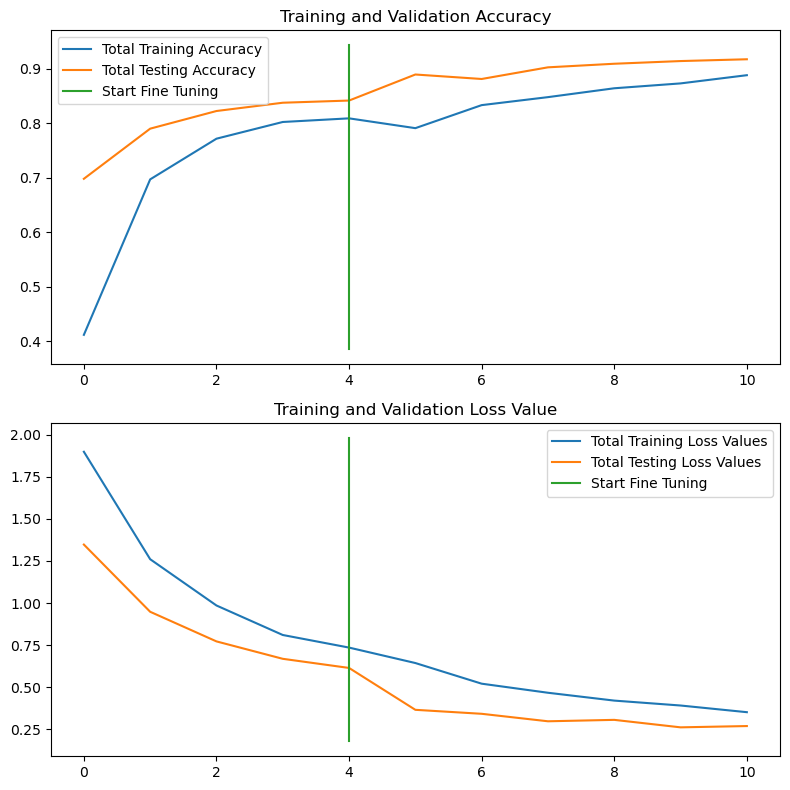

In [68]:
compare_histories(original_history= history_10_percent,
                  new_history= history_fine_full,
                  initial_epochs= 5)

## Viewing our experiment data on Tensorboard